In [2]:
#load required modules
import sys
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import pandas as pd
import datetime
from sodapy import Socrata
import requests
import numpy as np
import re
import seaborn as sns
import  json
import scipy
import sklearn
from datetime import timedelta, date, time, datetime as dt
import datetime
import shapely.geometry as geom
import holidays

In [3]:
#create functions to aplly to pandas 
from dateutil import tz
def local2utc(d):
    from_zone=tz.gettz('America/New_York')
    to_zone=tz.gettz('UTC')
    d.replace(tzinfo=from_zone)
    return d.astimezone(to_zone)

def isdem(permnumber):
    #if a permit starts with DEM its a demolition permit
    dem=re.compile('DEM')
    if dem.match(permnumber)==None:
        return False
    else:
        return True
    
def isuse(permnumber):
    #if a permit starts with USE  its a use permit
    use=re.compile('USE')
    if use.match(permnumber)==None:
        return False
    else:
        return True
def make_lower(nh):
    #make neighborhood names lowercase to ensure match
    if type(nh)==str:
        return nh.lower()
    else:
        return nh
    
def is_drug_charge(row):
    #determine if a drug charge has cds in description or is coded 87 (narcotics)
    cds=re.compile('cds',re.I)
    try:
        if row['incidento'][0:1]=='87':
            return True
        elif cds.search(row['chargedescription'])!=None:
            return True
        else:
            return False
    except:
        return False

def pull_year(dt_obj):
    #determine year from date for group by function
    return dt_obj.year

def pull_date(dt_obj):
    #determine year from date for group by function
    return dt_obj.date

def r2(fit, x, y):
    #calculate R2 from a fit and the input data
    p=np.poly1d(fit)
    yhat=p(x)
    ybar=np.sum(y)/len(y)
    ssres=np.sum((yhat-y)**2)
    sstotal=np.sum((y-ybar)**2)
    rsquared=1-ssres/sstotal
    return rsquared

def str2dt(s):
    return dt.strptime(s,'%Y-%m-%dT%H:%M:%SZ')

def str2time(s):
    return dt.strptime(s,'%H:%M:%S %p').time()

def label_coord(coord):
    #lookup grid no from coordinates, can be applied to pandas
    if coord in coord_labels.keys():
        return coord_labels[coord]
    else:
        return np.nan

def label2coord(lab):
    #lookup coordinates from grid no
    if np.isfinite(lab):
        return tuple(zip(labels_coord[lab]))
    else:
        return tuple(zip(tuple((np.nan,np.nan))))   
    
def daterange(start_date, end_date):
    #create a linear range of dates
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def hourrange(start_date, end_date):
    for n in range(int ((end_date-start_date).total_seconds()/60**2)):
        yield start_date+timedelta(hours=n)

def nan2zero(o):
    #convert nan to zero, typicaly applies if nan is created from a merge between records
    #and the gid attributes dataframe if none of the record contain the grid point
    if np.isnan(o):
        return  0
    else:
        return o
    
def pull_lat(location):
    #pull latitude from location given in dict format, check if saved in csv file as string
    if type(location)==str:
        location=location.replace("'",'"')
        location=json.loads(location)
    try:
        return location['coordinates'][1]
    except Exception:
        return np.nan
def pull_lon(location):
    #pull longitude from location given in dict format, check if saved in csv file as string
    if type(location)==str:
        location=location.replace("'",'"')
        location=json.loads(location)
    try:
        return location['coordinates'][0]
    except Exception:
        return np.nan

def gc_distance(lat1, lon1, lat2, lon2):
    #calculate distance between two coordinateds using the haversine formula
    lat1=lat1*2*np.pi/360
    lat2=lat2*2*np.pi/360
    lon1=lon1*2*np.pi/360
    lon2=lon2*2*np.pi/360
    dphi=lat1-lat2
    dlambda=lon1-lon2
    arc=2*np.arcsin((np.sin(dphi/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin(dlambda/2)**2)**.5)
    return 3959*arc

def place_on_grid(df, location_key):
    #convert latitude and longitude given in a location dict into the grid
    df['latitude']=df[location_key].apply(pull_lat)
    df['longitude']=df[location_key].apply(pull_lon)
    df['lat_bin']=pd.cut(df['latitude'],bins=lats,labels=lat_label)
    df['lon_bin']=pd.cut(df['longitude'],bins=lons,labels=lon_label)
    df['grid_no']=df.apply(lambda x: label_coord(tuple((x['lat_bin'], x['lon_bin']))), axis=1)
    df['grid_coords']=df['grid_no'].apply(label2coord)
    return df

def obj_min_dist(a,b):
    return(a.distance(b)/1609.2446469)

# Load Data From APIs

In [4]:
#Connect to api
client = Socrata("data.baltimorecity.gov", None)

In [4]:
#download the victim based crime dataset make into dataframe, make 
#crimedate into a datetime object, make neighborhood lowercase
results = client.get("4ih5-d5d5",limit=300000)
vict_crime=pd.DataFrame.from_records(results)
vict_crime['crimedate']=pd.to_datetime(vict_crime['crimedate'],yearfirst=True)
vict_crime.neighborhood=vict_crime.neighborhood.apply(make_lower)
vict_crime.to_csv('vict_crime.csv')

In [5]:
results = client.get('g2jf-x8pp',limit=10000)
liquor_locs=pd.DataFrame.from_records(results)

#download housing permits, determine if the are use or demolition permits,
#make permit date into a datetime, make the neighborhood lowercase
perm_res=client.get('9t78-k3wf',limit=600000)
house_perm_df=pd.DataFrame.from_records(perm_res)
house_perm_df['dateissue']=pd.to_datetime(house_perm_df.dateissue,yearfirst=True)
house_perm_df['isdem']=house_perm_df.casenum.apply(isdem)
house_perm_df['isuse']=house_perm_df.casenum.apply(isuse)
house_perm_df['neighborhood']=house_perm_df.neighborhood.apply(make_lower)
house_perm_df['latitude']=house_perm_df['location'].apply(pull_lat)
house_perm_df['longitude']=house_perm_df['location'].apply(pull_lon)
house_perm_df.to_csv('house_perm.csv')

#Dowload vacant house dataset, make neighborhood lowercase
vac_res=client.get('rw5h-nvv4',limit=17000)
vac_df=pd.DataFrame.from_records(vac_res)
vac_df.neighborhood=vac_df.neighborhood.apply(make_lower)
vac_df.to_csv('vacant.csv')

#Download arrest data, determine if it is a drug charge, convert date to 
#datetime object, make neighborhood lower case
arrest_res=client.get('icjs-e3jg',limit=160000)
arrest_df=pd.DataFrame.from_records(arrest_res)
arrest_df.is_drugs=arrest_df.apply(is_drug_charge, axis=1)
arrest_df.arrestdate=pd.to_datetime(arrest_df.arrestdate,yearfirst=True)
arrest_df['neighborhood']=arrest_df.name1.apply(make_lower)
arrest_df.to_csv('arrest.csv')

#download location of parks and zoning data
import json
park_response=requests.get('http://gis-baltimore.opendata.arcgis.com/datasets/583030920e7f41089e01aff63bd305e6_0.geojson')
park_dict=park_response.json()
parks=park_dict['features'];
with open('parks.json', 'w') as f:
    json.dump(park_response.json(),  f)

start_date = date(2012, 1, 1)
end_date = date.today()
sun_info=list()
for sd in daterange(start_date, end_date):
    param={'lat':39.25,'lng':-76.6,'date':sd.strftime('%Y-%m-%d')}
    resp=requests.get('https://api.sunrise-sunset.org/json?',params=param)
    rdict=resp.json()
    sun_dict=rdict['results']
    sun_dict['date']=sd
    sun_info.append(sun_dict)
    print(sd.strftime('%Y-%m-%d'))
sun_df=pd.DataFrame(sun_info)
sun_df.to_csv('baltimore_sunset.csv')  

Read Static Data from CSV files to avoid iternet bottleneck

for years in range(2012,2018):
    param={'stid':'kbwi','start':date(years,1,1).strftime('%Y%m%d%H%M'),
       'end':(date(years,12,31)).strftime('%Y%m%d%H%M'),
      'token':'34d783ecbaa3414e8f942227b22c1ab0'}
    weath_req=requests.get('https://api.mesowest.net/v2/stations/timeseries?',params=param)
    if years==2012:
        wdict=weath_req.json()['STATION'][0]['OBSERVATIONS']
        weather_df=pd.DataFrame(wdict)
        print(weather_df.columns)
    else:
        wdict=weath_req.json()['STATION'][0]['OBSERVATIONS']
        weather_df.append(pd.DataFrame(wdict))
weather_df=weather_df[['date_time','air_temp_set_1','precip_accum_24_hour_set_1','precip_accum_one_hour_set_1','weather_condition_set_1d']]
weather_df.to_csv('bwi_weather.csv')

In [6]:
b=requests.get('https://opendata.arcgis.com/datasets/44253e8ca1a04c08b8666d212e04a900_11.geojson')
bus_dict=b.json()
bus=bus_dict['features']

In [ ]:
rp=requests.get('http://gis-baltimore.opendata.arcgis.com/datasets/b41551f53345445fa05b554cd77b3732_0.geojson')
prop_dict=rp.json()
prop=prop_dict['features']
with open('property.json', 'w') as f: json.dump(rp.json(), f)

In [8]:
ez=requests.get('http://gis-baltimore.opendata.arcgis.com/datasets/9a906cd5934a43d3bdc6051a3bb91840_0.geojson')
ez_dict=ez.json()
ent=ez_dict['features']
with open('enterprise_zones.json', 'w') as f: json.dump(ez.json(), f)

In [9]:
house_perm_df=pd.read_csv('house_perm.csv')
house_perm_df.dateissue=pd.to_datetime(house_perm_df.dateissue,yearfirst=True)
house_perm_df['isdem']=house_perm_df.casenum.apply(isdem)
house_perm_df['isuse']=house_perm_df.casenum.apply(isuse)
house_perm_df['neighborhood']=house_perm_df.neighborhood.apply(make_lower)
vict_crime=pd.read_csv('vict_crime.csv')
vict_crime['crimedate']=pd.to_datetime(vict_crime['crimedate'],yearfirst=True)
arrest_df=pd.read_csv('arrest.csv')
arrest_df.arrestdate=pd.to_datetime(arrest_df.arrestdate,yearfirst=True)
arrest_df.is_drugs=arrest_df.apply(is_drug_charge, axis=1)
arrest_df['neighborhood']=arrest_df.name1.apply(make_lower)
vac_df=pd.read_csv('vacant.csv')
sun_df=pd.read_csv('baltimore_sunset.csv')
sun_df['date']=pd.to_datetime(sun_df['date'],yearfirst=True)
with open('parks.json') as json_data:
    park_dict=json.load(json_data)
parks=park_dict['features'];
with open('property.json') as json_data:
    prop_dict=json.load(json_data)
prop=prop_dict['features']
weather_df=pd.read_csv('bwi_weather.csv')
weather_df['date_time']=weather_df['date_time'].apply(str2dt)

/home/kevin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,12,14,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Analysis By Neighborhood

In [10]:
#aggregate downloaded data by neighborhood
fig=plt.figure(figsize=(24,24))
ax1=fig.add_subplot(121)
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
#read shapefile of baltimore neigborhoods, qgis was used to convert projection 
#shape file supplied to a geographic shape file
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
#make list of neighborhoods in map
basemap_nhs=list()
for nh in map.hoods_info:
    basemap_nhs.append(nh['Name'].lower())
    
unique_nhs=list(set(basemap_nhs))
unique_meta=list()
#create disctionary of meta data supplied in shape file in addition  to the  data which 
#was collected from the open data site
for nh in unique_nhs:
    meta=map.hoods_info[basemap_nhs.index(nh)]
    meta['Name']=nh
    meta['buildings']=meta['Occupied']+meta['Vacant']
    #assosciate gathered data to each neighborhood
    meta['vict_crime_2012']=vict_crime.crimedate[(vict_crime.crimedate>'1/1/2012') &
                                                 (vict_crime.crimedate<'1/1/2013') & 
                                                 (vict_crime.neighborhood==nh)].count()
    meta['vict_crime_2016']=vict_crime.crimedate[(vict_crime.crimedate>'1/1/2016') & 
                                                 (vict_crime.crimedate<'1/1/2017') &
                                                 (vict_crime.neighborhood==nh)].count()
    
    if meta['vict_crime_2012']>0:
        meta['vict_crime_change']=np.divide(meta['vict_crime_2016']-meta['vict_crime_2012'],
                                            meta['vict_crime_2012'])
    else:
        meta['vict_crime_change']=np.nan
    meta['vac_filled']=house_perm_df.existing_use[(house_perm_df.isuse==True) & 
                                                  (house_perm_df.existing_use=='VAC') & 
                                                  (house_perm_df.neighborhood==nh) &
                                                  (house_perm_df.dateissue>'1/1/2012') &
                                                  (house_perm_df.dateissue<'1/1/2017')].count()
    meta['demo']=house_perm_df.isdem[(house_perm_df.isdem==True) & (house_perm_df.neighborhood==nh)
                                           & (house_perm_df.dateissue>'1/1/2012') &
                                            (house_perm_df.dateissue<'1/1/2017')].count()
    meta['vacant']=vac_df.neighborhood[vac_df.neighborhood==nh].count()
    meta['vac_change']=np.divide(meta['vac_filled']+meta['demo'],meta['vac_filled']+meta['demo']+meta['vacant'])    
    meta['filled_o_vac']=np.divide(meta['vac_filled'],meta['vac_filled']+meta['vacant'])
    meta['drug_crime_2013']=arrest_df.is_drugs[(arrest_df.is_drugs==True) & (arrest_df.arrestdate>'1/1/2013')
                                              & (arrest_df.arrestdate<'1/1/2014') 
                                              & (arrest_df.neighborhood==nh)].count()
    meta['drug_crime_2016']=arrest_df.is_drugs[(arrest_df.is_drugs==True) & (arrest_df.arrestdate>'1/1/2016')
                                              & (arrest_df.arrestdate<'1/1/2017') 
                                              & (arrest_df.neighborhood==nh)].count()
    meta['drug_crime_change']=np.divide(meta['drug_crime_2016']-meta['drug_crime_2013'],meta['drug_crime_2013'])
    unique_meta.append(meta)

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
NH_df=pd.DataFrame(unique_meta)
NH_df.Name.apply(make_lower)
#convert rates to percentages
NH_df.vict_crime_change=NH_df.vict_crime_change*100
NH_df.filled_o_vac=NH_df.filled_o_vac*100
NH_df.drug_crime_change=NH_df.drug_crime_change*100
NH_df.Vac_filled_norm=NH_df.vac_filled/NH_df.buildings
cmap = mpl.cm.get_cmap('coolwarm')
norm = mpl.colors.Normalize(-75,75)
color_producer=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer.set_array(np.linspace(-75,75,20))

In [ ]:
fig=plt.figure(figsize=(12,12))
norm = mpl.colors.Normalize(0,100)
color_producer2=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer2.set_array(np.linspace(0,100,20))
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
ax3=plt.gca()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer2.to_rgba(row.filled_o_vac)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            ax3.add_patch(poly)
ax3.set_title('Fig. 1 Vacant Homes Moved Into (%)')
plt.colorbar(color_producer2,ax=ax3)
plt.show()


In [ ]:
fig=plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-76.75,llcrnrlat=39.1,urcrnrlon=-76.5,urcrnrlat=39.4,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
ax1=plt.gca()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer.to_rgba(row.vict_crime_change)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            #if meta['vict_crime_change']==np.nan:
             #   poly=Polygon(seg, facecolor='grey',edgecolor='grey')
            #elif meta['vict_crime_change']<0:
            #    poly=Polygon(seg, facecolor='green',edgecolor='green')
            #else:
            #    poly=Polygon(seg, facecolor='red',edgecolor='red')
            ax1.add_patch(poly)
ax1.set_title('Fig. 2 Change in Victim Based Crime 2012-2016 (%)')
plt.colorbar(color_producer,ax=ax1)
plt.show()

            

In [ ]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
ax=sns.regplot(x='filled_o_vac',y='vict_crime_change',data=NH_df[NH_df.Vacant>20])
ax.set(xlabel='Vacant Houses Filled (%)', ylabel='Change in Crime Rate 2012-2016 (%)')
ax.set_title('Fig. 3  Relationship Between Filling Vacant Houses and Crime')
plt.show()

/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


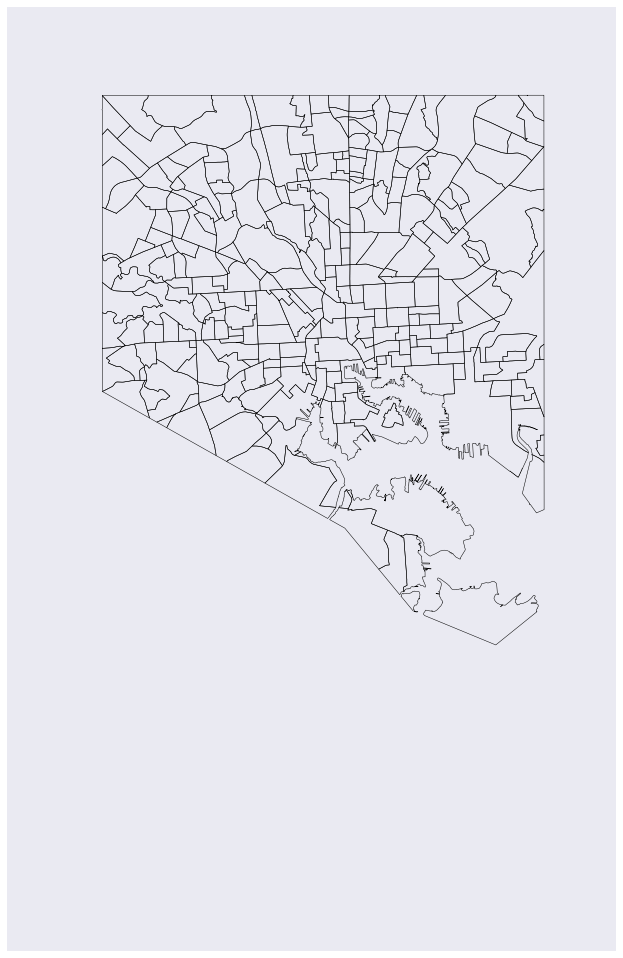

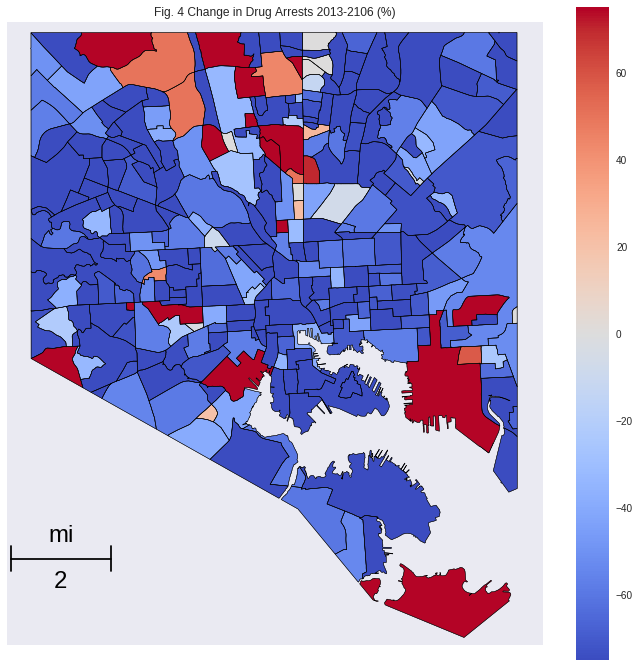

In [12]:
fig=plt.figure(figsize=(12,12))
map = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
map.drawmapscale(-76.70, 39.22, -76.625, 39.175, 2, barstyle='simple', units='mi', fontsize=24, yoffset=None, labelstyle='simple', fontcolor='k', fillcolor1='w', fillcolor2='k')
ax2=plt.gca()
polygons=list()
for index,row in NH_df.iterrows():
    for i, x in enumerate(basemap_nhs):
        if x==row.Name:
            seg=map.hoods[i]
            polycolor=color_producer.to_rgba(row.drug_crime_change)
            poly=Polygon(seg, facecolor=polycolor, edgecolor='black')
            polygons.append(poly)
            ax2.add_patch(poly)
ax2.set_title('Fig. 4 Change in Drug Arrests 2013-2106 (%)')
plt.colorbar(color_producer,ax=ax2)
plt.show()

In [ ]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
ax=sns.regplot(x='vac_change',y='drug_crime_change',data=NH_df[(NH_df.Vacant>20) & (NH_df.vac_change>0)])
ax.set(title='Fig. 5 Relationship Between Filling Vacant Houses and Drug Crime')
ax.set(xlabel='Vacant Houses Filled (%)',ylabel='Change in Drug Arrests(%)')
plt.show()

In [ ]:
fig=plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
arrest_df['year']=arrest_df['arrestdate'].apply(pull_year)
arr_by_year_drugs=arrest_df[arrest_df.is_drugs==True].groupby('year').count()
arr_by_year_drugs['years']=[2013,2014,2015,2016,2017]
ax=sns.regplot(x='years',y='arrestdate',data=arr_by_year_drugs,fit_reg=False)
ax.set(xlabel='Year',ylabel='Number of Drug Arrests',title='Fig.6 Drug Arrests Per Year')
plt.show()

# Look at trends based on the grid and static predictors


Make a 0.1 mile by 0.1 mile grid, with labels at the centroids.

In [13]:
bmap = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
bmap.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
lons, lats, x, y = bmap.makegrid(107, 124, returnxy=True)
lats=sorted(lats[:,0])
lons=sorted(lons[0,:])
lon_label=list()
for i,lon in enumerate(lons):
    if i>0:
        lon_label.append((lons[i]+lons[i-1])/2)
lat_label=list()
for i,lat in enumerate(lats):
    if i>0:
        lat_label.append((lats[i]+lats[i-1])/2)

In [14]:
rp=requests.get('http://gis-baltimore.opendata.arcgis.com/datasets/b41551f53345445fa05b554cd77b3732_0.geojson')
prop_dict=rp.json()
prop=prop_dict['features']
with open('property.json', 'w') as f: json.dump(rp.json(), f)

Create a map which assigns a number to each grid centroid in the city, also make a reverse mapping

In [15]:
#identify the set of nodes that are in the city
plt.figure(figsize=(24,24))
coord_set=[(x,y) for x in lat_label for y in lon_label]
point_set=[bmap(y,x) for x in lat_label for y in lon_label]
grid_bools=list()
for poly in polygons:
    p=poly.get_path()
    in_sec=p.contains_points(point_set)
    grid_bools.append(in_sec)
grid_bools=np.array(grid_bools)    
coord_set_2=list()
for i, coord in enumerate(coord_set):
    if max(grid_bools[:,i])==True:
        coord_set_2.append(coord)
point_set_2=[bmap(coord[1],coord[0]) for coord in coord_set_2]
x,y=zip(*point_set)

In [16]:
coord_labels=dict()
for i,coord in enumerate(coord_set_2):
    coord_labels[coord]=i
labels_coord = {v: k for k, v in coord_labels.items()}

In [17]:
def label2coord(lab):
    if np.isfinite(lab):
        return tuple(zip(labels_coord[lab]))
    else:
        return tuple(zip(tuple((np.nan,np.nan))))

Create dictionary of park features with meta data a shapely poygon matplotlib patches polygon and matplotlib patches path for each park

In [18]:
def np2list_of_tuple(a):
    b=list()
    a=a.tolist()
    for c in a:
        b.append(tuple(c))
    return b

park_feature=list()
park_polygons=list()
park_s_poly=list()
for p in parks:
    if p['type']=='Feature':
        p_dict=p['properties']
        for poly in p['geometry']['coordinates']:
            if type(poly[0][0])==list:
                for p2 in poly:
                    a=np.array(p2)
                    a[:,0],a[:,1]=bmap(a[:,0],a[:,1])
                    b=np2list_of_tuple(a)
                    p_dict['spl_poly']=geom.Polygon(b)
                    park_s_poly.append(p_dict['spl_poly'])
                    p_dict['poly']=Polygon(a,facecolor='green')
                    park_polygons.append(p_dict['poly'])
                    p_dict['path']=p_dict['poly'].get_path()
                    
            else:
                a=np.array(poly)
                a[:,0],a[:,1]=bmap(a[:,0],a[:,1])
                b=np2list_of_tuple(a)
                p_dict['spl_poly']=geom.Polygon(b)
                park_s_poly.append(p_dict['spl_poly'])
                p_dict['poly']=Polygon(a,facecolor='green')
                p_dict['path']= p_dict['poly'].get_path()
                park_feature.append(p_dict)
                park_polygons.append(p_dict['poly'])

Create a list of linestring reprsenting the bus routes in maryland

In [19]:
bus_feature=list()
bus_s_ls =list()
for b in bus:
    if b['type']=='Feature':
        for line in b['geometry']['coordinates']:
            if type(line[0][0])==list:
                for l in line:
                    a=np.array(l)
                    if ((max(a[:,0])>-76.72) and (min(a[:,0])<-76.52) and (max(a[:,1])>39.15) and (min(a[:,1]<39.375))):         
                        a[:,0],a[:,1]=bmap(a[:,0],a[:,1])
                        b=np2list_of_tuple(a)
                        bus_s_ls.append(geom.LineString(b))
            else:
                a=np.array(line)
                if ((max(a[:,0])>-76.72) and (min(a[:,0])<-76.52) and (max(a[:,1])>39.15) and (min(a[:,1]<39.375))):         
                    a[:,0],a[:,1]=bmap(a[:,0],a[:,1])
                    b=np2list_of_tuple(a)
                    bus_s_ls.append(geom.LineString(b))

Loop through real property parcels and make it into a dataframe

In [20]:
def dig_through_nest(b):
    try:
        a=geom.Polygon(b)
        return a
    except Exception:
        print(b[0])
        dig_through_nest(b[0])

prop_features=list()
for p in prop:
    if p['type']=='Feature':
        p_dict=p['properties']
        for parcel in p['geometry']['coordinates']:
            if type(parcel[0][0])==list():
                for par in parcel:
                    a=np.array(par)
                    b=np2list_of_tuple(a)
                    poly=dig_through_nest(b)
                    print(poly)
                    pt=poly.representative_point()
                    p_dict['latitude']=pt.coords[0][1]
                    p_dict['longitude']=pt.coords[0][0]
                prop_features.append(p_dict)
            else:
                a=np.array(parcel)
                if len(np.shape(a))==3:
                    a=np.array(parcel[0])
                b=np2list_of_tuple(a)
                poly=dig_through_nest(b)
                pt=poly.representative_point()
                p_dict['latitude']=pt.coords[0][1]
                p_dict['longitude']=pt.coords[0][0]
                prop_features.append(p_dict)
prop_df=pd.DataFrame(prop_features)
            

In [21]:
prop_df['lon_bin']=pd.cut(prop_df['longitude'],bins=lons,labels=lon_label)
prop_df['lat_bin']=pd.cut(prop_df['latitude'],bins=lats,labels=lat_label)
prop_df['grid_coords']=tuple(zip(prop_df['lat_bin'], prop_df['lon_bin']));
prop_df['grid_no']=prop_df['grid_coords'].apply(label_coord)

Aggregate base crime by year and by grid loocation

In [151]:
vict_crime=place_on_grid(vict_crime,'location_1')
vict_crime['year']=vict_crime.crimedate.apply(pull_year)
vict_crime_grid=vict_crime.groupby(['year','grid_no'])[['crimecode']].count()
vict_crime_grid.reset_index(level=['grid_no','year'], inplace=True)
vict_crime_grid.rename(columns={'crimecode':'incidents'}, inplace=True)

In [152]:
vict_crime_grid['grid_coords']=vict_crime_grid['grid_no'].apply(label2coord)

Aggregate building permit data by year and grid location

In [95]:
house_perm_df=place_on_grid(house_perm_df,'location')
house_perm_df['issueyear']=house_perm_df['dateissue'].apply(pull_year)
house_perm_df.cost_est=house_perm_df['cost_est'].apply(float)
hp_grid=house_perm_df.groupby(['issueyear','grid_no']).cost_est.agg(['sum','count'])
hp_grid.reset_index(level=['grid_no','issueyear'], inplace=True)

Add 0 values for years/grids where no crime occured

In [155]:
new_rows=list()
for year in vict_crime_grid['year'].unique():
    vict_crime_year=vict_crime_grid[vict_crime_grid['year']==year]
    gcoords=set(vict_crime_year['grid_no']);
    for g in labels_coord.keys():
        if g not in gcoords:
            new_rows.append(list([year,labels_coord[g],g,0]))
print(len(new_rows))
new_rows_df=pd.DataFrame(new_rows, columns=list(['year','grid_coords','grid_no','incidents']))
vict_crime_grid=pd.concat([vict_crime_grid,new_rows_df], ignore_index=True)

18050


"Flatten" Data Frame by the grid coordinates such that housing permits and years are in different columns, not differnt years

In [158]:
#vict_crime_grid['incidents']=vict_crime_grid['incidents'].apply(float)
vict_crime_2012=vict_crime_grid[(vict_crime_grid['year']==2012) & (np.isfinite(vict_crime_grid['grid_no']))]
vict_crime_2013=vict_crime_grid[(vict_crime_grid['year']==2013) & (np.isfinite(vict_crime_grid['grid_no']))]
vc_by_year=vict_crime_2012.set_index('grid_no').join(vict_crime_2013.set_index('grid_no'),  lsuffix='2012',rsuffix='2013', how='left')
vc_by_year['change2013']=vc_by_year['incidents2013']-vc_by_year['incidents2012']
vc_by_year.drop('year2012',1,inplace=True)
vc_by_year.drop('year2013',1,inplace=True)
vc_by_year.drop('grid_coords2013',1,inplace=True)
for year in range(2014,2018):
    vict_crime_year=vict_crime_grid[(vict_crime_grid['year']==year) & (np.isfinite(vict_crime_grid['grid_no']))]
    vict_crime_year.drop('year',1,inplace=True)
    vict_crime_year.drop('grid_coords',1,inplace=True)
    vict_crime_year.columns=['grid_no','incidents'+str(year)]
    vc_by_year=vc_by_year.join(vict_crime_year.set_index('grid_no'),how='inner')
    vc_by_year['change'+str(year)]=vc_by_year['incidents'+str(year)]-vc_by_year['incidents2012']


/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


### Parse Real Property Data for the portion of buildings in a grid which are residential, and the avg single family hosue cost

In [160]:
def portion_res(df, grid_no):
    a=df[df['grid_no']==grid_no]
    res_count=a[a['USEGROUP']=='R '].count()
    all_count=a.count()
    return res_count[0]/all_count[0]
def avg_house_cost(df, grid_no):
    a=df[df['grid_no']==grid_no]
    b=a[a['DHCDUSE1']=='1008']
    value=a['CURRIMPR']+a['CURRLAND']
    return value.mean()
vc_by_year['grid_no']=vc_by_year.index
vc_by_year['portion_res']=vc_by_year['grid_no'].apply(lambda x: portion_res(prop_df,x))
vc_by_year['house_cost']=vc_by_year['grid_no'].apply(lambda x: avg_house_cost(prop_df,x))

In [105]:
vc_by_year.head(5)

grid_coords2012  incidents2012  incidents2013  \
grid_no                                                                  
0.0       (39.1986595759, -76.553297296)              0              0   
1.0      (39.1986595759, -76.5514136508)              0              0   
2.0      (39.1986595759, -76.5495300058)              0              0   
3.0      (39.1986595759, -76.5476463608)              0              0   
4.0      (39.2001234063, -76.5570645865)              0              0   

         change2013  incidents2014  change2014  incidents2015  change2015  \
grid_no                                                                     
0.0               0              0           0              0           0   
1.0               0              0           0              0           0   
2.0               0              0           0              0           0   
3.0               0              0           0              0           0   
4.0               0              0           0              0           0   

         incidents2016  change2016   ...    grid_no  sum2014  count2014  \
grid_no                              ...                                  
0.0                  0           0   ...        0.0      0.0        0.0   
1.0                  0           0   ...        1.0      0.0        0.0   
2.0                  0           0   ...        2.0      0.0        0.0   
3.0                  0           0   ...        3.0      0.0        0.0   
4.0                  0           0   ...        4.0      0.0        0.0   

         sum2015  count2015  sum2016  count2016  sum2017  count2017  ispark  
grid_no                                                                      
0.0          0.0        0.0      0.0        0.0      0.0        0.0   False  
1.0          0.0        0.0      0.0        0.0      0.0        0.0   False  
2.0          0.0        0.0      0.0        0.0      0.0        0.0   False  
3.0          0.0        0.0      0.0        0.0      0.0        0.0   False  
4.0          0.0        0.0      0.0        0.0      0.0        0.0   False  

[5 rows x 22 columns]

In [161]:
def nan2zero(val):
    if np.isnan(val):
        return 0
    else:
        return val
    
for year in range(2014,2018):
    hp_year=hp_grid[hp_grid['issueyear']==year];
    hp_year.drop('issueyear',1,inplace=True)
    hp_year.columns=['grid_no','sum'+str(year),'count'+str(year)]
    vc_by_year=vc_by_year.join(hp_year.set_index('grid_no'))
    vc_by_year['sum'+str(year)]=vc_by_year['sum'+str(year)].apply(nan2zero)
    vc_by_year['count'+str(year)]=vc_by_year['count'+str(year)].apply(nan2zero)
   

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Determine if a point is in a park

In [162]:
point_set_2=[bmap(coord[1],coord[0]) for coord in coord_set_2]
park_bools=list()
for poly in park_polygons:
    p=poly.get_path()
    in_sec=p.contains_points(point_set_2)
    park_bools.append(in_sec)
park_bools=np.array(park_bools)    
park_set=list()
for i, coord in enumerate(coord_set_2):
    if max(park_bools[:,i])==True:
        park_set.append(coord)
park_point_set=[bmap(coord[1],coord[0]) for coord in park_set]
x,y=zip(*point_set)
park_grid_no=[coord_labels[x] for x in park_set]
vc_by_year['ispark']=False
vc_by_year.loc[park_grid_no,'ispark']=True

### find distance to the nearest park and busline

In [163]:
def obj_min_dist(a,b):
    return(a.distance(b)/1609.2446469)

def find_closest_distance(a,s_list):
    x,y=bmap(a[1],a[0])
    if type(x)==tuple:
        x=x[0]
        y=y[0]
    pt=geom.Point((x,y))
    min_distance=10000
    for s in s_list:
        d=obj_min_dist(pt,s)
        if d<min_distance:
            min_distance=d
    return min_distance

def dist_to_park(a,s_list,is_park):
    if is_park==True:
        return 0
    else:
        return find_closest_distance(a,s_list)

vc_by_year['dist_to_park']=vc_by_year.apply(lambda x: dist_to_park(x['grid_coords2012'],park_s_poly,
                                                                           x['ispark']), axis=1)
vc_by_year['dist_to_bus']=vc_by_year.apply(lambda x: find_closest_distance(x['grid_coords2012'], bus_s_ls),
                                                                          axis=1)

In [164]:
vc_by_year.shape

(7951, 26)

### find number of vacant and crime incidents homes within grid and within 1/2 mile of grid centroid

In [165]:
vac_df=place_on_grid(vac_df,'location')
a=vac_df.groupby('grid_no').lot.agg('count')
vc_by_year=vc_by_year.join(a,rsuffix='vacant',how='left')
vc_by_year.rename(columns={'lot':'vacants'}, inplace=True)

In [166]:
with open('half_mile_dict.json') as json_data:
    half_mile_dict=json.load(json_data)
half_mile_dict1=dict()
for i in half_mile_dict.keys():
    half_mile_dict1[float(i)]=half_mile_dict[i]
half_mile_dict=half_mile_dict1

def half_mile(c1):
    hm=list()
    for c2 in coord_set_2:
        if gc_distance(c1[0],c1[1],c2[0],c2[1])<0.5:
            hm.append(coord_labels[c2])
    return(hm)
            
half_mile_dict=dict()

for g in list(vc_by_year['grid_no'].unique()):
    half_mile_dict[g]=half_mile(labels_coord[g])
   

In [167]:
def count_in_half(df,x):
    grids=set(half_mile_dict[x])
    return df[(df['grid_no'].isin(grids))]['grid_no'].count()/len(grids)
vc_by_year['vac_half_mile']=vc_by_year.apply(
        lambda x: count_in_half(vac_df, x['grid_no']),axis=1)
vc_by_year['vacants']=vc_by_year['vacants'].apply(nan2zero)
vc_by_year['vac_half_mile']=vc_by_year['vac_half_mile'].apply(nan2zero)

In [169]:
for yr in range(2012,2018):
    vict_year=vict_crime[vict_crime['year']==yr]
#    vc_by_year['incidents'+str(year)]=vict_year.groupby('grid_no').count()
    vc_by_year['incidents_hm'+str(yr)]=vc_by_year.apply(
        lambda x: count_in_half(vict_year, x['grid_no']),axis=1)

In [170]:
vc_by_year['incidents'+str(year)]

grid_no
5.0        1
18.0       0
22.0       0
24.0       2
25.0       0
26.0       4
38.0       0
39.0       0
40.0       1
103.0      0
192.0      0
203.0      0
204.0      0
223.0      0
224.0      8
226.0      1
230.0      4
231.0      8
232.0      4
234.0      3
235.0     11
238.0      1
240.0      2
241.0      0
242.0      0
244.0      7
245.0     14
246.0     13
255.0      9
256.0     18
          ..
7884.0     0
7885.0     0
7886.0     2
7889.0     0
7890.0     0
7891.0     0
7892.0     0
7893.0     0
7894.0     0
7896.0     0
7897.0     0
7898.0     0
7899.0     0
7900.0     0
7902.0     0
7903.0     0
7905.0     0
7923.0     0
7924.0     0
7925.0     0
7926.0     0
7927.0     0
7928.0     0
7929.0     0
7930.0     0
7939.0     4
7941.0     2
7948.0     0
7949.0     0
7950.0     0
Name: incidents2017, Length: 7951, dtype: int64

### find number of liquor licenses within grid and within 1/2 mile of grid centroid

In [171]:
liquor_locs=place_on_grid(liquor_locs,'location_1')
a=liquor_locs.groupby('grid_no').addrstreet.nunique()
vc_by_year=vc_by_year.join(a,rsuffix='liquor',how='left')
vc_by_year.rename(columns={'addrstreet':'liquor'}, inplace=True)
vc_by_year['liquor']=vc_by_year['liquor'].replace(np.nan,0)
vc_by_year['liq_half_mile']=vc_by_year.apply(lambda x: count_in_half(liquor_locs, x['grid_no']),axis=1)

# Plot Maps and Perform Analysis

look at correlation of untransformed data

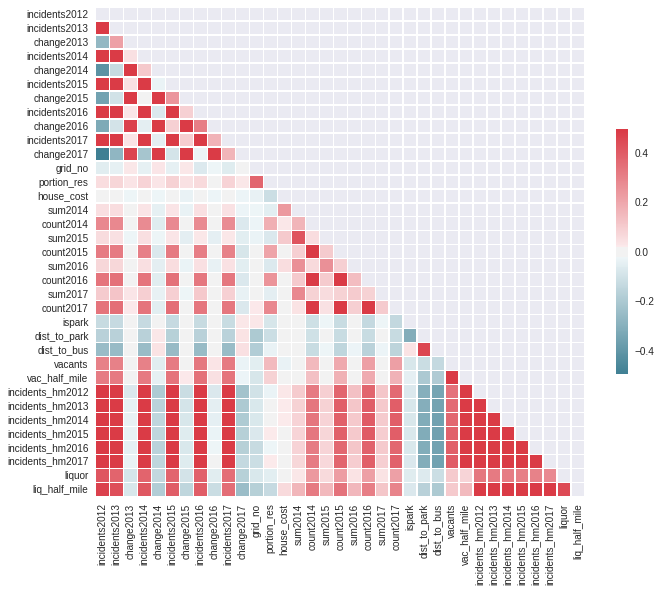

In [172]:
corr=vc_by_year.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Trasform log normal distributions to normal distributions, look at correlation

In [173]:
def apply_reg(df, col ,yr):
    y=list((df[col+str(yr-3)],df[col+str(yr-2)],df[col+str(yr-1)]))
    x=list((-3,-2,-1))
    a=np.polyfit(x,y,1)
    return a[0]
an_df=pd.DataFrame()
for yr in range(2015,2018):
    an_df['incidents_prior'+str(yr)]=np.log(vc_by_year['incidents'+str(yr-1)]+1)
    an_df['incidents_prior_hm'+str(yr)]=np.log(vc_by_year['incidents_hm'+str(yr-1)]+1)                             
    an_df['incidents_slope'+str(yr)]=vc_by_year.apply(lambda x: apply_reg(x,'incidents',yr), axis=1)
    an_df['incidents_slope_hm'+str(yr)]=vc_by_year.apply(lambda x: apply_reg(x,'incidents_hm',yr), axis=1)
#an_df['house_cost']=np.log(vc_by_year['house_cost'])
an_df['dist_to_bus']=np.log(vc_by_year['dist_to_bus'])
an_df['dist_to_park']=np.log(vc_by_year['dist_to_park'])
an_df['liquor']=vc_by_year['liquor']>0
an_df['liq_half_mile']=np.log(vc_by_year['liq_half_mile'])
#g=sns.pairplot(a,dropna=True)
plt.show()

/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


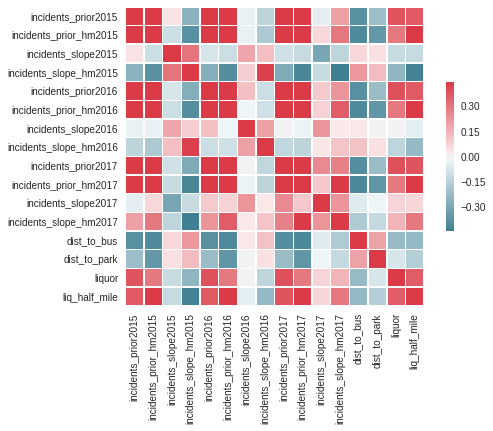

In [174]:
corr=an_df.corr()
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [176]:
## Plot crime distribution in 2012 2016 and 2017

(7951, 4)


/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


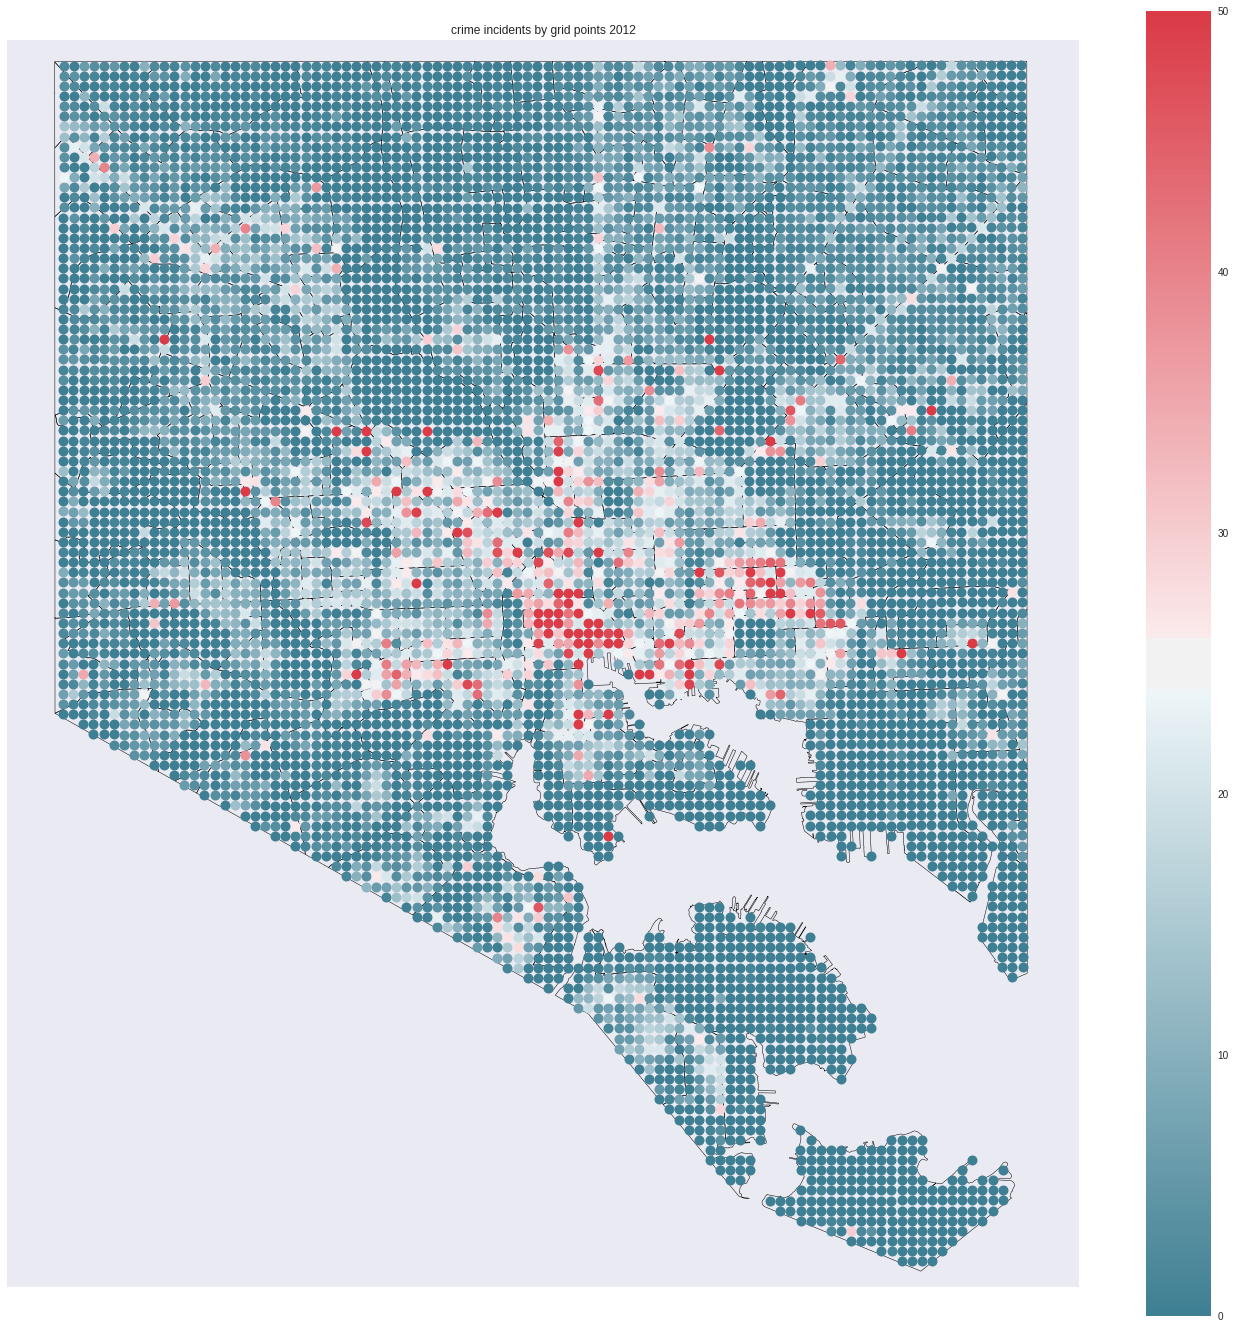

In [175]:
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
norm = mpl.colors.Normalize(0,50)
color_producer2=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer2.set_array(np.linspace(0,50,25))
vict_crime_year=vict_crime_grid[(vict_crime_grid['year']==2012) & (np.isfinite(vict_crime_grid['grid_no']))]
print(vict_crime_year.shape)
for row in vict_crime_year.iterrows():
    x,y=map(row[1]['grid_coords'][1],row[1]['grid_coords'][0])
    point_color=color_producer2.to_rgba(row[1]['incidents'])
    map.plot(x,y,linestyle='None',marker='.',markerfacecolor=point_color,markersize=20)
ax1=plt.gca()
plt.colorbar(color_producer2,ax=ax1)
ax1.set_title('crime incidents by grid points 2012')
plt.show()
    

/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


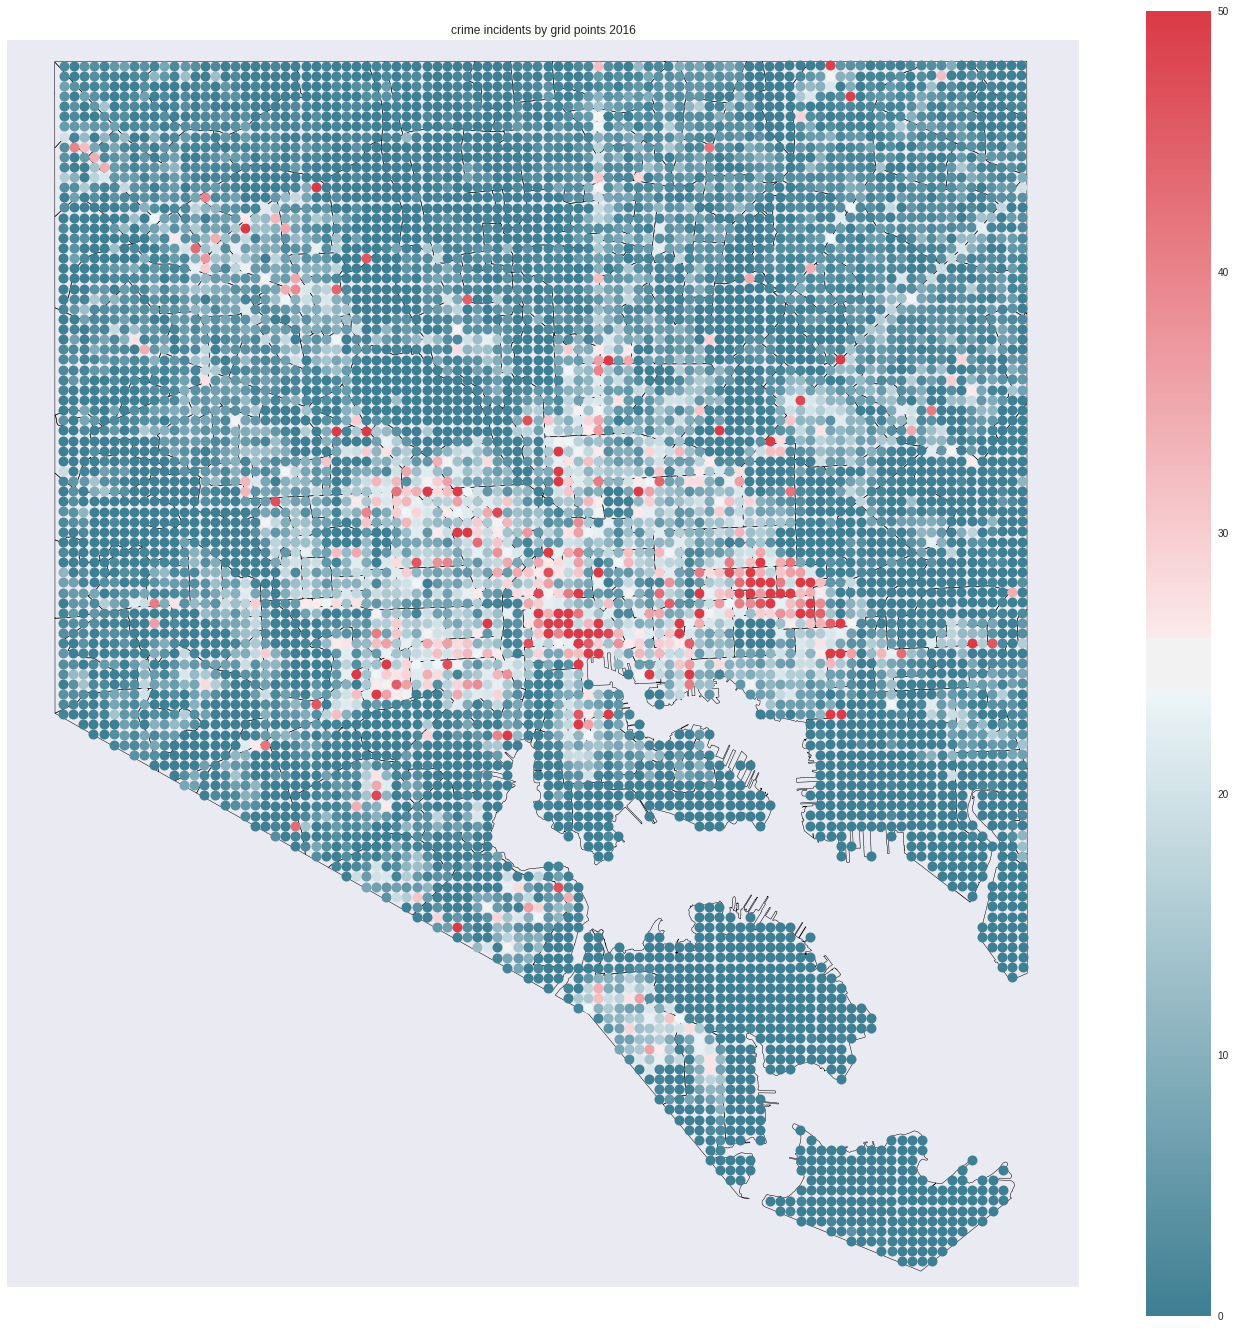

In [177]:
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
norm = mpl.colors.Normalize(0,50)
color_producer2=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer2.set_array(np.linspace(0,50,25))
vict_crime_year=vict_crime_grid[vict_crime_grid['year']==2016]
for row in vict_crime_year.iterrows():
    x,y=map(row[1]['grid_coords'][1],row[1]['grid_coords'][0])
    point_color=color_producer2.to_rgba(row[1]['incidents'])
    map.plot(x,y,linestyle='None',marker='.',markerfacecolor=point_color,markersize=20)
ax1=plt.gca()
plt.colorbar(color_producer2,ax=ax1)
ax1.set_title('crime incidents by grid points 2016')
plt.show()

/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/kevin/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


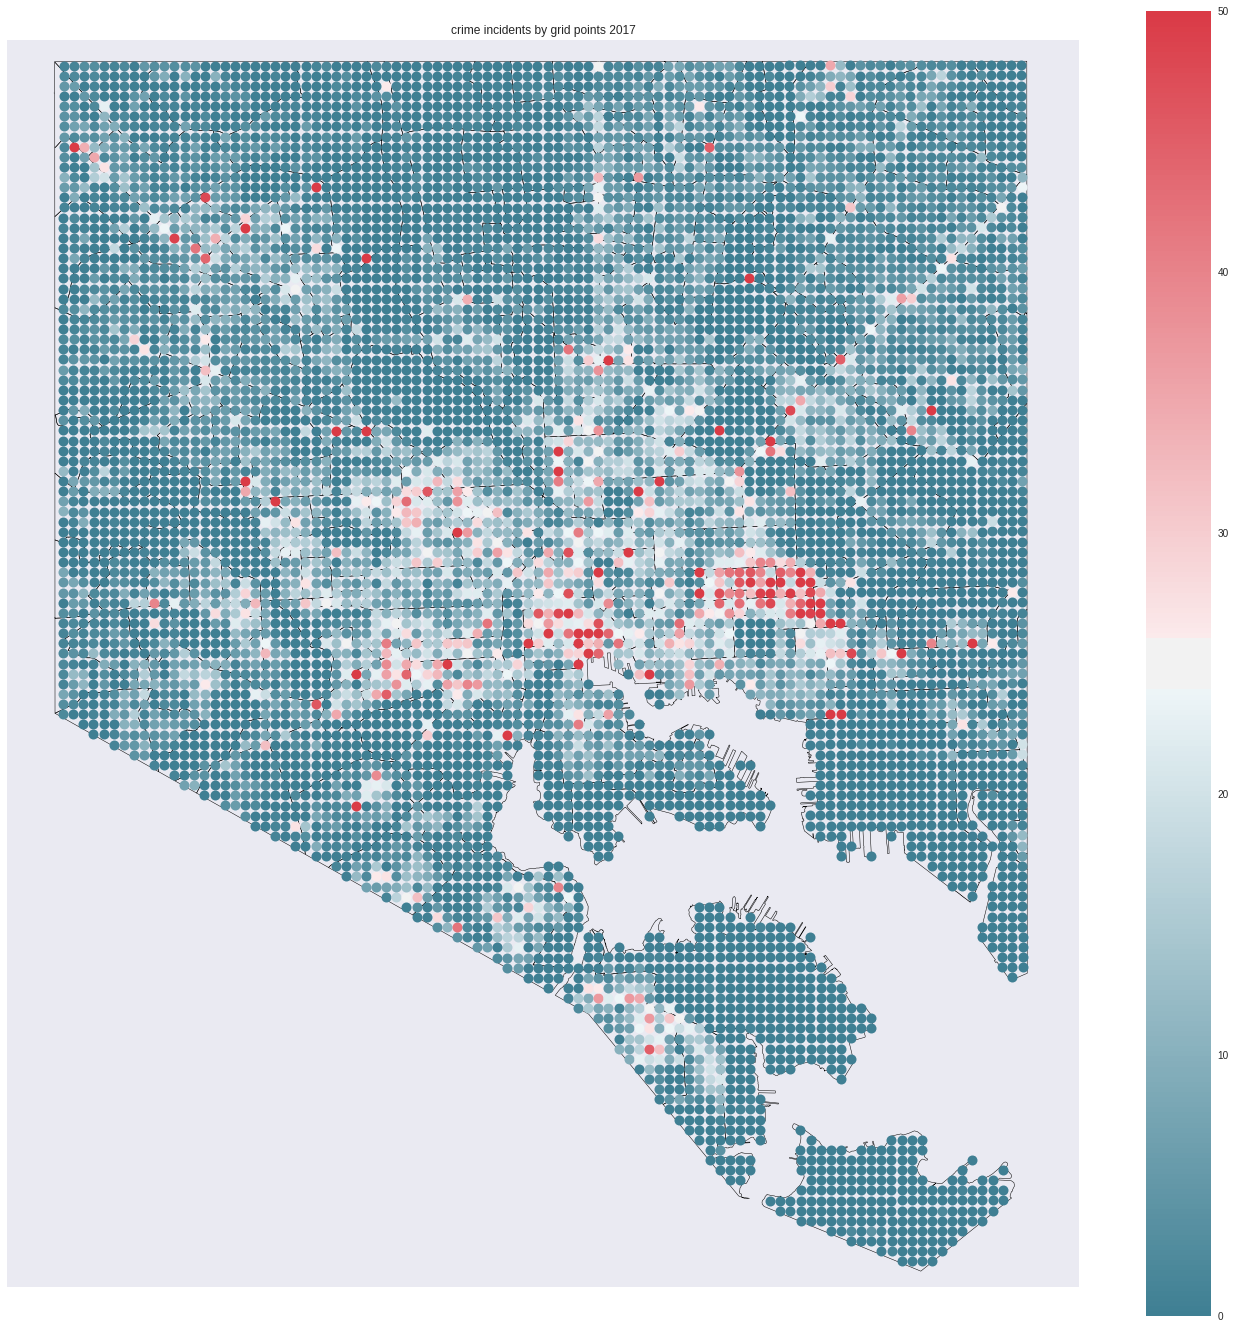

In [178]:
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-76.72,llcrnrlat=39.195,urcrnrlon=-76.52,urcrnrlat=39.375,projection='lcc', lat_0=39.25, lon_0=-76.65)
map.readshapefile('/home/kevin/TDI/Neighborhoods1','hoods',drawbounds=True)
norm = mpl.colors.Normalize(0,50)
color_producer2=mpl.cm.ScalarMappable(norm=norm,cmap=cmap)
color_producer2.set_array(np.linspace(0,50,25))
vict_crime_year=vict_crime_grid[vict_crime_grid['year']==2017]
for row in vict_crime_year.iterrows():
    x,y=map(row[1]['grid_coords'][1],row[1]['grid_coords'][0])
    point_color=color_producer2.to_rgba(row[1]['incidents'])
    map.plot(x,y,linestyle='None',marker='.',markerfacecolor=point_color,markersize=20)
ax1=plt.gca()
plt.colorbar(color_producer2,ax=ax1)
ax1.set_title('crime incidents by grid points 2017')
plt.show()

In [179]:
def r2(fit, x, y):
    p=np.poly1d(fit)
    yhat=p(x)
    ybar=np.sum(y)/len(y)
    ssres=np.sum((yhat-y)**2)
    sstotal=np.sum((y-ybar)**2)
    rsquared=1-ssres/sstotal
    return rsquared
r2_vals_change=list()
for year in range(2013,2017):
    x=vc_by_year['change'+str(year)];
    y=vc_by_year['change'+str(year+1)];
    fit=np.polyfit(x,y,1)
    r2_vals_change.append((year,r2(fit,x,y)))
    
    

In [ ]:
vac_df.shape

# Time transient Features

In [183]:
def nfl_start_date(df):
    base_date=nfl_wk_1_dict[df['season_year']]
    game_date=base_date+timedelta(weeks=df['week'])
    if df['day_of_week']=='monday':
        game_date=base_date+timedelta(days=1)
    elif df['day_of_week']=='saturday':
        game_date=base_date-timedelta(days=1)
    elif df['day_of_week']=='thursday':
        game_date=base_date-timedelta(days=3)
    game_time=(dt.strptime(df['start_time'],'%H:%M:%S')+timedelta(hours=12)).time()
    return dt.combine(game_date,game_time)
    
nfl_wk_1_dict={2012:date(2012,9,9), 2013:date(2013,9,8), 2014:date(2014,9,7),
               2015:date(2015,9,13), 2016:date(2016,9,11), 2017:date(2017,9,10)}
rav_sch=pd.read_csv('rav_schedule.csv')
rav_sch=rav_sch[rav_sch['season_year']>2011]
rav_sch['start_time']=rav_sch.apply(nfl_start_date,axis=1)
rav_sch['end_time']=rav_sch['start_time']+timedelta(hours=3.5)

In [184]:
sun_df=pd.read_csv('baltimore_sunset.csv')
sun_df['date']=pd.to_datetime(sun_df['date'],yearfirst=True)
sun_df['sunrise']=sun_df['sunrise'].apply(str2time)
sun_df['sunset']=sun_df['sunset'].apply(str2time)
sun_df['astronomical_twilight_begin']=sun_df['astronomical_twilight_begin'].apply(str2time)
sun_df['civil_twilight_begin']=sun_df['civil_twilight_begin'].apply(str2time)
sun_df['nautical_twilight_begin']=sun_df['nautical_twilight_begin'].apply(str2time)
sun_df['date']=sun_df['date'].dt.tz_localize('UTC')
sun_df.set_index('date',inplace=True)

In [185]:
rav_sch['end_time']=rav_sch['end_time'].dt.tz_localize('America/New_York')
rav_sch['start_time']=rav_sch['start_time'].dt.tz_localize('America/New_York')
rav_sch['end_time']=rav_sch['end_time'].dt.tz_convert('UTC')
rav_sch['start_time']=rav_sch['start_time'].dt.tz_convert('UTC')

In [186]:
def comb_date_time(df,dstr,tstr):
    if type(df[tstr])==str:
        if df[tstr]=='24:00:00':
            df[tstr]='23:59:59'
        t=dt.strptime(df[tstr],'%H:%M:%S').time()
        
    else:
        t=df[tstr]
    if type(df[dstr])==str:
        d=dt.strptime(df[dsts],'%Y/%m/%d').date()
    else:
        d=df[dstr]
    return dt.combine(d,t)  
vict_crime['dt']=vict_crime.apply(lambda x: comb_date_time(x,'crimedate','crimetime'), axis=1)

In [187]:
def avoid_dst_error(dt):
    if (dt.time()==time(2,0,0)) & (dt.month==3):
        return dt-timedelta(minutes=5)
    else:
        return dt
    
vict_crime['dt']=vict_crime['dt'].apply(avoid_dst_error)
vict_crime['dt']=vict_crime['dt'].dt.tz_localize('America/New_York',ambiguous=True)
vict_crime['dt']=vict_crime['dt'].dt.tz_convert('UTC')


In [188]:
def round_hour(d):
    diff=timedelta(hours=round(d.minute/60))
    return dt(d.year,d.month,d.day,d.hour)+diff
weather_df['date_time']=weather_df['date_time']+timedelta(hours=5)
weather_df['date_time']=weather_df['date_time'].dt.tz_localize('UTC')
weather_df['date_time']=weather_df['date_time'].apply(round_hour)
weather_df.set_index('date_time',inplace=True)

In [189]:
rav_sch.sort_values('start_time',inplace=True)
rav_sch.reset_index(inplace=True)
rav_sch.drop('index', axis=1,inplace=True)

In [68]:
sun_df

Unnamed: 0 astronomical_twilight_begin  \
date                                                                
2012-01-01 00:00:00+00:00           0                        None   
2012-01-02 00:00:00+00:00           1                        None   
2012-01-03 00:00:00+00:00           2                        None   
2012-01-04 00:00:00+00:00           3                        None   
2012-01-05 00:00:00+00:00           4                        None   
2012-01-06 00:00:00+00:00           5                        None   
2012-01-07 00:00:00+00:00           6                        None   
2012-01-08 00:00:00+00:00           7                        None   
2012-01-09 00:00:00+00:00           8                        None   
2012-01-10 00:00:00+00:00           9                        None   
2012-01-11 00:00:00+00:00          10                        None   
2012-01-12 00:00:00+00:00          11                        None   
2012-01-13 00:00:00+00:00          12                        None   
2012-01-14 00:00:00+00:00          13                        None   
2012-01-15 00:00:00+00:00          14                        None   
2012-01-16 00:00:00+00:00          15                        None   
2012-01-17 00:00:00+00:00          16                        None   
2012-01-18 00:00:00+00:00          17                        None   
2012-01-19 00:00:00+00:00          18                        None   
2012-01-20 00:00:00+00:00          19                        None   
2012-01-21 00:00:00+00:00          20                        None   
2012-01-22 00:00:00+00:00          21                        None   
2012-01-23 00:00:00+00:00          22                        None   
2012-01-24 00:00:00+00:00          23                        None   
2012-01-25 00:00:00+00:00          24                        None   
2012-01-26 00:00:00+00:00          25                        None   
2012-01-27 00:00:00+00:00          26                        None   
2012-01-28 00:00:00+00:00          27                        None   
2012-01-29 00:00:00+00:00          28                        None   
2012-01-30 00:00:00+00:00          29                        None   
...                               ...                         ...   
2017-10-11 00:00:00+00:00        2110                        None   
2017-10-12 00:00:00+00:00        2111                        None   
2017-10-13 00:00:00+00:00        2112                        None   
2017-10-14 00:00:00+00:00        2113                        None   
2017-10-15 00:00:00+00:00        2114                        None   
2017-10-16 00:00:00+00:00        2115                        None   
2017-10-17 00:00:00+00:00        2116                        None   
2017-10-18 00:00:00+00:00        2117                        None   
2017-10-19 00:00:00+00:00        2118                        None   
2017-10-20 00:00:00+00:00        2119                        None   
2017-10-21 00:00:00+00:00        2120                        None   
2017-10-22 00:00:00+00:00        2121                        None   
2017-10-23 00:00:00+00:00        2122                        None   
2017-10-24 00:00:00+00:00        2123                        None   
2017-10-25 00:00:00+00:00        2124                        None   
2017-10-26 00:00:00+00:00        2125                        None   
2017-10-27 00:00:00+00:00        2126                        None   
2017-10-28 00:00:00+00:00        2127                        None   
2017-10-29 00:00:00+00:00        2128                        None   
2017-10-30 00:00:00+00:00        2129                        None   
2017-10-31 00:00:00+00:00        2130                        None   
2017-11-01 00:00:00+00:00        2131                        None   
2017-11-02 00:00:00+00:00        2132                        None   
2017-11-03 00:00:00+00:00        2133                        None   
2017-11-04 00:00:00+00:00        2134                        None   
2017-11-05 00:00:00+00:00

In [191]:
def is_liquor(grid,s):
    if grid in s:
        return True
    else:
        return False
a=set(vc_by_year[vc_by_year['liquor']>=1]['grid_no'])
vict_crime_liquor=vict_crime[vict_crime['grid_no'].apply(lambda x: is_liquor(x,a))]
print(vict_crime_liquor.shape)

(81999, 22)


### Loop through hours in the time period and create descriptive features of ech hour

In [192]:
def check_if_ravens(d):
    t=d-rav_sch.iloc[rav_i,1]
    print(t)
    if timedelta(hours=0)<t<timedelta(hours=3.5):
        return 1
    elif t>=timedelta(hours=3.5):
        return 2
    else:
        return 3
        return False
    
def check_if_ravens_day(d):
    return sum(rav_sch['start_time'].dt.tz_convert('America/New_York').dt.date==d.date())

import pytz
balt_tz=pytz.timezone("America/New_York")
utc=pytz.timezone("UTC")
hours=hourrange(dt(2012,1,1,1,0,0),dt(2017,11,1))
hour_list=list()
rav_i=0
for h in hours:
    hour_info=dict()
    hloc=balt_tz.localize(h)
    hutc=hloc.astimezone(utc)
    if hutc in weather_df.index:
        precip=weather_df.loc[hutc,'precip_accum_one_hour_set_1']
        if type(precip)==np.float64:
            hour_info['precip']=precip>0
        else:
            hour_info['precip']=precip[0]>0
        at=weather_df.loc[hutc,'air_temp_set_1']
        if type(at)==np.float64:
            hour_info['freezing']=at<0
        else:
            hour_info['freezing']=at[0]<0
    else:
        hour_info['precip']=False
        hour_info['freezing']=False
    hour_info['datetime']=hloc
    hour_list.append(hour_info)
    if rav_i in rav_sch.index:
        a=check_if_ravens(hutc)
        if a==1:
            hour_info['ravens']=True
        elif a==2:
            rav_i+=1
            hour_info['ravens']=False
        else:
            hour_info['ravens']=False
    else:
        hour_info['ravens']=False
    hour_info['ravens_day']=check_if_ravens_day(hutc)
    d=hutc.date()
    sr=dt.combine(d,utc.localize(sun_df.loc[d,'sunrise']))
    ss=dt.combine(d,utc.localize(sun_df.loc[d,'sunset']))+timedelta(hours=12)
    if sr<hutc<ss:
        hour_info['daylight']=True
    else:
        hour_info['daylight']=False
    hour_info['crimes']=vict_crime['dt'][(abs(hutc-vict_crime['dt'])<timedelta(hours=0.5))].count()
    hour_info['liquor_crimes']=vict_crime_liquor['dt'][(abs(hutc-vict_crime_liquor['dt'])<timedelta(hours=0.5))].count()
    if balt_tz.localize(dt.combine(d,time(8,0,0)))<hloc<balt_tz.localize(dt.combine(d,time(17,0,0))):
        hour_info['work_day']=True
    else:
        hour_info['work_day']=False
    if hloc.weekday()==4:
        hour_info['friday']=True
    else:
        hour_info['friday']=False
    if hloc.weekday()>4:
        hour_info['weekend']=True
    else:
        hour_info['weekend']=False
hour_pd=pd.DataFrame(hour_list)
hour_pd.to_csv('hourly_info.csv')

-250 days +05:40:00
-250 days +06:40:00
-250 days +07:40:00
-250 days +08:40:00
-250 days +09:40:00
-250 days +10:40:00
-250 days +11:40:00
-250 days +12:40:00
-250 days +13:40:00
-250 days +14:40:00
-250 days +15:40:00
-250 days +16:40:00
-250 days +17:40:00
-250 days +18:40:00
-250 days +19:40:00
-250 days +20:40:00
-250 days +21:40:00
-250 days +22:40:00
-250 days +23:40:00
-249 days +00:40:00
-249 days +01:40:00
-249 days +02:40:00
-249 days +03:40:00
-249 days +04:40:00
-249 days +05:40:00
-249 days +06:40:00
-249 days +07:40:00
-249 days +08:40:00
-249 days +09:40:00
-249 days +10:40:00
-249 days +11:40:00
-249 days +12:40:00
-249 days +13:40:00
-249 days +14:40:00
-249 days +15:40:00
-249 days +16:40:00
-249 days +17:40:00
-249 days +18:40:00
-249 days +19:40:00
-249 days +20:40:00
-249 days +21:40:00
-249 days +22:40:00
-249 days +23:40:00
-248 days +00:40:00
-248 days +01:40:00
-248 days +02:40:00
-248 days +03:40:00
-248 days +04:40:00
-248 days +05:40:00
-248 days +06:40:00


-233 days +08:40:00
-233 days +09:40:00
-233 days +10:40:00
-233 days +11:40:00
-233 days +12:40:00
-233 days +13:40:00
-233 days +14:40:00
-233 days +15:40:00
-233 days +16:40:00
-233 days +17:40:00
-233 days +18:40:00
-233 days +19:40:00
-233 days +20:40:00
-233 days +21:40:00
-233 days +22:40:00
-233 days +23:40:00
-232 days +00:40:00
-232 days +01:40:00
-232 days +02:40:00
-232 days +03:40:00
-232 days +04:40:00
-232 days +05:40:00
-232 days +06:40:00
-232 days +07:40:00
-232 days +08:40:00
-232 days +09:40:00
-232 days +10:40:00
-232 days +11:40:00
-232 days +12:40:00
-232 days +13:40:00
-232 days +14:40:00
-232 days +15:40:00
-232 days +16:40:00
-232 days +17:40:00
-232 days +18:40:00
-232 days +19:40:00
-232 days +20:40:00
-232 days +21:40:00
-232 days +22:40:00
-232 days +23:40:00
-231 days +00:40:00
-231 days +01:40:00
-231 days +02:40:00
-231 days +03:40:00
-231 days +04:40:00
-231 days +05:40:00
-231 days +06:40:00
-231 days +07:40:00
-231 days +08:40:00
-231 days +09:40:00


-216 days +18:40:00
-216 days +19:40:00
-216 days +20:40:00
-216 days +21:40:00
-216 days +22:40:00
-216 days +23:40:00
-215 days +00:40:00
-215 days +01:40:00
-215 days +02:40:00
-215 days +03:40:00
-215 days +04:40:00
-215 days +05:40:00
-215 days +06:40:00
-215 days +07:40:00
-215 days +08:40:00
-215 days +09:40:00
-215 days +10:40:00
-215 days +11:40:00
-215 days +12:40:00
-215 days +13:40:00
-215 days +14:40:00
-215 days +15:40:00
-215 days +16:40:00
-215 days +17:40:00
-215 days +18:40:00
-215 days +19:40:00
-215 days +20:40:00
-215 days +21:40:00
-215 days +22:40:00
-215 days +23:40:00
-214 days +00:40:00
-214 days +01:40:00
-214 days +02:40:00
-214 days +03:40:00
-214 days +04:40:00
-214 days +05:40:00
-214 days +06:40:00
-214 days +07:40:00
-214 days +08:40:00
-214 days +09:40:00
-214 days +10:40:00
-214 days +11:40:00
-214 days +12:40:00
-214 days +13:40:00
-214 days +14:40:00
-214 days +15:40:00
-214 days +16:40:00
-214 days +17:40:00
-214 days +18:40:00
-214 days +19:40:00


-198 days +03:40:00
-198 days +04:40:00
-198 days +05:40:00
-198 days +06:40:00
-198 days +07:40:00
-198 days +08:40:00
-198 days +09:40:00
-198 days +10:40:00
-198 days +11:40:00
-198 days +12:40:00
-198 days +13:40:00
-198 days +14:40:00
-198 days +15:40:00
-198 days +16:40:00
-198 days +17:40:00
-198 days +18:40:00
-198 days +19:40:00
-198 days +20:40:00
-198 days +21:40:00
-198 days +22:40:00
-198 days +23:40:00
-197 days +00:40:00
-197 days +01:40:00
-197 days +02:40:00
-197 days +03:40:00
-197 days +04:40:00
-197 days +05:40:00
-197 days +06:40:00
-197 days +07:40:00
-197 days +08:40:00
-197 days +09:40:00
-197 days +10:40:00
-197 days +11:40:00
-197 days +12:40:00
-197 days +13:40:00
-197 days +14:40:00
-197 days +15:40:00
-197 days +16:40:00
-197 days +17:40:00
-197 days +18:40:00
-197 days +19:40:00
-197 days +20:40:00
-197 days +21:40:00
-197 days +22:40:00
-197 days +23:40:00
-196 days +00:40:00
-196 days +01:40:00
-196 days +02:40:00
-196 days +03:40:00
-196 days +04:40:00


-181 days +14:40:00
-181 days +15:40:00
-181 days +16:40:00
-181 days +17:40:00
-181 days +18:40:00
-181 days +19:40:00
-181 days +20:40:00
-181 days +21:40:00
-181 days +22:40:00
-181 days +23:40:00
-180 days +00:40:00
-180 days +01:40:00
-180 days +02:40:00
-180 days +03:40:00
-180 days +04:40:00
-180 days +05:40:00
-180 days +06:40:00
-180 days +06:40:00
-180 days +07:40:00
-180 days +08:40:00
-180 days +09:40:00
-180 days +10:40:00
-180 days +11:40:00
-180 days +12:40:00
-180 days +13:40:00
-180 days +14:40:00
-180 days +15:40:00
-180 days +16:40:00
-180 days +17:40:00
-180 days +18:40:00
-180 days +19:40:00
-180 days +20:40:00
-180 days +21:40:00
-180 days +22:40:00
-180 days +23:40:00
-179 days +00:40:00
-179 days +01:40:00
-179 days +02:40:00
-179 days +03:40:00
-179 days +04:40:00
-179 days +05:40:00
-179 days +06:40:00
-179 days +07:40:00
-179 days +08:40:00
-179 days +09:40:00
-179 days +10:40:00
-179 days +11:40:00
-179 days +12:40:00
-179 days +13:40:00
-179 days +14:40:00


-164 days +20:40:00
-164 days +21:40:00
-164 days +22:40:00
-164 days +23:40:00
-163 days +00:40:00
-163 days +01:40:00
-163 days +02:40:00
-163 days +03:40:00
-163 days +04:40:00
-163 days +05:40:00
-163 days +06:40:00
-163 days +07:40:00
-163 days +08:40:00
-163 days +09:40:00
-163 days +10:40:00
-163 days +11:40:00
-163 days +12:40:00
-163 days +13:40:00
-163 days +14:40:00
-163 days +15:40:00
-163 days +16:40:00
-163 days +17:40:00
-163 days +18:40:00
-163 days +19:40:00
-163 days +20:40:00
-163 days +21:40:00
-163 days +22:40:00
-163 days +23:40:00
-162 days +00:40:00
-162 days +01:40:00
-162 days +02:40:00
-162 days +03:40:00
-162 days +04:40:00
-162 days +05:40:00
-162 days +06:40:00
-162 days +07:40:00
-162 days +08:40:00
-162 days +09:40:00
-162 days +10:40:00
-162 days +11:40:00
-162 days +12:40:00
-162 days +13:40:00
-162 days +14:40:00
-162 days +15:40:00
-162 days +16:40:00
-162 days +17:40:00
-162 days +18:40:00
-162 days +19:40:00
-162 days +20:40:00
-162 days +21:40:00


-146 days +07:40:00
-146 days +08:40:00
-146 days +09:40:00
-146 days +10:40:00
-146 days +11:40:00
-146 days +12:40:00
-146 days +13:40:00
-146 days +14:40:00
-146 days +15:40:00
-146 days +16:40:00
-146 days +17:40:00
-146 days +18:40:00
-146 days +19:40:00
-146 days +20:40:00
-146 days +21:40:00
-146 days +22:40:00
-146 days +23:40:00
-145 days +00:40:00
-145 days +01:40:00
-145 days +02:40:00
-145 days +03:40:00
-145 days +04:40:00
-145 days +05:40:00
-145 days +06:40:00
-145 days +07:40:00
-145 days +08:40:00
-145 days +09:40:00
-145 days +10:40:00
-145 days +11:40:00
-145 days +12:40:00
-145 days +13:40:00
-145 days +14:40:00
-145 days +15:40:00
-145 days +16:40:00
-145 days +17:40:00
-145 days +18:40:00
-145 days +19:40:00
-145 days +20:40:00
-145 days +21:40:00
-145 days +22:40:00
-145 days +23:40:00
-144 days +00:40:00
-144 days +01:40:00
-144 days +02:40:00
-144 days +03:40:00
-144 days +04:40:00
-144 days +05:40:00
-144 days +06:40:00
-144 days +07:40:00
-144 days +08:40:00


-129 days +17:40:00
-129 days +18:40:00
-129 days +19:40:00
-129 days +20:40:00
-129 days +21:40:00
-129 days +22:40:00
-129 days +23:40:00
-128 days +00:40:00
-128 days +01:40:00
-128 days +02:40:00
-128 days +03:40:00
-128 days +04:40:00
-128 days +05:40:00
-128 days +06:40:00
-128 days +07:40:00
-128 days +08:40:00
-128 days +09:40:00
-128 days +10:40:00
-128 days +11:40:00
-128 days +12:40:00
-128 days +13:40:00
-128 days +14:40:00
-128 days +15:40:00
-128 days +16:40:00
-128 days +17:40:00
-128 days +18:40:00
-128 days +19:40:00
-128 days +20:40:00
-128 days +21:40:00
-128 days +22:40:00
-128 days +23:40:00
-127 days +00:40:00
-127 days +01:40:00
-127 days +02:40:00
-127 days +03:40:00
-127 days +04:40:00
-127 days +05:40:00
-127 days +06:40:00
-127 days +07:40:00
-127 days +08:40:00
-127 days +09:40:00
-127 days +10:40:00
-127 days +11:40:00
-127 days +12:40:00
-127 days +13:40:00
-127 days +14:40:00
-127 days +15:40:00
-127 days +16:40:00
-127 days +17:40:00
-127 days +18:40:00


-111 days +01:40:00
-111 days +02:40:00
-111 days +03:40:00
-111 days +04:40:00
-111 days +05:40:00
-111 days +06:40:00
-111 days +07:40:00
-111 days +08:40:00
-111 days +09:40:00
-111 days +10:40:00
-111 days +11:40:00
-111 days +12:40:00
-111 days +13:40:00
-111 days +14:40:00
-111 days +15:40:00
-111 days +16:40:00
-111 days +17:40:00
-111 days +18:40:00
-111 days +19:40:00
-111 days +20:40:00
-111 days +21:40:00
-111 days +22:40:00
-111 days +23:40:00
-110 days +00:40:00
-110 days +01:40:00
-110 days +02:40:00
-110 days +03:40:00
-110 days +04:40:00
-110 days +05:40:00
-110 days +06:40:00
-110 days +07:40:00
-110 days +08:40:00
-110 days +09:40:00
-110 days +10:40:00
-110 days +11:40:00
-110 days +12:40:00
-110 days +13:40:00
-110 days +14:40:00
-110 days +15:40:00
-110 days +16:40:00
-110 days +17:40:00
-110 days +18:40:00
-110 days +19:40:00
-110 days +20:40:00
-110 days +21:40:00
-110 days +22:40:00
-110 days +23:40:00
-109 days +00:40:00
-109 days +01:40:00
-109 days +02:40:00


-94 days +11:40:00
-94 days +12:40:00
-94 days +13:40:00
-94 days +14:40:00
-94 days +15:40:00
-94 days +16:40:00
-94 days +17:40:00
-94 days +18:40:00
-94 days +19:40:00
-94 days +20:40:00
-94 days +21:40:00
-94 days +22:40:00
-94 days +23:40:00
-93 days +00:40:00
-93 days +01:40:00
-93 days +02:40:00
-93 days +03:40:00
-93 days +04:40:00
-93 days +05:40:00
-93 days +06:40:00
-93 days +07:40:00
-93 days +08:40:00
-93 days +09:40:00
-93 days +10:40:00
-93 days +11:40:00
-93 days +12:40:00
-93 days +13:40:00
-93 days +14:40:00
-93 days +15:40:00
-93 days +16:40:00
-93 days +17:40:00
-93 days +18:40:00
-93 days +19:40:00
-93 days +20:40:00
-93 days +21:40:00
-93 days +22:40:00
-93 days +23:40:00
-92 days +00:40:00
-92 days +01:40:00
-92 days +02:40:00
-92 days +03:40:00
-92 days +04:40:00
-92 days +05:40:00
-92 days +06:40:00
-92 days +07:40:00
-92 days +08:40:00
-92 days +09:40:00
-92 days +10:40:00
-92 days +11:40:00
-92 days +12:40:00
-92 days +13:40:00
-92 days +14:40:00
-92 days +15

-76 days +18:40:00
-76 days +19:40:00
-76 days +20:40:00
-76 days +21:40:00
-76 days +22:40:00
-76 days +23:40:00
-75 days +00:40:00
-75 days +01:40:00
-75 days +02:40:00
-75 days +03:40:00
-75 days +04:40:00
-75 days +05:40:00
-75 days +06:40:00
-75 days +07:40:00
-75 days +08:40:00
-75 days +09:40:00
-75 days +10:40:00
-75 days +11:40:00
-75 days +12:40:00
-75 days +13:40:00
-75 days +14:40:00
-75 days +15:40:00
-75 days +16:40:00
-75 days +17:40:00
-75 days +18:40:00
-75 days +19:40:00
-75 days +20:40:00
-75 days +21:40:00
-75 days +22:40:00
-75 days +23:40:00
-74 days +00:40:00
-74 days +01:40:00
-74 days +02:40:00
-74 days +03:40:00
-74 days +04:40:00
-74 days +05:40:00
-74 days +06:40:00
-74 days +07:40:00
-74 days +08:40:00
-74 days +09:40:00
-74 days +10:40:00
-74 days +11:40:00
-74 days +12:40:00
-74 days +13:40:00
-74 days +14:40:00
-74 days +15:40:00
-74 days +16:40:00
-74 days +17:40:00
-74 days +18:40:00
-74 days +19:40:00
-74 days +20:40:00
-74 days +21:40:00
-74 days +22

-57 days +00:40:00
-57 days +01:40:00
-57 days +02:40:00
-57 days +03:40:00
-57 days +04:40:00
-57 days +05:40:00
-57 days +06:40:00
-57 days +07:40:00
-57 days +08:40:00
-57 days +09:40:00
-57 days +10:40:00
-57 days +11:40:00
-57 days +12:40:00
-57 days +13:40:00
-57 days +14:40:00
-57 days +15:40:00
-57 days +16:40:00
-57 days +17:40:00
-57 days +18:40:00
-57 days +19:40:00
-57 days +20:40:00
-57 days +21:40:00
-57 days +22:40:00
-57 days +23:40:00
-56 days +00:40:00
-56 days +01:40:00
-56 days +02:40:00
-56 days +03:40:00
-56 days +04:40:00
-56 days +05:40:00
-56 days +06:40:00
-56 days +07:40:00
-56 days +08:40:00
-56 days +09:40:00
-56 days +10:40:00
-56 days +11:40:00
-56 days +12:40:00
-56 days +13:40:00
-56 days +14:40:00
-56 days +15:40:00
-56 days +16:40:00
-56 days +17:40:00
-56 days +18:40:00
-56 days +19:40:00
-56 days +20:40:00
-56 days +21:40:00
-56 days +22:40:00
-56 days +23:40:00
-55 days +00:40:00
-55 days +01:40:00
-55 days +02:40:00
-55 days +03:40:00
-55 days +04

-39 days +02:40:00
-39 days +03:40:00
-39 days +04:40:00
-39 days +05:40:00
-39 days +06:40:00
-39 days +07:40:00
-39 days +08:40:00
-39 days +09:40:00
-39 days +10:40:00
-39 days +11:40:00
-39 days +12:40:00
-39 days +13:40:00
-39 days +14:40:00
-39 days +15:40:00
-39 days +16:40:00
-39 days +17:40:00
-39 days +18:40:00
-39 days +19:40:00
-39 days +20:40:00
-39 days +21:40:00
-39 days +22:40:00
-39 days +23:40:00
-38 days +00:40:00
-38 days +01:40:00
-38 days +02:40:00
-38 days +03:40:00
-38 days +04:40:00
-38 days +05:40:00
-38 days +06:40:00
-38 days +07:40:00
-38 days +08:40:00
-38 days +09:40:00
-38 days +10:40:00
-38 days +11:40:00
-38 days +12:40:00
-38 days +13:40:00
-38 days +14:40:00
-38 days +15:40:00
-38 days +16:40:00
-38 days +17:40:00
-38 days +18:40:00
-38 days +19:40:00
-38 days +20:40:00
-38 days +21:40:00
-38 days +22:40:00
-38 days +23:40:00
-37 days +00:40:00
-37 days +01:40:00
-37 days +02:40:00
-37 days +03:40:00
-37 days +04:40:00
-37 days +05:40:00
-37 days +06

-21 days +11:40:00
-21 days +12:40:00
-21 days +13:40:00
-21 days +14:40:00
-21 days +15:40:00
-21 days +16:40:00
-21 days +17:40:00
-21 days +18:40:00
-21 days +19:40:00
-21 days +20:40:00
-21 days +21:40:00
-21 days +22:40:00
-21 days +23:40:00
-20 days +00:40:00
-20 days +01:40:00
-20 days +02:40:00
-20 days +03:40:00
-20 days +04:40:00
-20 days +05:40:00
-20 days +06:40:00
-20 days +07:40:00
-20 days +08:40:00
-20 days +09:40:00
-20 days +10:40:00
-20 days +11:40:00
-20 days +12:40:00
-20 days +13:40:00
-20 days +14:40:00
-20 days +15:40:00
-20 days +16:40:00
-20 days +17:40:00
-20 days +18:40:00
-20 days +19:40:00
-20 days +20:40:00
-20 days +21:40:00
-20 days +22:40:00
-20 days +23:40:00
-19 days +00:40:00
-19 days +01:40:00
-19 days +02:40:00
-19 days +03:40:00
-19 days +04:40:00
-19 days +05:40:00
-19 days +06:40:00
-19 days +07:40:00
-19 days +08:40:00
-19 days +09:40:00
-19 days +10:40:00
-19 days +11:40:00
-19 days +12:40:00
-19 days +13:40:00
-19 days +14:40:00
-19 days +15

-2 days +03:40:00
-2 days +04:40:00
-2 days +05:40:00
-2 days +06:40:00
-2 days +07:40:00
-2 days +08:40:00
-2 days +09:40:00
-2 days +10:40:00
-2 days +11:40:00
-2 days +12:40:00
-2 days +13:40:00
-2 days +14:40:00
-2 days +15:40:00
-2 days +16:40:00
-2 days +17:40:00
-2 days +18:40:00
-2 days +19:40:00
-2 days +20:40:00
-2 days +21:40:00
-2 days +22:40:00
-2 days +23:40:00
-1 days +00:40:00
-1 days +01:40:00
-1 days +02:40:00
-1 days +03:40:00
-1 days +04:40:00
-1 days +05:40:00
-1 days +06:40:00
-1 days +07:40:00
-1 days +08:40:00
-1 days +09:40:00
-1 days +10:40:00
-1 days +11:40:00
-1 days +12:40:00
-1 days +13:40:00
-1 days +14:40:00
-1 days +15:40:00
-1 days +16:40:00
-1 days +17:40:00
-1 days +18:40:00
-1 days +19:40:00
-1 days +20:40:00
-1 days +21:40:00
-1 days +22:40:00
-1 days +23:40:00
0 days 00:40:00
0 days 01:40:00
0 days 02:40:00
0 days 03:40:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00


-7 days +02:40:00
-7 days +03:40:00
-7 days +04:40:00
-7 days +05:40:00
-7 days +06:40:00
-7 days +07:40:00
-7 days +08:40:00
-7 days +09:40:00
-7 days +10:40:00
-7 days +11:40:00
-7 days +12:40:00
-7 days +13:40:00
-7 days +14:40:00
-7 days +15:40:00
-7 days +16:40:00
-7 days +17:40:00
-7 days +18:40:00
-7 days +19:40:00
-7 days +20:40:00
-7 days +21:40:00
-7 days +22:40:00
-7 days +23:40:00
-6 days +00:40:00
-6 days +01:40:00
-6 days +02:40:00
-6 days +03:40:00
-6 days +04:40:00
-6 days +05:40:00
-6 days +06:40:00
-6 days +07:40:00
-6 days +08:40:00
-6 days +09:40:00
-6 days +10:40:00
-6 days +11:40:00
-6 days +12:40:00
-6 days +13:40:00
-6 days +14:40:00
-6 days +15:40:00
-6 days +16:40:00
-6 days +17:40:00
-6 days +18:40:00
-6 days +19:40:00
-6 days +20:40:00
-6 days +21:40:00
-6 days +22:40:00
-6 days +23:40:00
-5 days +00:40:00
-5 days +01:40:00
-5 days +02:40:00
-5 days +03:40:00
-5 days +04:40:00
-5 days +05:40:00
-5 days +06:40:00
-5 days +07:40:00
-5 days +08:40:00
-5 days +0

-2 days +07:00:00
-2 days +08:00:00
-2 days +09:00:00
-2 days +10:00:00
-2 days +11:00:00
-2 days +12:00:00
-2 days +13:00:00
-2 days +14:00:00
-2 days +15:00:00
-2 days +16:00:00
-2 days +17:00:00
-2 days +18:00:00
-2 days +19:00:00
-2 days +20:00:00
-2 days +21:00:00
-2 days +22:00:00
-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:00:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 04:00:00
-7 days +05:00:00
-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7

-11 days +06:00:00
-11 days +07:00:00
-11 days +08:00:00
-11 days +09:00:00
-11 days +10:00:00
-11 days +11:00:00
-11 days +12:00:00
-11 days +13:00:00
-11 days +14:00:00
-11 days +15:00:00
-11 days +16:00:00
-11 days +17:00:00
-11 days +18:00:00
-11 days +19:00:00
-11 days +20:00:00
-11 days +21:00:00
-11 days +22:00:00
-11 days +23:00:00
-10 days +00:00:00
-10 days +01:00:00
-10 days +02:00:00
-10 days +03:00:00
-10 days +04:00:00
-10 days +05:00:00
-10 days +06:00:00
-10 days +07:00:00
-10 days +08:00:00
-10 days +09:00:00
-10 days +10:00:00
-10 days +11:00:00
-10 days +12:00:00
-10 days +13:00:00
-10 days +14:00:00
-10 days +15:00:00
-10 days +16:00:00
-10 days +17:00:00
-10 days +18:00:00
-10 days +19:00:00
-10 days +20:00:00
-10 days +21:00:00
-10 days +22:00:00
-10 days +23:00:00
-9 days +00:00:00
-9 days +01:00:00
-9 days +02:00:00
-9 days +03:00:00
-9 days +04:00:00
-9 days +05:00:00
-9 days +06:00:00
-9 days +07:00:00
-9 days +08:00:00
-9 days +09:00:00
-9 days +10:00:00
-9 d

-6 days +01:40:00
-6 days +02:40:00
-6 days +03:40:00
-6 days +04:40:00
-6 days +05:40:00
-6 days +06:40:00
-6 days +07:40:00
-6 days +08:40:00
-6 days +09:40:00
-6 days +10:40:00
-6 days +11:40:00
-6 days +12:40:00
-6 days +13:40:00
-6 days +14:40:00
-6 days +15:40:00
-6 days +16:40:00
-6 days +17:40:00
-6 days +18:40:00
-6 days +19:40:00
-6 days +20:40:00
-6 days +21:40:00
-6 days +22:40:00
-6 days +23:40:00
-5 days +00:40:00
-5 days +01:40:00
-5 days +02:40:00
-5 days +03:40:00
-5 days +04:40:00
-5 days +05:40:00
-5 days +06:40:00
-5 days +07:40:00
-5 days +08:40:00
-5 days +09:40:00
-5 days +10:40:00
-5 days +11:40:00
-5 days +12:40:00
-5 days +13:40:00
-5 days +14:40:00
-5 days +15:40:00
-5 days +16:40:00
-5 days +17:40:00
-5 days +18:40:00
-5 days +19:40:00
-5 days +20:40:00
-5 days +21:40:00
-5 days +22:40:00
-5 days +23:40:00
-4 days +00:40:00
-4 days +01:40:00
-4 days +02:40:00
-4 days +03:40:00
-4 days +04:40:00
-4 days +05:40:00
-4 days +06:40:00
-4 days +07:40:00
-4 days +0

-1 days +08:35:00
-1 days +09:35:00
-1 days +10:35:00
-1 days +11:35:00
-1 days +12:35:00
-1 days +13:35:00
-1 days +14:35:00
-1 days +15:35:00
-1 days +16:35:00
-1 days +17:35:00
-1 days +18:35:00
-1 days +19:35:00
-1 days +20:35:00
-1 days +21:35:00
-1 days +22:35:00
-1 days +23:35:00
0 days 00:35:00
0 days 01:35:00
0 days 02:35:00
0 days 03:35:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7 days +15:00:00
-7 days +16:00:00
-7 days +17:00:00
-7 days +18:00:00
-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6 days +08:00:00
-6 days +09:00:00
-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00


-3 days +09:35:00
-3 days +10:35:00
-3 days +11:35:00
-3 days +12:35:00
-3 days +13:35:00
-3 days +14:35:00
-3 days +15:35:00
-3 days +16:35:00
-3 days +17:35:00
-3 days +18:35:00
-3 days +19:35:00
-3 days +20:35:00
-3 days +21:35:00
-3 days +22:35:00
-3 days +23:35:00
-2 days +00:35:00
-2 days +01:35:00
-2 days +02:35:00
-2 days +03:35:00
-2 days +04:35:00
-2 days +05:35:00
-2 days +06:35:00
-2 days +07:35:00
-2 days +08:35:00
-2 days +09:35:00
-2 days +10:35:00
-2 days +11:35:00
-2 days +12:35:00
-2 days +13:35:00
-2 days +14:35:00
-2 days +15:35:00
-2 days +16:35:00
-2 days +17:35:00
-2 days +18:35:00
-2 days +19:35:00
-2 days +20:35:00
-2 days +21:35:00
-2 days +22:35:00
-2 days +23:35:00
-1 days +00:35:00
-1 days +01:35:00
-1 days +02:35:00
-1 days +03:35:00
-1 days +04:35:00
-1 days +05:35:00
-1 days +06:35:00
-1 days +07:35:00
-1 days +08:35:00
-1 days +09:35:00
-1 days +10:35:00
-1 days +11:35:00
-1 days +12:35:00
-1 days +13:35:00
-1 days +14:35:00
-1 days +15:35:00
-1 days +1

-234 days +13:30:00
-234 days +14:30:00
-234 days +15:30:00
-234 days +16:30:00
-234 days +17:30:00
-234 days +18:30:00
-234 days +19:30:00
-234 days +20:30:00
-234 days +21:30:00
-234 days +22:30:00
-234 days +23:30:00
-233 days +00:30:00
-233 days +01:30:00
-233 days +02:30:00
-233 days +03:30:00
-233 days +04:30:00
-233 days +05:30:00
-233 days +06:30:00
-233 days +07:30:00
-233 days +08:30:00
-233 days +09:30:00
-233 days +10:30:00
-233 days +11:30:00
-233 days +12:30:00
-233 days +13:30:00
-233 days +14:30:00
-233 days +15:30:00
-233 days +16:30:00
-233 days +17:30:00
-233 days +18:30:00
-233 days +19:30:00
-233 days +20:30:00
-233 days +21:30:00
-233 days +22:30:00
-233 days +23:30:00
-232 days +00:30:00
-232 days +01:30:00
-232 days +02:30:00
-232 days +03:30:00
-232 days +04:30:00
-232 days +05:30:00
-232 days +06:30:00
-232 days +07:30:00
-232 days +08:30:00
-232 days +09:30:00
-232 days +10:30:00
-232 days +11:30:00
-232 days +12:30:00
-232 days +13:30:00
-232 days +14:30:00


-217 days +23:30:00
-216 days +00:30:00
-216 days +01:30:00
-216 days +02:30:00
-216 days +03:30:00
-216 days +04:30:00
-216 days +05:30:00
-216 days +06:30:00
-216 days +07:30:00
-216 days +08:30:00
-216 days +09:30:00
-216 days +10:30:00
-216 days +11:30:00
-216 days +12:30:00
-216 days +13:30:00
-216 days +14:30:00
-216 days +15:30:00
-216 days +16:30:00
-216 days +17:30:00
-216 days +18:30:00
-216 days +19:30:00
-216 days +20:30:00
-216 days +21:30:00
-216 days +22:30:00
-216 days +23:30:00
-215 days +00:30:00
-215 days +01:30:00
-215 days +02:30:00
-215 days +03:30:00
-215 days +04:30:00
-215 days +05:30:00
-215 days +06:30:00
-215 days +07:30:00
-215 days +08:30:00
-215 days +09:30:00
-215 days +10:30:00
-215 days +11:30:00
-215 days +12:30:00
-215 days +13:30:00
-215 days +14:30:00
-215 days +15:30:00
-215 days +16:30:00
-215 days +17:30:00
-215 days +18:30:00
-215 days +19:30:00
-215 days +20:30:00
-215 days +21:30:00
-215 days +22:30:00
-215 days +23:30:00
-214 days +00:30:00


-199 days +07:30:00
-199 days +08:30:00
-199 days +09:30:00
-199 days +10:30:00
-199 days +11:30:00
-199 days +12:30:00
-199 days +13:30:00
-199 days +14:30:00
-199 days +15:30:00
-199 days +16:30:00
-199 days +17:30:00
-199 days +18:30:00
-199 days +19:30:00
-199 days +20:30:00
-199 days +21:30:00
-199 days +22:30:00
-199 days +23:30:00
-198 days +00:30:00
-198 days +01:30:00
-198 days +02:30:00
-198 days +03:30:00
-198 days +04:30:00
-198 days +05:30:00
-198 days +06:30:00
-198 days +07:30:00
-198 days +08:30:00
-198 days +09:30:00
-198 days +10:30:00
-198 days +11:30:00
-198 days +12:30:00
-198 days +13:30:00
-198 days +14:30:00
-198 days +15:30:00
-198 days +16:30:00
-198 days +17:30:00
-198 days +18:30:00
-198 days +19:30:00
-198 days +20:30:00
-198 days +21:30:00
-198 days +22:30:00
-198 days +23:30:00
-197 days +00:30:00
-197 days +01:30:00
-197 days +02:30:00
-197 days +03:30:00
-197 days +04:30:00
-197 days +05:30:00
-197 days +06:30:00
-197 days +07:30:00
-197 days +08:30:00


-182 days +16:30:00
-182 days +17:30:00
-182 days +18:30:00
-182 days +19:30:00
-182 days +20:30:00
-182 days +21:30:00
-182 days +22:30:00
-182 days +23:30:00
-181 days +00:30:00
-181 days +01:30:00
-181 days +02:30:00
-181 days +03:30:00
-181 days +04:30:00
-181 days +05:30:00
-181 days +06:30:00
-181 days +07:30:00
-181 days +08:30:00
-181 days +09:30:00
-181 days +10:30:00
-181 days +11:30:00
-181 days +12:30:00
-181 days +13:30:00
-181 days +14:30:00
-181 days +15:30:00
-181 days +16:30:00
-181 days +17:30:00
-181 days +18:30:00
-181 days +19:30:00
-181 days +20:30:00
-181 days +21:30:00
-181 days +22:30:00
-181 days +23:30:00
-180 days +00:30:00
-180 days +01:30:00
-180 days +02:30:00
-180 days +03:30:00
-180 days +04:30:00
-180 days +05:30:00
-180 days +06:30:00
-180 days +06:30:00
-180 days +07:30:00
-180 days +08:30:00
-180 days +09:30:00
-180 days +10:30:00
-180 days +11:30:00
-180 days +12:30:00
-180 days +13:30:00
-180 days +14:30:00
-180 days +15:30:00
-180 days +16:30:00


-165 days +19:30:00
-165 days +20:30:00
-165 days +21:30:00
-165 days +22:30:00
-165 days +23:30:00
-164 days +00:30:00
-164 days +01:30:00
-164 days +02:30:00
-164 days +03:30:00
-164 days +04:30:00
-164 days +05:30:00
-164 days +06:30:00
-164 days +07:30:00
-164 days +08:30:00
-164 days +09:30:00
-164 days +10:30:00
-164 days +11:30:00
-164 days +12:30:00
-164 days +13:30:00
-164 days +14:30:00
-164 days +15:30:00
-164 days +16:30:00
-164 days +17:30:00
-164 days +18:30:00
-164 days +19:30:00
-164 days +20:30:00
-164 days +21:30:00
-164 days +22:30:00
-164 days +23:30:00
-163 days +00:30:00
-163 days +01:30:00
-163 days +02:30:00
-163 days +03:30:00
-163 days +04:30:00
-163 days +05:30:00
-163 days +06:30:00
-163 days +07:30:00
-163 days +08:30:00
-163 days +09:30:00
-163 days +10:30:00
-163 days +11:30:00
-163 days +12:30:00
-163 days +13:30:00
-163 days +14:30:00
-163 days +15:30:00
-163 days +16:30:00
-163 days +17:30:00
-163 days +18:30:00
-163 days +19:30:00
-163 days +20:30:00


-147 days +01:30:00
-147 days +02:30:00
-147 days +03:30:00
-147 days +04:30:00
-147 days +05:30:00
-147 days +06:30:00
-147 days +07:30:00
-147 days +08:30:00
-147 days +09:30:00
-147 days +10:30:00
-147 days +11:30:00
-147 days +12:30:00
-147 days +13:30:00
-147 days +14:30:00
-147 days +15:30:00
-147 days +16:30:00
-147 days +17:30:00
-147 days +18:30:00
-147 days +19:30:00
-147 days +20:30:00
-147 days +21:30:00
-147 days +22:30:00
-147 days +23:30:00
-146 days +00:30:00
-146 days +01:30:00
-146 days +02:30:00
-146 days +03:30:00
-146 days +04:30:00
-146 days +05:30:00
-146 days +06:30:00
-146 days +07:30:00
-146 days +08:30:00
-146 days +09:30:00
-146 days +10:30:00
-146 days +11:30:00
-146 days +12:30:00
-146 days +13:30:00
-146 days +14:30:00
-146 days +15:30:00
-146 days +16:30:00
-146 days +17:30:00
-146 days +18:30:00
-146 days +19:30:00
-146 days +20:30:00
-146 days +21:30:00
-146 days +22:30:00
-146 days +23:30:00
-145 days +00:30:00
-145 days +01:30:00
-145 days +02:30:00


-130 days +08:30:00
-130 days +09:30:00
-130 days +10:30:00
-130 days +11:30:00
-130 days +12:30:00
-130 days +13:30:00
-130 days +14:30:00
-130 days +15:30:00
-130 days +16:30:00
-130 days +17:30:00
-130 days +18:30:00
-130 days +19:30:00
-130 days +20:30:00
-130 days +21:30:00
-130 days +22:30:00
-130 days +23:30:00
-129 days +00:30:00
-129 days +01:30:00
-129 days +02:30:00
-129 days +03:30:00
-129 days +04:30:00
-129 days +05:30:00
-129 days +06:30:00
-129 days +07:30:00
-129 days +08:30:00
-129 days +09:30:00
-129 days +10:30:00
-129 days +11:30:00
-129 days +12:30:00
-129 days +13:30:00
-129 days +14:30:00
-129 days +15:30:00
-129 days +16:30:00
-129 days +17:30:00
-129 days +18:30:00
-129 days +19:30:00
-129 days +20:30:00
-129 days +21:30:00
-129 days +22:30:00
-129 days +23:30:00
-128 days +00:30:00
-128 days +01:30:00
-128 days +02:30:00
-128 days +03:30:00
-128 days +04:30:00
-128 days +05:30:00
-128 days +06:30:00
-128 days +07:30:00
-128 days +08:30:00
-128 days +09:30:00


-113 days +17:30:00
-113 days +18:30:00
-113 days +19:30:00
-113 days +20:30:00
-113 days +21:30:00
-113 days +22:30:00
-113 days +23:30:00
-112 days +00:30:00
-112 days +01:30:00
-112 days +02:30:00
-112 days +03:30:00
-112 days +04:30:00
-112 days +05:30:00
-112 days +06:30:00
-112 days +07:30:00
-112 days +08:30:00
-112 days +09:30:00
-112 days +10:30:00
-112 days +11:30:00
-112 days +12:30:00
-112 days +13:30:00
-112 days +14:30:00
-112 days +15:30:00
-112 days +16:30:00
-112 days +17:30:00
-112 days +18:30:00
-112 days +19:30:00
-112 days +20:30:00
-112 days +21:30:00
-112 days +22:30:00
-112 days +23:30:00
-111 days +00:30:00
-111 days +01:30:00
-111 days +02:30:00
-111 days +03:30:00
-111 days +04:30:00
-111 days +05:30:00
-111 days +06:30:00
-111 days +07:30:00
-111 days +08:30:00
-111 days +09:30:00
-111 days +10:30:00
-111 days +11:30:00
-111 days +12:30:00
-111 days +13:30:00
-111 days +14:30:00
-111 days +15:30:00
-111 days +16:30:00
-111 days +17:30:00
-111 days +18:30:00


-95 days +04:30:00
-95 days +05:30:00
-95 days +06:30:00
-95 days +07:30:00
-95 days +08:30:00
-95 days +09:30:00
-95 days +10:30:00
-95 days +11:30:00
-95 days +12:30:00
-95 days +13:30:00
-95 days +14:30:00
-95 days +15:30:00
-95 days +16:30:00
-95 days +17:30:00
-95 days +18:30:00
-95 days +19:30:00
-95 days +20:30:00
-95 days +21:30:00
-95 days +22:30:00
-95 days +23:30:00
-94 days +00:30:00
-94 days +01:30:00
-94 days +02:30:00
-94 days +03:30:00
-94 days +04:30:00
-94 days +05:30:00
-94 days +06:30:00
-94 days +07:30:00
-94 days +08:30:00
-94 days +09:30:00
-94 days +10:30:00
-94 days +11:30:00
-94 days +12:30:00
-94 days +13:30:00
-94 days +14:30:00
-94 days +15:30:00
-94 days +16:30:00
-94 days +17:30:00
-94 days +18:30:00
-94 days +19:30:00
-94 days +20:30:00
-94 days +21:30:00
-94 days +22:30:00
-94 days +23:30:00
-93 days +00:30:00
-93 days +01:30:00
-93 days +02:30:00
-93 days +03:30:00
-93 days +04:30:00
-93 days +05:30:00
-93 days +06:30:00
-93 days +07:30:00
-93 days +08

-77 days +07:30:00
-77 days +08:30:00
-77 days +09:30:00
-77 days +10:30:00
-77 days +11:30:00
-77 days +12:30:00
-77 days +13:30:00
-77 days +14:30:00
-77 days +15:30:00
-77 days +16:30:00
-77 days +17:30:00
-77 days +18:30:00
-77 days +19:30:00
-77 days +20:30:00
-77 days +21:30:00
-77 days +22:30:00
-77 days +23:30:00
-76 days +00:30:00
-76 days +01:30:00
-76 days +02:30:00
-76 days +03:30:00
-76 days +04:30:00
-76 days +05:30:00
-76 days +06:30:00
-76 days +07:30:00
-76 days +08:30:00
-76 days +09:30:00
-76 days +10:30:00
-76 days +11:30:00
-76 days +12:30:00
-76 days +13:30:00
-76 days +14:30:00
-76 days +15:30:00
-76 days +16:30:00
-76 days +17:30:00
-76 days +18:30:00
-76 days +19:30:00
-76 days +20:30:00
-76 days +21:30:00
-76 days +22:30:00
-76 days +23:30:00
-75 days +00:30:00
-75 days +01:30:00
-75 days +02:30:00
-75 days +03:30:00
-75 days +04:30:00
-75 days +05:30:00
-75 days +06:30:00
-75 days +07:30:00
-75 days +08:30:00
-75 days +09:30:00
-75 days +10:30:00
-75 days +11

-59 days +11:30:00
-59 days +12:30:00
-59 days +13:30:00
-59 days +14:30:00
-59 days +15:30:00
-59 days +16:30:00
-59 days +17:30:00
-59 days +18:30:00
-59 days +19:30:00
-59 days +20:30:00
-59 days +21:30:00
-59 days +22:30:00
-59 days +23:30:00
-58 days +00:30:00
-58 days +01:30:00
-58 days +02:30:00
-58 days +03:30:00
-58 days +04:30:00
-58 days +05:30:00
-58 days +06:30:00
-58 days +07:30:00
-58 days +08:30:00
-58 days +09:30:00
-58 days +10:30:00
-58 days +11:30:00
-58 days +12:30:00
-58 days +13:30:00
-58 days +14:30:00
-58 days +15:30:00
-58 days +16:30:00
-58 days +17:30:00
-58 days +18:30:00
-58 days +19:30:00
-58 days +20:30:00
-58 days +21:30:00
-58 days +22:30:00
-58 days +23:30:00
-57 days +00:30:00
-57 days +01:30:00
-57 days +02:30:00
-57 days +03:30:00
-57 days +04:30:00
-57 days +05:30:00
-57 days +06:30:00
-57 days +07:30:00
-57 days +08:30:00
-57 days +09:30:00
-57 days +10:30:00
-57 days +11:30:00
-57 days +12:30:00
-57 days +13:30:00
-57 days +14:30:00
-57 days +15

-41 days +16:30:00
-41 days +17:30:00
-41 days +18:30:00
-41 days +19:30:00
-41 days +20:30:00
-41 days +21:30:00
-41 days +22:30:00
-41 days +23:30:00
-40 days +00:30:00
-40 days +01:30:00
-40 days +02:30:00
-40 days +03:30:00
-40 days +04:30:00
-40 days +05:30:00
-40 days +06:30:00
-40 days +07:30:00
-40 days +08:30:00
-40 days +09:30:00
-40 days +10:30:00
-40 days +11:30:00
-40 days +12:30:00
-40 days +13:30:00
-40 days +14:30:00
-40 days +15:30:00
-40 days +16:30:00
-40 days +17:30:00
-40 days +18:30:00
-40 days +19:30:00
-40 days +20:30:00
-40 days +21:30:00
-40 days +22:30:00
-40 days +23:30:00
-39 days +00:30:00
-39 days +01:30:00
-39 days +02:30:00
-39 days +03:30:00
-39 days +04:30:00
-39 days +05:30:00
-39 days +06:30:00
-39 days +07:30:00
-39 days +08:30:00
-39 days +09:30:00
-39 days +10:30:00
-39 days +11:30:00
-39 days +12:30:00
-39 days +13:30:00
-39 days +14:30:00
-39 days +15:30:00
-39 days +16:30:00
-39 days +17:30:00
-39 days +18:30:00
-39 days +19:30:00
-39 days +20

-23 days +23:30:00
-22 days +00:30:00
-22 days +01:30:00
-22 days +02:30:00
-22 days +03:30:00
-22 days +04:30:00
-22 days +05:30:00
-22 days +06:30:00
-22 days +07:30:00
-22 days +08:30:00
-22 days +09:30:00
-22 days +10:30:00
-22 days +11:30:00
-22 days +12:30:00
-22 days +13:30:00
-22 days +14:30:00
-22 days +15:30:00
-22 days +16:30:00
-22 days +17:30:00
-22 days +18:30:00
-22 days +19:30:00
-22 days +20:30:00
-22 days +21:30:00
-22 days +22:30:00
-22 days +23:30:00
-21 days +00:30:00
-21 days +01:30:00
-21 days +02:30:00
-21 days +03:30:00
-21 days +04:30:00
-21 days +05:30:00
-21 days +06:30:00
-21 days +07:30:00
-21 days +08:30:00
-21 days +09:30:00
-21 days +10:30:00
-21 days +11:30:00
-21 days +12:30:00
-21 days +13:30:00
-21 days +14:30:00
-21 days +15:30:00
-21 days +16:30:00
-21 days +17:30:00
-21 days +18:30:00
-21 days +19:30:00
-21 days +20:30:00
-21 days +21:30:00
-21 days +22:30:00
-21 days +23:30:00
-20 days +00:30:00
-20 days +01:30:00
-20 days +02:30:00
-20 days +03

-4 days +12:30:00
-4 days +13:30:00
-4 days +14:30:00
-4 days +15:30:00
-4 days +16:30:00
-4 days +17:30:00
-4 days +18:30:00
-4 days +19:30:00
-4 days +20:30:00
-4 days +21:30:00
-4 days +22:30:00
-4 days +23:30:00
-3 days +00:30:00
-3 days +01:30:00
-3 days +02:30:00
-3 days +03:30:00
-3 days +04:30:00
-3 days +05:30:00
-3 days +06:30:00
-3 days +07:30:00
-3 days +08:30:00
-3 days +09:30:00
-3 days +10:30:00
-3 days +11:30:00
-3 days +12:30:00
-3 days +13:30:00
-3 days +14:30:00
-3 days +15:30:00
-3 days +16:30:00
-3 days +17:30:00
-3 days +18:30:00
-3 days +19:30:00
-3 days +20:30:00
-3 days +21:30:00
-3 days +22:30:00
-3 days +23:30:00
-2 days +00:30:00
-2 days +01:30:00
-2 days +02:30:00
-2 days +03:30:00
-2 days +04:30:00
-2 days +05:30:00
-2 days +06:30:00
-2 days +07:30:00
-2 days +08:30:00
-2 days +09:30:00
-2 days +10:30:00
-2 days +11:30:00
-2 days +12:30:00
-2 days +13:30:00
-2 days +14:30:00
-2 days +15:30:00
-2 days +16:30:00
-2 days +17:30:00
-2 days +18:30:00
-2 days +1

-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:00:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 04:00:00
-7 days +05:00:00
-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7 days +15:00:00
-7 days +16:00:00
-7 days +17:00:00
-7 days +18:00:00
-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6

-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +07:00:00
-3 days +08:00:00
-3 days +09:00:00
-3 days +10:00:00
-3 days +11:00:00
-3 days +12:00:00
-3 days +13:00:00
-3 days +14:00:00
-3 days +15:00:00
-3 days +16:00:00
-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +00:00:00
-2 days +01:00:00
-2 days +02:00:00
-2 days +03:00:00
-2 days +04:00:00
-2 days +05:00:00
-2 days +06:00:00
-2 days +07:00:00
-2 days +08:00:00
-2 days +09:00:00
-2 days +10:00:00
-2 days +11:00:00
-2 days +12:00:00
-2 days +13:00:00
-2 days +14:00:00
-2 days +15:00:00
-2 days +16:00:00
-2 days +17:00:00
-2 days +18:00:00
-2 days +19:00:00
-2 days +20:00:00
-2 days +21:00:00
-2 days +22:00:00
-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +0

-13 days +22:35:00
-13 days +23:35:00
-12 days +00:35:00
-12 days +01:35:00
-12 days +02:35:00
-12 days +03:35:00
-12 days +04:35:00
-12 days +05:35:00
-12 days +06:35:00
-12 days +07:35:00
-12 days +08:35:00
-12 days +09:35:00
-12 days +10:35:00
-12 days +11:35:00
-12 days +12:35:00
-12 days +13:35:00
-12 days +14:35:00
-12 days +15:35:00
-12 days +16:35:00
-12 days +17:35:00
-12 days +18:35:00
-12 days +19:35:00
-12 days +20:35:00
-12 days +21:35:00
-12 days +22:35:00
-12 days +23:35:00
-11 days +00:35:00
-11 days +01:35:00
-11 days +02:35:00
-11 days +03:35:00
-11 days +04:35:00
-11 days +05:35:00
-11 days +06:35:00
-11 days +07:35:00
-11 days +08:35:00
-11 days +09:35:00
-11 days +10:35:00
-11 days +11:35:00
-11 days +12:35:00
-11 days +13:35:00
-11 days +14:35:00
-11 days +15:35:00
-11 days +16:35:00
-11 days +17:35:00
-11 days +18:35:00
-11 days +19:35:00
-11 days +20:35:00
-11 days +21:35:00
-11 days +22:35:00
-11 days +23:35:00
-10 days +00:35:00
-10 days +01:35:00
-10 days +02

-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7 days +15:00:00
-7 days +16:00:00
-7 days +17:00:00
-7 days +18:00:00
-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6 days +08:00:00
-6 days +09:00:00
-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00
-6 days +20:00:00
-6 days +21:00:00
-6 days +22:00:00
-6 days +23:00:00
-5 days +00:00:00
-5 days +01:00:00
-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +1

-9 days +06:00:00
-9 days +07:00:00
-9 days +08:00:00
-9 days +09:00:00
-9 days +10:00:00
-9 days +11:00:00
-9 days +12:00:00
-9 days +13:00:00
-9 days +14:00:00
-9 days +15:00:00
-9 days +16:00:00
-9 days +17:00:00
-9 days +18:00:00
-9 days +19:00:00
-9 days +20:00:00
-9 days +21:00:00
-9 days +22:00:00
-9 days +23:00:00
-8 days +00:00:00
-8 days +01:00:00
-8 days +02:00:00
-8 days +03:00:00
-8 days +04:00:00
-8 days +05:00:00
-8 days +06:00:00
-8 days +07:00:00
-8 days +08:00:00
-8 days +09:00:00
-8 days +10:00:00
-8 days +11:00:00
-8 days +12:00:00
-8 days +13:00:00
-8 days +14:00:00
-8 days +15:00:00
-8 days +16:00:00
-8 days +17:00:00
-8 days +18:00:00
-8 days +19:00:00
-8 days +20:00:00
-8 days +21:00:00
-8 days +22:00:00
-8 days +23:00:00
-7 days +00:00:00
-7 days +01:00:00
-7 days +02:00:00
-7 days +03:00:00
-7 days +04:00:00
-7 days +05:00:00
-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +1

-4 days +03:35:00
-4 days +04:35:00
-4 days +05:35:00
-4 days +06:35:00
-4 days +07:35:00
-4 days +08:35:00
-4 days +09:35:00
-4 days +10:35:00
-4 days +11:35:00
-4 days +12:35:00
-4 days +13:35:00
-4 days +14:35:00
-4 days +15:35:00
-4 days +16:35:00
-4 days +17:35:00
-4 days +18:35:00
-4 days +19:35:00
-4 days +20:35:00
-4 days +21:35:00
-4 days +22:35:00
-4 days +23:35:00
-3 days +00:35:00
-3 days +01:35:00
-3 days +02:35:00
-3 days +03:35:00
-3 days +04:35:00
-3 days +05:35:00
-3 days +06:35:00
-3 days +07:35:00
-3 days +08:35:00
-3 days +09:35:00
-3 days +10:35:00
-3 days +11:35:00
-3 days +12:35:00
-3 days +13:35:00
-3 days +14:35:00
-3 days +15:35:00
-3 days +16:35:00
-3 days +17:35:00
-3 days +18:35:00
-3 days +19:35:00
-3 days +20:35:00
-3 days +21:35:00
-3 days +22:35:00
-3 days +23:35:00
-2 days +00:35:00
-2 days +01:35:00
-2 days +02:35:00
-2 days +03:35:00
-2 days +04:35:00
-2 days +05:35:00
-2 days +06:35:00
-2 days +07:35:00
-2 days +08:35:00
-2 days +09:35:00
-2 days +1

-235 days +13:35:00
-235 days +14:35:00
-235 days +15:35:00
-235 days +16:35:00
-235 days +17:35:00
-235 days +18:35:00
-235 days +19:35:00
-235 days +20:35:00
-235 days +21:35:00
-235 days +22:35:00
-235 days +23:35:00
-234 days +00:35:00
-234 days +01:35:00
-234 days +02:35:00
-234 days +03:35:00
-234 days +04:35:00
-234 days +05:35:00
-234 days +06:35:00
-234 days +07:35:00
-234 days +08:35:00
-234 days +09:35:00
-234 days +10:35:00
-234 days +11:35:00
-234 days +12:35:00
-234 days +13:35:00
-234 days +14:35:00
-234 days +15:35:00
-234 days +16:35:00
-234 days +17:35:00
-234 days +18:35:00
-234 days +19:35:00
-234 days +20:35:00
-234 days +21:35:00
-234 days +22:35:00
-234 days +23:35:00
-233 days +00:35:00
-233 days +01:35:00
-233 days +02:35:00
-233 days +03:35:00
-233 days +04:35:00
-233 days +05:35:00
-233 days +06:35:00
-233 days +07:35:00
-233 days +08:35:00
-233 days +09:35:00
-233 days +10:35:00
-233 days +11:35:00
-233 days +12:35:00
-233 days +13:35:00
-233 days +14:35:00


-218 days +18:35:00
-218 days +19:35:00
-218 days +20:35:00
-218 days +21:35:00
-218 days +22:35:00
-218 days +23:35:00
-217 days +00:35:00
-217 days +01:35:00
-217 days +02:35:00
-217 days +03:35:00
-217 days +04:35:00
-217 days +05:35:00
-217 days +06:35:00
-217 days +07:35:00
-217 days +08:35:00
-217 days +09:35:00
-217 days +10:35:00
-217 days +11:35:00
-217 days +12:35:00
-217 days +13:35:00
-217 days +14:35:00
-217 days +15:35:00
-217 days +16:35:00
-217 days +17:35:00
-217 days +18:35:00
-217 days +19:35:00
-217 days +20:35:00
-217 days +21:35:00
-217 days +22:35:00
-217 days +23:35:00
-216 days +00:35:00
-216 days +01:35:00
-216 days +02:35:00
-216 days +03:35:00
-216 days +04:35:00
-216 days +05:35:00
-216 days +06:35:00
-216 days +07:35:00
-216 days +08:35:00
-216 days +09:35:00
-216 days +10:35:00
-216 days +11:35:00
-216 days +12:35:00
-216 days +13:35:00
-216 days +14:35:00
-216 days +15:35:00
-216 days +16:35:00
-216 days +17:35:00
-216 days +18:35:00
-216 days +19:35:00


-201 days +23:35:00
-200 days +00:35:00
-200 days +01:35:00
-200 days +02:35:00
-200 days +03:35:00
-200 days +04:35:00
-200 days +05:35:00
-200 days +06:35:00
-200 days +07:35:00
-200 days +08:35:00
-200 days +09:35:00
-200 days +10:35:00
-200 days +11:35:00
-200 days +12:35:00
-200 days +13:35:00
-200 days +14:35:00
-200 days +15:35:00
-200 days +16:35:00
-200 days +17:35:00
-200 days +18:35:00
-200 days +19:35:00
-200 days +20:35:00
-200 days +21:35:00
-200 days +22:35:00
-200 days +23:35:00
-199 days +00:35:00
-199 days +01:35:00
-199 days +02:35:00
-199 days +03:35:00
-199 days +04:35:00
-199 days +05:35:00
-199 days +06:35:00
-199 days +07:35:00
-199 days +08:35:00
-199 days +09:35:00
-199 days +10:35:00
-199 days +11:35:00
-199 days +12:35:00
-199 days +13:35:00
-199 days +14:35:00
-199 days +15:35:00
-199 days +16:35:00
-199 days +17:35:00
-199 days +18:35:00
-199 days +19:35:00
-199 days +20:35:00
-199 days +21:35:00
-199 days +22:35:00
-199 days +23:35:00
-198 days +00:35:00


-183 days +07:35:00
-183 days +08:35:00
-183 days +09:35:00
-183 days +10:35:00
-183 days +11:35:00
-183 days +12:35:00
-183 days +13:35:00
-183 days +14:35:00
-183 days +15:35:00
-183 days +16:35:00
-183 days +17:35:00
-183 days +18:35:00
-183 days +19:35:00
-183 days +20:35:00
-183 days +21:35:00
-183 days +22:35:00
-183 days +23:35:00
-182 days +00:35:00
-182 days +01:35:00
-182 days +02:35:00
-182 days +03:35:00
-182 days +04:35:00
-182 days +05:35:00
-182 days +06:35:00
-182 days +07:35:00
-182 days +08:35:00
-182 days +09:35:00
-182 days +10:35:00
-182 days +11:35:00
-182 days +12:35:00
-182 days +13:35:00
-182 days +14:35:00
-182 days +15:35:00
-182 days +16:35:00
-182 days +17:35:00
-182 days +18:35:00
-182 days +19:35:00
-182 days +20:35:00
-182 days +21:35:00
-182 days +22:35:00
-182 days +23:35:00
-181 days +00:35:00
-181 days +01:35:00
-181 days +02:35:00
-181 days +03:35:00
-181 days +04:35:00
-181 days +05:35:00
-181 days +06:35:00
-181 days +07:35:00
-181 days +08:35:00


-166 days +15:35:00
-166 days +16:35:00
-166 days +17:35:00
-166 days +18:35:00
-166 days +19:35:00
-166 days +20:35:00
-166 days +21:35:00
-166 days +22:35:00
-166 days +23:35:00
-165 days +00:35:00
-165 days +01:35:00
-165 days +02:35:00
-165 days +03:35:00
-165 days +04:35:00
-165 days +05:35:00
-165 days +06:35:00
-165 days +07:35:00
-165 days +08:35:00
-165 days +09:35:00
-165 days +10:35:00
-165 days +11:35:00
-165 days +12:35:00
-165 days +13:35:00
-165 days +14:35:00
-165 days +15:35:00
-165 days +16:35:00
-165 days +17:35:00
-165 days +18:35:00
-165 days +19:35:00
-165 days +20:35:00
-165 days +21:35:00
-165 days +22:35:00
-165 days +23:35:00
-164 days +00:35:00
-164 days +01:35:00
-164 days +02:35:00
-164 days +03:35:00
-164 days +04:35:00
-164 days +05:35:00
-164 days +06:35:00
-164 days +07:35:00
-164 days +08:35:00
-164 days +09:35:00
-164 days +10:35:00
-164 days +11:35:00
-164 days +12:35:00
-164 days +13:35:00
-164 days +14:35:00
-164 days +15:35:00
-164 days +16:35:00


-149 days +18:35:00
-149 days +19:35:00
-149 days +20:35:00
-149 days +21:35:00
-149 days +22:35:00
-149 days +23:35:00
-148 days +00:35:00
-148 days +01:35:00
-148 days +02:35:00
-148 days +03:35:00
-148 days +04:35:00
-148 days +05:35:00
-148 days +06:35:00
-148 days +07:35:00
-148 days +08:35:00
-148 days +09:35:00
-148 days +10:35:00
-148 days +11:35:00
-148 days +12:35:00
-148 days +13:35:00
-148 days +14:35:00
-148 days +15:35:00
-148 days +16:35:00
-148 days +17:35:00
-148 days +18:35:00
-148 days +19:35:00
-148 days +20:35:00
-148 days +21:35:00
-148 days +22:35:00
-148 days +23:35:00
-147 days +00:35:00
-147 days +01:35:00
-147 days +02:35:00
-147 days +03:35:00
-147 days +04:35:00
-147 days +05:35:00
-147 days +06:35:00
-147 days +07:35:00
-147 days +08:35:00
-147 days +09:35:00
-147 days +10:35:00
-147 days +11:35:00
-147 days +12:35:00
-147 days +13:35:00
-147 days +14:35:00
-147 days +15:35:00
-147 days +16:35:00
-147 days +17:35:00
-147 days +18:35:00
-147 days +19:35:00


-132 days +23:35:00
-131 days +00:35:00
-131 days +01:35:00
-131 days +02:35:00
-131 days +03:35:00
-131 days +04:35:00
-131 days +05:35:00
-131 days +06:35:00
-131 days +07:35:00
-131 days +08:35:00
-131 days +09:35:00
-131 days +10:35:00
-131 days +11:35:00
-131 days +12:35:00
-131 days +13:35:00
-131 days +14:35:00
-131 days +15:35:00
-131 days +16:35:00
-131 days +17:35:00
-131 days +18:35:00
-131 days +19:35:00
-131 days +20:35:00
-131 days +21:35:00
-131 days +22:35:00
-131 days +23:35:00
-130 days +00:35:00
-130 days +01:35:00
-130 days +02:35:00
-130 days +03:35:00
-130 days +04:35:00
-130 days +05:35:00
-130 days +06:35:00
-130 days +07:35:00
-130 days +08:35:00
-130 days +09:35:00
-130 days +10:35:00
-130 days +11:35:00
-130 days +12:35:00
-130 days +13:35:00
-130 days +14:35:00
-130 days +15:35:00
-130 days +16:35:00
-130 days +17:35:00
-130 days +18:35:00
-130 days +19:35:00
-130 days +20:35:00
-130 days +21:35:00
-130 days +22:35:00
-130 days +23:35:00
-129 days +00:35:00


-114 days +08:35:00
-114 days +09:35:00
-114 days +10:35:00
-114 days +11:35:00
-114 days +12:35:00
-114 days +13:35:00
-114 days +14:35:00
-114 days +15:35:00
-114 days +16:35:00
-114 days +17:35:00
-114 days +18:35:00
-114 days +19:35:00
-114 days +20:35:00
-114 days +21:35:00
-114 days +22:35:00
-114 days +23:35:00
-113 days +00:35:00
-113 days +01:35:00
-113 days +02:35:00
-113 days +03:35:00
-113 days +04:35:00
-113 days +05:35:00
-113 days +06:35:00
-113 days +07:35:00
-113 days +08:35:00
-113 days +09:35:00
-113 days +10:35:00
-113 days +11:35:00
-113 days +12:35:00
-113 days +13:35:00
-113 days +14:35:00
-113 days +15:35:00
-113 days +16:35:00
-113 days +17:35:00
-113 days +18:35:00
-113 days +19:35:00
-113 days +20:35:00
-113 days +21:35:00
-113 days +22:35:00
-113 days +23:35:00
-112 days +00:35:00
-112 days +01:35:00
-112 days +02:35:00
-112 days +03:35:00
-112 days +04:35:00
-112 days +05:35:00
-112 days +06:35:00
-112 days +07:35:00
-112 days +08:35:00
-112 days +09:35:00


-97 days +20:35:00
-97 days +21:35:00
-97 days +22:35:00
-97 days +23:35:00
-96 days +00:35:00
-96 days +01:35:00
-96 days +02:35:00
-96 days +03:35:00
-96 days +04:35:00
-96 days +05:35:00
-96 days +06:35:00
-96 days +07:35:00
-96 days +08:35:00
-96 days +09:35:00
-96 days +10:35:00
-96 days +11:35:00
-96 days +12:35:00
-96 days +13:35:00
-96 days +14:35:00
-96 days +15:35:00
-96 days +16:35:00
-96 days +17:35:00
-96 days +18:35:00
-96 days +19:35:00
-96 days +20:35:00
-96 days +21:35:00
-96 days +22:35:00
-96 days +23:35:00
-95 days +00:35:00
-95 days +01:35:00
-95 days +02:35:00
-95 days +03:35:00
-95 days +04:35:00
-95 days +05:35:00
-95 days +06:35:00
-95 days +07:35:00
-95 days +08:35:00
-95 days +09:35:00
-95 days +10:35:00
-95 days +11:35:00
-95 days +12:35:00
-95 days +13:35:00
-95 days +14:35:00
-95 days +15:35:00
-95 days +16:35:00
-95 days +17:35:00
-95 days +18:35:00
-95 days +19:35:00
-95 days +20:35:00
-95 days +21:35:00
-95 days +22:35:00
-95 days +23:35:00
-94 days +00

-79 days +23:35:00
-78 days +00:35:00
-78 days +01:35:00
-78 days +02:35:00
-78 days +03:35:00
-78 days +04:35:00
-78 days +05:35:00
-78 days +06:35:00
-78 days +07:35:00
-78 days +08:35:00
-78 days +09:35:00
-78 days +10:35:00
-78 days +11:35:00
-78 days +12:35:00
-78 days +13:35:00
-78 days +14:35:00
-78 days +15:35:00
-78 days +16:35:00
-78 days +17:35:00
-78 days +18:35:00
-78 days +19:35:00
-78 days +20:35:00
-78 days +21:35:00
-78 days +22:35:00
-78 days +23:35:00
-77 days +00:35:00
-77 days +01:35:00
-77 days +02:35:00
-77 days +03:35:00
-77 days +04:35:00
-77 days +05:35:00
-77 days +06:35:00
-77 days +07:35:00
-77 days +08:35:00
-77 days +09:35:00
-77 days +10:35:00
-77 days +11:35:00
-77 days +12:35:00
-77 days +13:35:00
-77 days +14:35:00
-77 days +15:35:00
-77 days +16:35:00
-77 days +17:35:00
-77 days +18:35:00
-77 days +19:35:00
-77 days +20:35:00
-77 days +21:35:00
-77 days +22:35:00
-77 days +23:35:00
-76 days +00:35:00
-76 days +01:35:00
-76 days +02:35:00
-76 days +03

-60 days +05:35:00
-60 days +06:35:00
-60 days +07:35:00
-60 days +08:35:00
-60 days +09:35:00
-60 days +10:35:00
-60 days +11:35:00
-60 days +12:35:00
-60 days +13:35:00
-60 days +14:35:00
-60 days +15:35:00
-60 days +16:35:00
-60 days +17:35:00
-60 days +18:35:00
-60 days +19:35:00
-60 days +20:35:00
-60 days +21:35:00
-60 days +22:35:00
-60 days +23:35:00
-59 days +00:35:00
-59 days +01:35:00
-59 days +02:35:00
-59 days +03:35:00
-59 days +04:35:00
-59 days +05:35:00
-59 days +06:35:00
-59 days +07:35:00
-59 days +08:35:00
-59 days +09:35:00
-59 days +10:35:00
-59 days +11:35:00
-59 days +12:35:00
-59 days +13:35:00
-59 days +14:35:00
-59 days +15:35:00
-59 days +16:35:00
-59 days +17:35:00
-59 days +18:35:00
-59 days +19:35:00
-59 days +20:35:00
-59 days +21:35:00
-59 days +22:35:00
-59 days +23:35:00
-58 days +00:35:00
-58 days +01:35:00
-58 days +02:35:00
-58 days +03:35:00
-58 days +04:35:00
-58 days +05:35:00
-58 days +06:35:00
-58 days +07:35:00
-58 days +08:35:00
-58 days +09

-42 days +07:35:00
-42 days +08:35:00
-42 days +09:35:00
-42 days +10:35:00
-42 days +11:35:00
-42 days +12:35:00
-42 days +13:35:00
-42 days +14:35:00
-42 days +15:35:00
-42 days +16:35:00
-42 days +17:35:00
-42 days +18:35:00
-42 days +19:35:00
-42 days +20:35:00
-42 days +21:35:00
-42 days +22:35:00
-42 days +23:35:00
-41 days +00:35:00
-41 days +01:35:00
-41 days +02:35:00
-41 days +03:35:00
-41 days +04:35:00
-41 days +05:35:00
-41 days +06:35:00
-41 days +07:35:00
-41 days +08:35:00
-41 days +09:35:00
-41 days +10:35:00
-41 days +11:35:00
-41 days +12:35:00
-41 days +13:35:00
-41 days +14:35:00
-41 days +15:35:00
-41 days +16:35:00
-41 days +17:35:00
-41 days +18:35:00
-41 days +19:35:00
-41 days +20:35:00
-41 days +21:35:00
-41 days +22:35:00
-41 days +23:35:00
-40 days +00:35:00
-40 days +01:35:00
-40 days +02:35:00
-40 days +03:35:00
-40 days +04:35:00
-40 days +05:35:00
-40 days +06:35:00
-40 days +07:35:00
-40 days +08:35:00
-40 days +09:35:00
-40 days +10:35:00
-40 days +11

-24 days +16:35:00
-24 days +17:35:00
-24 days +18:35:00
-24 days +19:35:00
-24 days +20:35:00
-24 days +21:35:00
-24 days +22:35:00
-24 days +23:35:00
-23 days +00:35:00
-23 days +01:35:00
-23 days +02:35:00
-23 days +03:35:00
-23 days +04:35:00
-23 days +05:35:00
-23 days +06:35:00
-23 days +07:35:00
-23 days +08:35:00
-23 days +09:35:00
-23 days +10:35:00
-23 days +11:35:00
-23 days +12:35:00
-23 days +13:35:00
-23 days +14:35:00
-23 days +15:35:00
-23 days +16:35:00
-23 days +17:35:00
-23 days +18:35:00
-23 days +19:35:00
-23 days +20:35:00
-23 days +21:35:00
-23 days +22:35:00
-23 days +23:35:00
-22 days +00:35:00
-22 days +01:35:00
-22 days +02:35:00
-22 days +03:35:00
-22 days +04:35:00
-22 days +05:35:00
-22 days +06:35:00
-22 days +07:35:00
-22 days +08:35:00
-22 days +09:35:00
-22 days +10:35:00
-22 days +11:35:00
-22 days +12:35:00
-22 days +13:35:00
-22 days +14:35:00
-22 days +15:35:00
-22 days +16:35:00
-22 days +17:35:00
-22 days +18:35:00
-22 days +19:35:00
-22 days +20

-5 days +06:35:00
-5 days +07:35:00
-5 days +08:35:00
-5 days +09:35:00
-5 days +10:35:00
-5 days +11:35:00
-5 days +12:35:00
-5 days +13:35:00
-5 days +14:35:00
-5 days +15:35:00
-5 days +16:35:00
-5 days +17:35:00
-5 days +18:35:00
-5 days +19:35:00
-5 days +20:35:00
-5 days +21:35:00
-5 days +22:35:00
-5 days +23:35:00
-4 days +00:35:00
-4 days +01:35:00
-4 days +02:35:00
-4 days +03:35:00
-4 days +04:35:00
-4 days +05:35:00
-4 days +06:35:00
-4 days +07:35:00
-4 days +08:35:00
-4 days +09:35:00
-4 days +10:35:00
-4 days +11:35:00
-4 days +12:35:00
-4 days +13:35:00
-4 days +14:35:00
-4 days +15:35:00
-4 days +16:35:00
-4 days +17:35:00
-4 days +18:35:00
-4 days +19:35:00
-4 days +20:35:00
-4 days +21:35:00
-4 days +22:35:00
-4 days +23:35:00
-3 days +00:35:00
-3 days +01:35:00
-3 days +02:35:00
-3 days +03:35:00
-3 days +04:35:00
-3 days +05:35:00
-3 days +06:35:00
-3 days +07:35:00
-3 days +08:35:00
-3 days +09:35:00
-3 days +10:35:00
-3 days +11:35:00
-3 days +12:35:00
-3 days +1

-10 days +17:00:00
-10 days +18:00:00
-10 days +19:00:00
-10 days +20:00:00
-10 days +21:00:00
-10 days +22:00:00
-10 days +23:00:00
-9 days +00:00:00
-9 days +01:00:00
-9 days +02:00:00
-9 days +03:00:00
-9 days +04:00:00
-9 days +05:00:00
-9 days +06:00:00
-9 days +07:00:00
-9 days +08:00:00
-9 days +09:00:00
-9 days +10:00:00
-9 days +11:00:00
-9 days +12:00:00
-9 days +13:00:00
-9 days +14:00:00
-9 days +15:00:00
-9 days +16:00:00
-9 days +17:00:00
-9 days +18:00:00
-9 days +19:00:00
-9 days +20:00:00
-9 days +21:00:00
-9 days +22:00:00
-9 days +23:00:00
-8 days +00:00:00
-8 days +01:00:00
-8 days +02:00:00
-8 days +03:00:00
-8 days +04:00:00
-8 days +05:00:00
-8 days +06:00:00
-8 days +07:00:00
-8 days +08:00:00
-8 days +09:00:00
-8 days +10:00:00
-8 days +11:00:00
-8 days +12:00:00
-8 days +13:00:00
-8 days +14:00:00
-8 days +15:00:00
-8 days +16:00:00
-8 days +17:00:00
-8 days +18:00:00
-8 days +19:00:00
-8 days +20:00:00
-8 days +21:00:00
-8 days +22:00:00
-8 days +23:00:00
-7 

-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +04:00:00
-4 days +05:00:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00
-4 days +13:00:00
-4 days +14:00:00
-4 days +15:00:00
-4 days +16:00:00
-4 days +17:00:00
-4 days +18:00:00
-4 days +19:00:00
-4 days +20:00:00
-4 days +21:00:00
-4 days +22:00:00
-4 days +23:00:00
-3 days +00:00:00
-3 days +01:00:00
-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +07:00:00
-3 days +08:00:00
-3 days +09:00:00
-3 days +10:00:00
-3 days +11:00:00
-3 days +12:00:00
-3 days +13:00:00
-3 days +14:00:00
-3 days +15:00:00
-3 days +16:00:00
-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +0

-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6 days +08:00:00
-6 days +09:00:00
-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00
-6 days +20:00:00
-6 days +21:00:00
-6 days +22:00:00
-6 days +23:00:00
-5 days +00:00:00
-5 days +01:00:00
-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +13:00:00
-5 days +14:00:00
-5 days +15:00:00
-5 days +16:00:00
-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +0

-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:00:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 04:00:00
-21 days +05:00:00
-21 days +06:00:00
-21 days +07:00:00
-21 days +08:00:00
-21 days +09:00:00
-21 days +10:00:00
-21 days +11:00:00
-21 days +12:00:00
-21 days +13:00:00
-21 days +14:00:00
-21 days +15:00:00
-21 days +16:00:00
-21 days +17:00:00
-21 days +18:00:00
-21 days +19:00:00
-21 days +20:00:00
-21 days +21:00:00
-21 days +22:00:00
-21 days +23:00:00
-20 days +00:00:00
-20 days +01:00:00
-20 days +02:00:00
-20 days +03:00:00
-20 days +04:00:00
-20 days +05:00:00
-20 days +06:00:00
-20 days +07:00:00
-20 days +08:00:00
-20 days +09:00:00
-20 days +10:00:00
-20 days +11:00:00
-20 days +12:00:00
-20 da

-4 days +20:00:00
-4 days +21:00:00
-4 days +22:00:00
-4 days +23:00:00
-3 days +00:00:00
-3 days +01:00:00
-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +07:00:00
-3 days +08:00:00
-3 days +09:00:00
-3 days +10:00:00
-3 days +11:00:00
-3 days +12:00:00
-3 days +13:00:00
-3 days +14:00:00
-3 days +15:00:00
-3 days +16:00:00
-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +00:00:00
-2 days +01:00:00
-2 days +02:00:00
-2 days +03:00:00
-2 days +04:00:00
-2 days +05:00:00
-2 days +06:00:00
-2 days +07:00:00
-2 days +08:00:00
-2 days +09:00:00
-2 days +10:00:00
-2 days +11:00:00
-2 days +12:00:00
-2 days +13:00:00
-2 days +14:00:00
-2 days +15:00:00
-2 days +16:00:00
-2 days +17:00:00
-2 days +18:00:00
-2 days +19:00:00
-2 days +20:00:00
-2 days +21:00:00
-2 days +22:00:00
-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +0

-5 days +00:00:00
-5 days +01:00:00
-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +13:00:00
-5 days +14:00:00
-5 days +15:00:00
-5 days +16:00:00
-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +04:00:00
-4 days +05:00:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00
-4 days +13:00:00
-4 days +14:00:00
-4 days +15:00:00
-4 days +16:00:00
-4 days +17:00:00
-4 days +18:00:00
-4 days +19:00:00
-4 days +20:00:00
-4 days +21:00:00
-4 days +22:00:00
-4 days +23:00:00
-3 days +00:00:00
-3 days +01:00:00
-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +0

-243 days +08:35:00
-243 days +09:35:00
-243 days +10:35:00
-243 days +11:35:00
-243 days +12:35:00
-243 days +13:35:00
-243 days +14:35:00
-243 days +15:35:00
-243 days +16:35:00
-243 days +17:35:00
-243 days +18:35:00
-243 days +19:35:00
-243 days +20:35:00
-243 days +21:35:00
-243 days +22:35:00
-243 days +23:35:00
-242 days +00:35:00
-242 days +01:35:00
-242 days +02:35:00
-242 days +03:35:00
-242 days +04:35:00
-242 days +05:35:00
-242 days +06:35:00
-242 days +07:35:00
-242 days +08:35:00
-242 days +09:35:00
-242 days +10:35:00
-242 days +11:35:00
-242 days +12:35:00
-242 days +13:35:00
-242 days +14:35:00
-242 days +15:35:00
-242 days +16:35:00
-242 days +17:35:00
-242 days +18:35:00
-242 days +19:35:00
-242 days +20:35:00
-242 days +21:35:00
-242 days +22:35:00
-242 days +23:35:00
-241 days +00:35:00
-241 days +01:35:00
-241 days +02:35:00
-241 days +03:35:00
-241 days +04:35:00
-241 days +05:35:00
-241 days +06:35:00
-241 days +07:35:00
-241 days +08:35:00
-241 days +09:35:00


-226 days +13:35:00
-226 days +14:35:00
-226 days +15:35:00
-226 days +16:35:00
-226 days +17:35:00
-226 days +18:35:00
-226 days +19:35:00
-226 days +20:35:00
-226 days +21:35:00
-226 days +22:35:00
-226 days +23:35:00
-225 days +00:35:00
-225 days +01:35:00
-225 days +02:35:00
-225 days +03:35:00
-225 days +04:35:00
-225 days +05:35:00
-225 days +06:35:00
-225 days +07:35:00
-225 days +08:35:00
-225 days +09:35:00
-225 days +10:35:00
-225 days +11:35:00
-225 days +12:35:00
-225 days +13:35:00
-225 days +14:35:00
-225 days +15:35:00
-225 days +16:35:00
-225 days +17:35:00
-225 days +18:35:00
-225 days +19:35:00
-225 days +20:35:00
-225 days +21:35:00
-225 days +22:35:00
-225 days +23:35:00
-224 days +00:35:00
-224 days +01:35:00
-224 days +02:35:00
-224 days +03:35:00
-224 days +04:35:00
-224 days +05:35:00
-224 days +06:35:00
-224 days +07:35:00
-224 days +08:35:00
-224 days +09:35:00
-224 days +10:35:00
-224 days +11:35:00
-224 days +12:35:00
-224 days +13:35:00
-224 days +14:35:00


-209 days +15:35:00
-209 days +16:35:00
-209 days +17:35:00
-209 days +18:35:00
-209 days +19:35:00
-209 days +20:35:00
-209 days +21:35:00
-209 days +22:35:00
-209 days +23:35:00
-208 days +00:35:00
-208 days +01:35:00
-208 days +02:35:00
-208 days +03:35:00
-208 days +04:35:00
-208 days +05:35:00
-208 days +06:35:00
-208 days +07:35:00
-208 days +08:35:00
-208 days +09:35:00
-208 days +10:35:00
-208 days +11:35:00
-208 days +12:35:00
-208 days +13:35:00
-208 days +14:35:00
-208 days +15:35:00
-208 days +16:35:00
-208 days +17:35:00
-208 days +18:35:00
-208 days +19:35:00
-208 days +20:35:00
-208 days +21:35:00
-208 days +22:35:00
-208 days +23:35:00
-207 days +00:35:00
-207 days +01:35:00
-207 days +02:35:00
-207 days +03:35:00
-207 days +04:35:00
-207 days +05:35:00
-207 days +06:35:00
-207 days +07:35:00
-207 days +08:35:00
-207 days +09:35:00
-207 days +10:35:00
-207 days +11:35:00
-207 days +12:35:00
-207 days +13:35:00
-207 days +14:35:00
-207 days +15:35:00
-207 days +16:35:00


-191 days +02:35:00
-191 days +03:35:00
-191 days +04:35:00
-191 days +05:35:00
-191 days +06:35:00
-191 days +07:35:00
-191 days +08:35:00
-191 days +09:35:00
-191 days +10:35:00
-191 days +11:35:00
-191 days +12:35:00
-191 days +13:35:00
-191 days +14:35:00
-191 days +15:35:00
-191 days +16:35:00
-191 days +17:35:00
-191 days +18:35:00
-191 days +19:35:00
-191 days +20:35:00
-191 days +21:35:00
-191 days +22:35:00
-191 days +23:35:00
-190 days +00:35:00
-190 days +01:35:00
-190 days +02:35:00
-190 days +03:35:00
-190 days +04:35:00
-190 days +05:35:00
-190 days +06:35:00
-190 days +07:35:00
-190 days +08:35:00
-190 days +09:35:00
-190 days +10:35:00
-190 days +11:35:00
-190 days +12:35:00
-190 days +13:35:00
-190 days +14:35:00
-190 days +15:35:00
-190 days +16:35:00
-190 days +17:35:00
-190 days +18:35:00
-190 days +19:35:00
-190 days +20:35:00
-190 days +21:35:00
-190 days +22:35:00
-190 days +23:35:00
-189 days +00:35:00
-189 days +01:35:00
-189 days +02:35:00
-189 days +03:35:00


-174 days +05:35:00
-174 days +06:35:00
-174 days +07:35:00
-174 days +08:35:00
-174 days +09:35:00
-174 days +10:35:00
-174 days +11:35:00
-174 days +12:35:00
-174 days +13:35:00
-174 days +14:35:00
-174 days +15:35:00
-174 days +16:35:00
-174 days +17:35:00
-174 days +18:35:00
-174 days +19:35:00
-174 days +20:35:00
-174 days +21:35:00
-174 days +22:35:00
-174 days +23:35:00
-173 days +00:35:00
-173 days +01:35:00
-173 days +02:35:00
-173 days +03:35:00
-173 days +04:35:00
-173 days +05:35:00
-173 days +06:35:00
-173 days +07:35:00
-173 days +08:35:00
-173 days +09:35:00
-173 days +10:35:00
-173 days +11:35:00
-173 days +12:35:00
-173 days +13:35:00
-173 days +14:35:00
-173 days +15:35:00
-173 days +16:35:00
-173 days +17:35:00
-173 days +18:35:00
-173 days +19:35:00
-173 days +20:35:00
-173 days +21:35:00
-173 days +22:35:00
-173 days +23:35:00
-172 days +00:35:00
-172 days +01:35:00
-172 days +02:35:00
-172 days +03:35:00
-172 days +04:35:00
-172 days +05:35:00
-172 days +06:35:00


-157 days +07:35:00
-157 days +08:35:00
-157 days +09:35:00
-157 days +10:35:00
-157 days +11:35:00
-157 days +12:35:00
-157 days +13:35:00
-157 days +14:35:00
-157 days +15:35:00
-157 days +16:35:00
-157 days +17:35:00
-157 days +18:35:00
-157 days +19:35:00
-157 days +20:35:00
-157 days +21:35:00
-157 days +22:35:00
-157 days +23:35:00
-156 days +00:35:00
-156 days +01:35:00
-156 days +02:35:00
-156 days +03:35:00
-156 days +04:35:00
-156 days +05:35:00
-156 days +06:35:00
-156 days +07:35:00
-156 days +08:35:00
-156 days +09:35:00
-156 days +10:35:00
-156 days +11:35:00
-156 days +12:35:00
-156 days +13:35:00
-156 days +14:35:00
-156 days +15:35:00
-156 days +16:35:00
-156 days +17:35:00
-156 days +18:35:00
-156 days +19:35:00
-156 days +20:35:00
-156 days +21:35:00
-156 days +22:35:00
-156 days +23:35:00
-155 days +00:35:00
-155 days +01:35:00
-155 days +02:35:00
-155 days +03:35:00
-155 days +04:35:00
-155 days +05:35:00
-155 days +06:35:00
-155 days +07:35:00
-155 days +08:35:00


-140 days +15:35:00
-140 days +16:35:00
-140 days +17:35:00
-140 days +18:35:00
-140 days +19:35:00
-140 days +20:35:00
-140 days +21:35:00
-140 days +22:35:00
-140 days +23:35:00
-139 days +00:35:00
-139 days +01:35:00
-139 days +02:35:00
-139 days +03:35:00
-139 days +04:35:00
-139 days +05:35:00
-139 days +06:35:00
-139 days +07:35:00
-139 days +08:35:00
-139 days +09:35:00
-139 days +10:35:00
-139 days +11:35:00
-139 days +12:35:00
-139 days +13:35:00
-139 days +14:35:00
-139 days +15:35:00
-139 days +16:35:00
-139 days +17:35:00
-139 days +18:35:00
-139 days +19:35:00
-139 days +20:35:00
-139 days +21:35:00
-139 days +22:35:00
-139 days +23:35:00
-138 days +00:35:00
-138 days +01:35:00
-138 days +02:35:00
-138 days +03:35:00
-138 days +04:35:00
-138 days +05:35:00
-138 days +06:35:00
-138 days +07:35:00
-138 days +08:35:00
-138 days +09:35:00
-138 days +10:35:00
-138 days +11:35:00
-138 days +12:35:00
-138 days +13:35:00
-138 days +14:35:00
-138 days +15:35:00
-138 days +16:35:00


-122 days +00:35:00
-122 days +01:35:00
-122 days +02:35:00
-122 days +03:35:00
-122 days +04:35:00
-122 days +05:35:00
-122 days +06:35:00
-122 days +07:35:00
-122 days +08:35:00
-122 days +09:35:00
-122 days +10:35:00
-122 days +11:35:00
-122 days +12:35:00
-122 days +13:35:00
-122 days +14:35:00
-122 days +15:35:00
-122 days +16:35:00
-122 days +17:35:00
-122 days +18:35:00
-122 days +19:35:00
-122 days +20:35:00
-122 days +21:35:00
-122 days +22:35:00
-122 days +23:35:00
-121 days +00:35:00
-121 days +01:35:00
-121 days +02:35:00
-121 days +03:35:00
-121 days +04:35:00
-121 days +05:35:00
-121 days +06:35:00
-121 days +07:35:00
-121 days +08:35:00
-121 days +09:35:00
-121 days +10:35:00
-121 days +11:35:00
-121 days +12:35:00
-121 days +13:35:00
-121 days +14:35:00
-121 days +15:35:00
-121 days +16:35:00
-121 days +17:35:00
-121 days +18:35:00
-121 days +19:35:00
-121 days +20:35:00
-121 days +21:35:00
-121 days +22:35:00
-121 days +23:35:00
-120 days +00:35:00
-120 days +01:35:00


-105 days +06:35:00
-105 days +07:35:00
-105 days +08:35:00
-105 days +09:35:00
-105 days +10:35:00
-105 days +11:35:00
-105 days +12:35:00
-105 days +13:35:00
-105 days +14:35:00
-105 days +15:35:00
-105 days +16:35:00
-105 days +17:35:00
-105 days +18:35:00
-105 days +19:35:00
-105 days +20:35:00
-105 days +21:35:00
-105 days +22:35:00
-105 days +23:35:00
-104 days +00:35:00
-104 days +01:35:00
-104 days +02:35:00
-104 days +03:35:00
-104 days +04:35:00
-104 days +05:35:00
-104 days +06:35:00
-104 days +07:35:00
-104 days +08:35:00
-104 days +09:35:00
-104 days +10:35:00
-104 days +11:35:00
-104 days +12:35:00
-104 days +13:35:00
-104 days +14:35:00
-104 days +15:35:00
-104 days +16:35:00
-104 days +17:35:00
-104 days +18:35:00
-104 days +19:35:00
-104 days +20:35:00
-104 days +21:35:00
-104 days +22:35:00
-104 days +23:35:00
-103 days +00:35:00
-103 days +01:35:00
-103 days +02:35:00
-103 days +03:35:00
-103 days +04:35:00
-103 days +05:35:00
-103 days +06:35:00
-103 days +07:35:00


-87 days +03:35:00
-87 days +04:35:00
-87 days +05:35:00
-87 days +06:35:00
-87 days +07:35:00
-87 days +08:35:00
-87 days +09:35:00
-87 days +10:35:00
-87 days +11:35:00
-87 days +12:35:00
-87 days +13:35:00
-87 days +14:35:00
-87 days +15:35:00
-87 days +16:35:00
-87 days +17:35:00
-87 days +18:35:00
-87 days +19:35:00
-87 days +20:35:00
-87 days +21:35:00
-87 days +22:35:00
-87 days +23:35:00
-86 days +00:35:00
-86 days +01:35:00
-86 days +02:35:00
-86 days +03:35:00
-86 days +04:35:00
-86 days +05:35:00
-86 days +06:35:00
-86 days +07:35:00
-86 days +08:35:00
-86 days +09:35:00
-86 days +10:35:00
-86 days +11:35:00
-86 days +12:35:00
-86 days +13:35:00
-86 days +14:35:00
-86 days +15:35:00
-86 days +16:35:00
-86 days +17:35:00
-86 days +18:35:00
-86 days +19:35:00
-86 days +20:35:00
-86 days +21:35:00
-86 days +22:35:00
-86 days +23:35:00
-85 days +00:35:00
-85 days +01:35:00
-85 days +02:35:00
-85 days +03:35:00
-85 days +04:35:00
-85 days +05:35:00
-85 days +06:35:00
-85 days +07

-69 days +08:35:00
-69 days +09:35:00
-69 days +10:35:00
-69 days +11:35:00
-69 days +12:35:00
-69 days +13:35:00
-69 days +14:35:00
-69 days +15:35:00
-69 days +16:35:00
-69 days +17:35:00
-69 days +18:35:00
-69 days +19:35:00
-69 days +20:35:00
-69 days +21:35:00
-69 days +22:35:00
-69 days +23:35:00
-68 days +00:35:00
-68 days +01:35:00
-68 days +02:35:00
-68 days +03:35:00
-68 days +04:35:00
-68 days +05:35:00
-68 days +06:35:00
-68 days +07:35:00
-68 days +08:35:00
-68 days +09:35:00
-68 days +10:35:00
-68 days +11:35:00
-68 days +12:35:00
-68 days +13:35:00
-68 days +14:35:00
-68 days +15:35:00
-68 days +16:35:00
-68 days +17:35:00
-68 days +18:35:00
-68 days +19:35:00
-68 days +20:35:00
-68 days +21:35:00
-68 days +22:35:00
-68 days +23:35:00
-67 days +00:35:00
-67 days +01:35:00
-67 days +02:35:00
-67 days +03:35:00
-67 days +04:35:00
-67 days +05:35:00
-67 days +06:35:00
-67 days +07:35:00
-67 days +08:35:00
-67 days +09:35:00
-67 days +10:35:00
-67 days +11:35:00
-67 days +12

-51 days +13:35:00
-51 days +14:35:00
-51 days +15:35:00
-51 days +16:35:00
-51 days +17:35:00
-51 days +18:35:00
-51 days +19:35:00
-51 days +20:35:00
-51 days +21:35:00
-51 days +22:35:00
-51 days +23:35:00
-50 days +00:35:00
-50 days +01:35:00
-50 days +02:35:00
-50 days +03:35:00
-50 days +04:35:00
-50 days +05:35:00
-50 days +06:35:00
-50 days +07:35:00
-50 days +08:35:00
-50 days +09:35:00
-50 days +10:35:00
-50 days +11:35:00
-50 days +12:35:00
-50 days +13:35:00
-50 days +14:35:00
-50 days +15:35:00
-50 days +16:35:00
-50 days +17:35:00
-50 days +18:35:00
-50 days +19:35:00
-50 days +20:35:00
-50 days +21:35:00
-50 days +22:35:00
-50 days +23:35:00
-49 days +00:35:00
-49 days +01:35:00
-49 days +02:35:00
-49 days +03:35:00
-49 days +04:35:00
-49 days +05:35:00
-49 days +06:35:00
-49 days +07:35:00
-49 days +08:35:00
-49 days +09:35:00
-49 days +10:35:00
-49 days +11:35:00
-49 days +12:35:00
-49 days +13:35:00
-49 days +14:35:00
-49 days +15:35:00
-49 days +16:35:00
-49 days +17

-33 days +20:35:00
-33 days +21:35:00
-33 days +22:35:00
-33 days +23:35:00
-32 days +00:35:00
-32 days +01:35:00
-32 days +02:35:00
-32 days +03:35:00
-32 days +04:35:00
-32 days +05:35:00
-32 days +06:35:00
-32 days +07:35:00
-32 days +08:35:00
-32 days +09:35:00
-32 days +10:35:00
-32 days +11:35:00
-32 days +12:35:00
-32 days +13:35:00
-32 days +14:35:00
-32 days +15:35:00
-32 days +16:35:00
-32 days +17:35:00
-32 days +18:35:00
-32 days +19:35:00
-32 days +20:35:00
-32 days +21:35:00
-32 days +22:35:00
-32 days +23:35:00
-31 days +00:35:00
-31 days +01:35:00
-31 days +02:35:00
-31 days +03:35:00
-31 days +04:35:00
-31 days +05:35:00
-31 days +06:35:00
-31 days +07:35:00
-31 days +08:35:00
-31 days +09:35:00
-31 days +10:35:00
-31 days +11:35:00
-31 days +12:35:00
-31 days +13:35:00
-31 days +14:35:00
-31 days +15:35:00
-31 days +16:35:00
-31 days +17:35:00
-31 days +18:35:00
-31 days +19:35:00
-31 days +20:35:00
-31 days +21:35:00
-31 days +22:35:00
-31 days +23:35:00
-30 days +00

-14 days +01:35:00
-14 days +02:35:00
-14 days +03:35:00
-14 days +04:35:00
-14 days +05:35:00
-14 days +06:35:00
-14 days +07:35:00
-14 days +08:35:00
-14 days +09:35:00
-14 days +10:35:00
-14 days +11:35:00
-14 days +12:35:00
-14 days +13:35:00
-14 days +14:35:00
-14 days +15:35:00
-14 days +16:35:00
-14 days +17:35:00
-14 days +18:35:00
-14 days +19:35:00
-14 days +20:35:00
-14 days +21:35:00
-14 days +22:35:00
-14 days +23:35:00
-13 days +00:35:00
-13 days +01:35:00
-13 days +02:35:00
-13 days +03:35:00
-13 days +04:35:00
-13 days +05:35:00
-13 days +06:35:00
-13 days +07:35:00
-13 days +08:35:00
-13 days +09:35:00
-13 days +10:35:00
-13 days +11:35:00
-13 days +12:35:00
-13 days +13:35:00
-13 days +14:35:00
-13 days +15:35:00
-13 days +16:35:00
-13 days +17:35:00
-13 days +18:35:00
-13 days +19:35:00
-13 days +20:35:00
-13 days +21:35:00
-13 days +22:35:00
-13 days +23:35:00
-12 days +00:35:00
-12 days +01:35:00
-12 days +02:35:00
-12 days +03:35:00
-12 days +04:35:00
-12 days +05

-5 days +06:35:00
-5 days +07:35:00
-5 days +08:35:00
-5 days +09:35:00
-5 days +10:35:00
-5 days +11:35:00
-5 days +12:35:00
-5 days +13:35:00
-5 days +14:35:00
-5 days +15:35:00
-5 days +16:35:00
-5 days +17:35:00
-5 days +18:35:00
-5 days +19:35:00
-5 days +20:35:00
-5 days +21:35:00
-5 days +22:35:00
-5 days +23:35:00
-4 days +00:35:00
-4 days +01:35:00
-4 days +02:35:00
-4 days +03:35:00
-4 days +04:35:00
-4 days +05:35:00
-4 days +06:35:00
-4 days +07:35:00
-4 days +08:35:00
-4 days +09:35:00
-4 days +10:35:00
-4 days +11:35:00
-4 days +12:35:00
-4 days +13:35:00
-4 days +14:35:00
-4 days +15:35:00
-4 days +16:35:00
-4 days +17:35:00
-4 days +18:35:00
-4 days +19:35:00
-4 days +20:35:00
-4 days +21:35:00
-4 days +22:35:00
-4 days +23:35:00
-3 days +00:35:00
-3 days +01:35:00
-3 days +02:35:00
-3 days +03:35:00
-3 days +04:35:00
-3 days +05:35:00
-3 days +06:35:00
-3 days +07:35:00
-3 days +08:35:00
-3 days +09:35:00
-3 days +10:35:00
-3 days +11:35:00
-3 days +12:35:00
-3 days +1

-14 days +11:00:00
-14 days +12:00:00
-14 days +13:00:00
-14 days +14:00:00
-14 days +15:00:00
-14 days +16:00:00
-14 days +17:00:00
-14 days +18:00:00
-14 days +19:00:00
-14 days +20:00:00
-14 days +21:00:00
-14 days +22:00:00
-14 days +23:00:00
-13 days +00:00:00
-13 days +01:00:00
-13 days +02:00:00
-13 days +03:00:00
-13 days +04:00:00
-13 days +05:00:00
-13 days +06:00:00
-13 days +07:00:00
-13 days +08:00:00
-13 days +09:00:00
-13 days +10:00:00
-13 days +11:00:00
-13 days +12:00:00
-13 days +13:00:00
-13 days +14:00:00
-13 days +15:00:00
-13 days +16:00:00
-13 days +17:00:00
-13 days +18:00:00
-13 days +19:00:00
-13 days +20:00:00
-13 days +21:00:00
-13 days +22:00:00
-13 days +23:00:00
-12 days +00:00:00
-12 days +01:00:00
-12 days +02:00:00
-12 days +03:00:00
-12 days +04:00:00
-12 days +05:00:00
-12 days +06:00:00
-12 days +07:00:00
-12 days +08:00:00
-12 days +09:00:00
-12 days +10:00:00
-12 days +11:00:00
-12 days +12:00:00
-12 days +13:00:00
-12 days +14:00:00
-12 days +15

-2 days +07:35:00
-2 days +08:35:00
-2 days +09:35:00
-2 days +10:35:00
-2 days +11:35:00
-2 days +12:35:00
-2 days +13:35:00
-2 days +14:35:00
-2 days +15:35:00
-2 days +16:35:00
-2 days +17:35:00
-2 days +18:35:00
-2 days +19:35:00
-2 days +20:35:00
-2 days +21:35:00
-2 days +22:35:00
-2 days +23:35:00
-1 days +00:35:00
-1 days +01:35:00
-1 days +02:35:00
-1 days +03:35:00
-1 days +04:35:00
-1 days +05:35:00
-1 days +06:35:00
-1 days +07:35:00
-1 days +08:35:00
-1 days +09:35:00
-1 days +10:35:00
-1 days +11:35:00
-1 days +12:35:00
-1 days +13:35:00
-1 days +14:35:00
-1 days +15:35:00
-1 days +16:35:00
-1 days +17:35:00
-1 days +18:35:00
-1 days +19:35:00
-1 days +20:35:00
-1 days +21:35:00
-1 days +22:35:00
-1 days +23:35:00
0 days 00:35:00
0 days 01:35:00
0 days 02:35:00
0 days 03:35:00
-14 days +07:00:00
-14 days +08:00:00
-14 days +09:00:00
-14 days +10:00:00
-14 days +11:00:00
-14 days +12:00:00
-14 days +13:00:00
-14 days +14:00:00
-14 days +15:00:00
-14 days +16:00:00
-14 days

-11 days +03:00:00
-11 days +04:00:00
-11 days +05:00:00
-11 days +06:00:00
-11 days +07:00:00
-11 days +08:00:00
-11 days +09:00:00
-11 days +10:00:00
-11 days +11:00:00
-11 days +12:00:00
-11 days +13:00:00
-11 days +14:00:00
-11 days +15:00:00
-11 days +16:00:00
-11 days +17:00:00
-11 days +18:00:00
-11 days +19:00:00
-11 days +20:00:00
-11 days +21:00:00
-11 days +22:00:00
-11 days +23:00:00
-10 days +00:00:00
-10 days +01:00:00
-10 days +02:00:00
-10 days +03:00:00
-10 days +04:00:00
-10 days +05:00:00
-10 days +06:00:00
-10 days +07:00:00
-10 days +08:00:00
-10 days +09:00:00
-10 days +10:00:00
-10 days +11:00:00
-10 days +12:00:00
-10 days +13:00:00
-10 days +14:00:00
-10 days +15:00:00
-10 days +16:00:00
-10 days +17:00:00
-10 days +18:00:00
-10 days +19:00:00
-10 days +20:00:00
-10 days +21:00:00
-10 days +22:00:00
-10 days +23:00:00
-9 days +00:00:00
-9 days +01:00:00
-9 days +02:00:00
-9 days +03:00:00
-9 days +04:00:00
-9 days +05:00:00
-9 days +06:00:00
-9 days +07:00:00
-

-13 days +05:00:00
-13 days +06:00:00
-13 days +07:00:00
-13 days +08:00:00
-13 days +09:00:00
-13 days +10:00:00
-13 days +11:00:00
-13 days +12:00:00
-13 days +13:00:00
-13 days +14:00:00
-13 days +15:00:00
-13 days +16:00:00
-13 days +17:00:00
-13 days +18:00:00
-13 days +19:00:00
-13 days +20:00:00
-13 days +21:00:00
-13 days +22:00:00
-13 days +23:00:00
-12 days +00:00:00
-12 days +01:00:00
-12 days +02:00:00
-12 days +03:00:00
-12 days +04:00:00
-12 days +05:00:00
-12 days +06:00:00
-12 days +07:00:00
-12 days +08:00:00
-12 days +09:00:00
-12 days +10:00:00
-12 days +11:00:00
-12 days +12:00:00
-12 days +13:00:00
-12 days +14:00:00
-12 days +15:00:00
-12 days +16:00:00
-12 days +17:00:00
-12 days +18:00:00
-12 days +19:00:00
-12 days +20:00:00
-12 days +21:00:00
-12 days +22:00:00
-12 days +23:00:00
-11 days +00:00:00
-11 days +01:00:00
-11 days +02:00:00
-11 days +03:00:00
-11 days +04:00:00
-11 days +05:00:00
-11 days +06:00:00
-11 days +07:00:00
-11 days +08:00:00
-11 days +09

-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:00:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 04:00:00
-7 days +05:00:00
-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7 days +15:00:00
-7 days +16:00:00
-7 days +17:00:00
-7 days +18:00:00
-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6 days +08:00:00
-6 days +09:00:00
-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6

-3 days +08:00:00
-3 days +09:00:00
-3 days +10:00:00
-3 days +11:00:00
-3 days +12:00:00
-3 days +13:00:00
-3 days +14:00:00
-3 days +15:00:00
-3 days +16:00:00
-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +00:00:00
-2 days +01:00:00
-2 days +02:00:00
-2 days +03:00:00
-2 days +04:00:00
-2 days +05:00:00
-2 days +06:00:00
-2 days +07:00:00
-2 days +08:00:00
-2 days +09:00:00
-2 days +10:00:00
-2 days +11:00:00
-2 days +12:00:00
-2 days +13:00:00
-2 days +14:00:00
-2 days +15:00:00
-2 days +16:00:00
-2 days +17:00:00
-2 days +18:00:00
-2 days +19:00:00
-2 days +20:00:00
-2 days +21:00:00
-2 days +22:00:00
-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +1

-228 days +14:35:00
-228 days +15:35:00
-228 days +16:35:00
-228 days +17:35:00
-228 days +18:35:00
-228 days +19:35:00
-228 days +20:35:00
-228 days +21:35:00
-228 days +22:35:00
-228 days +23:35:00
-227 days +00:35:00
-227 days +01:35:00
-227 days +02:35:00
-227 days +03:35:00
-227 days +04:35:00
-227 days +05:35:00
-227 days +06:35:00
-227 days +07:35:00
-227 days +08:35:00
-227 days +09:35:00
-227 days +10:35:00
-227 days +11:35:00
-227 days +12:35:00
-227 days +13:35:00
-227 days +14:35:00
-227 days +15:35:00
-227 days +16:35:00
-227 days +17:35:00
-227 days +18:35:00
-227 days +19:35:00
-227 days +20:35:00
-227 days +21:35:00
-227 days +22:35:00
-227 days +23:35:00
-226 days +00:35:00
-226 days +01:35:00
-226 days +02:35:00
-226 days +03:35:00
-226 days +04:35:00
-226 days +05:35:00
-226 days +06:35:00
-226 days +07:35:00
-226 days +08:35:00
-226 days +09:35:00
-226 days +10:35:00
-226 days +11:35:00
-226 days +12:35:00
-226 days +13:35:00
-226 days +14:35:00
-226 days +15:35:00


-211 days +19:35:00
-211 days +20:35:00
-211 days +21:35:00
-211 days +22:35:00
-211 days +23:35:00
-210 days +00:35:00
-210 days +01:35:00
-210 days +02:35:00
-210 days +03:35:00
-210 days +04:35:00
-210 days +05:35:00
-210 days +06:35:00
-210 days +07:35:00
-210 days +08:35:00
-210 days +09:35:00
-210 days +10:35:00
-210 days +11:35:00
-210 days +12:35:00
-210 days +13:35:00
-210 days +14:35:00
-210 days +15:35:00
-210 days +16:35:00
-210 days +17:35:00
-210 days +18:35:00
-210 days +19:35:00
-210 days +20:35:00
-210 days +21:35:00
-210 days +22:35:00
-210 days +23:35:00
-209 days +00:35:00
-209 days +01:35:00
-209 days +02:35:00
-209 days +03:35:00
-209 days +04:35:00
-209 days +05:35:00
-209 days +06:35:00
-209 days +07:35:00
-209 days +08:35:00
-209 days +09:35:00
-209 days +10:35:00
-209 days +11:35:00
-209 days +12:35:00
-209 days +13:35:00
-209 days +14:35:00
-209 days +15:35:00
-209 days +16:35:00
-209 days +17:35:00
-209 days +18:35:00
-209 days +19:35:00
-209 days +20:35:00


-193 days +05:35:00
-193 days +06:35:00
-193 days +07:35:00
-193 days +08:35:00
-193 days +09:35:00
-193 days +10:35:00
-193 days +11:35:00
-193 days +12:35:00
-193 days +13:35:00
-193 days +14:35:00
-193 days +15:35:00
-193 days +16:35:00
-193 days +17:35:00
-193 days +18:35:00
-193 days +19:35:00
-193 days +20:35:00
-193 days +21:35:00
-193 days +22:35:00
-193 days +23:35:00
-192 days +00:35:00
-192 days +01:35:00
-192 days +02:35:00
-192 days +03:35:00
-192 days +04:35:00
-192 days +05:35:00
-192 days +06:35:00
-192 days +07:35:00
-192 days +08:35:00
-192 days +09:35:00
-192 days +10:35:00
-192 days +11:35:00
-192 days +12:35:00
-192 days +13:35:00
-192 days +14:35:00
-192 days +15:35:00
-192 days +16:35:00
-192 days +17:35:00
-192 days +18:35:00
-192 days +19:35:00
-192 days +20:35:00
-192 days +21:35:00
-192 days +22:35:00
-192 days +23:35:00
-191 days +00:35:00
-191 days +01:35:00
-191 days +02:35:00
-191 days +03:35:00
-191 days +04:35:00
-191 days +05:35:00
-191 days +06:35:00


-176 days +11:35:00
-176 days +12:35:00
-176 days +13:35:00
-176 days +14:35:00
-176 days +15:35:00
-176 days +16:35:00
-176 days +17:35:00
-176 days +18:35:00
-176 days +19:35:00
-176 days +20:35:00
-176 days +21:35:00
-176 days +22:35:00
-176 days +23:35:00
-175 days +00:35:00
-175 days +01:35:00
-175 days +02:35:00
-175 days +03:35:00
-175 days +04:35:00
-175 days +05:35:00
-175 days +06:35:00
-175 days +07:35:00
-175 days +08:35:00
-175 days +09:35:00
-175 days +10:35:00
-175 days +11:35:00
-175 days +12:35:00
-175 days +13:35:00
-175 days +14:35:00
-175 days +15:35:00
-175 days +16:35:00
-175 days +17:35:00
-175 days +18:35:00
-175 days +19:35:00
-175 days +20:35:00
-175 days +21:35:00
-175 days +22:35:00
-175 days +23:35:00
-174 days +00:35:00
-174 days +01:35:00
-174 days +02:35:00
-174 days +03:35:00
-174 days +04:35:00
-174 days +05:35:00
-174 days +06:35:00
-174 days +07:35:00
-174 days +08:35:00
-174 days +09:35:00
-174 days +10:35:00
-174 days +11:35:00
-174 days +12:35:00


-159 days +14:35:00
-159 days +15:35:00
-159 days +16:35:00
-159 days +17:35:00
-159 days +18:35:00
-159 days +19:35:00
-159 days +20:35:00
-159 days +21:35:00
-159 days +22:35:00
-159 days +23:35:00
-158 days +00:35:00
-158 days +01:35:00
-158 days +02:35:00
-158 days +03:35:00
-158 days +04:35:00
-158 days +05:35:00
-158 days +06:35:00
-158 days +07:35:00
-158 days +08:35:00
-158 days +09:35:00
-158 days +10:35:00
-158 days +11:35:00
-158 days +12:35:00
-158 days +13:35:00
-158 days +14:35:00
-158 days +15:35:00
-158 days +16:35:00
-158 days +17:35:00
-158 days +18:35:00
-158 days +19:35:00
-158 days +20:35:00
-158 days +21:35:00
-158 days +22:35:00
-158 days +23:35:00
-157 days +00:35:00
-157 days +01:35:00
-157 days +02:35:00
-157 days +03:35:00
-157 days +04:35:00
-157 days +05:35:00
-157 days +06:35:00
-157 days +07:35:00
-157 days +08:35:00
-157 days +09:35:00
-157 days +10:35:00
-157 days +11:35:00
-157 days +12:35:00
-157 days +13:35:00
-157 days +14:35:00
-157 days +15:35:00


-142 days +19:35:00
-142 days +20:35:00
-142 days +21:35:00
-142 days +22:35:00
-142 days +23:35:00
-141 days +00:35:00
-141 days +01:35:00
-141 days +02:35:00
-141 days +03:35:00
-141 days +04:35:00
-141 days +05:35:00
-141 days +06:35:00
-141 days +07:35:00
-141 days +08:35:00
-141 days +09:35:00
-141 days +10:35:00
-141 days +11:35:00
-141 days +12:35:00
-141 days +13:35:00
-141 days +14:35:00
-141 days +15:35:00
-141 days +16:35:00
-141 days +17:35:00
-141 days +18:35:00
-141 days +19:35:00
-141 days +20:35:00
-141 days +21:35:00
-141 days +22:35:00
-141 days +23:35:00
-140 days +00:35:00
-140 days +01:35:00
-140 days +02:35:00
-140 days +03:35:00
-140 days +04:35:00
-140 days +05:35:00
-140 days +06:35:00
-140 days +07:35:00
-140 days +08:35:00
-140 days +09:35:00
-140 days +10:35:00
-140 days +11:35:00
-140 days +12:35:00
-140 days +13:35:00
-140 days +14:35:00
-140 days +15:35:00
-140 days +16:35:00
-140 days +17:35:00
-140 days +18:35:00
-140 days +19:35:00
-140 days +20:35:00


-124 days +04:35:00
-124 days +05:35:00
-124 days +06:35:00
-124 days +07:35:00
-124 days +08:35:00
-124 days +09:35:00
-124 days +10:35:00
-124 days +11:35:00
-124 days +12:35:00
-124 days +13:35:00
-124 days +14:35:00
-124 days +15:35:00
-124 days +16:35:00
-124 days +17:35:00
-124 days +18:35:00
-124 days +19:35:00
-124 days +20:35:00
-124 days +21:35:00
-124 days +22:35:00
-124 days +23:35:00
-123 days +00:35:00
-123 days +01:35:00
-123 days +02:35:00
-123 days +03:35:00
-123 days +04:35:00
-123 days +05:35:00
-123 days +06:35:00
-123 days +07:35:00
-123 days +08:35:00
-123 days +09:35:00
-123 days +10:35:00
-123 days +11:35:00
-123 days +12:35:00
-123 days +13:35:00
-123 days +14:35:00
-123 days +15:35:00
-123 days +16:35:00
-123 days +17:35:00
-123 days +18:35:00
-123 days +19:35:00
-123 days +20:35:00
-123 days +21:35:00
-123 days +22:35:00
-123 days +23:35:00
-122 days +00:35:00
-122 days +01:35:00
-122 days +02:35:00
-122 days +03:35:00
-122 days +04:35:00
-122 days +05:35:00


-107 days +07:35:00
-107 days +08:35:00
-107 days +09:35:00
-107 days +10:35:00
-107 days +11:35:00
-107 days +12:35:00
-107 days +13:35:00
-107 days +14:35:00
-107 days +15:35:00
-107 days +16:35:00
-107 days +17:35:00
-107 days +18:35:00
-107 days +19:35:00
-107 days +20:35:00
-107 days +21:35:00
-107 days +22:35:00
-107 days +23:35:00
-106 days +00:35:00
-106 days +01:35:00
-106 days +02:35:00
-106 days +03:35:00
-106 days +04:35:00
-106 days +05:35:00
-106 days +06:35:00
-106 days +07:35:00
-106 days +08:35:00
-106 days +09:35:00
-106 days +10:35:00
-106 days +11:35:00
-106 days +12:35:00
-106 days +13:35:00
-106 days +14:35:00
-106 days +15:35:00
-106 days +16:35:00
-106 days +17:35:00
-106 days +18:35:00
-106 days +19:35:00
-106 days +20:35:00
-106 days +21:35:00
-106 days +22:35:00
-106 days +23:35:00
-105 days +00:35:00
-105 days +01:35:00
-105 days +02:35:00
-105 days +03:35:00
-105 days +04:35:00
-105 days +05:35:00
-105 days +06:35:00
-105 days +07:35:00
-105 days +08:35:00


-90 days +22:35:00
-90 days +23:35:00
-89 days +00:35:00
-89 days +01:35:00
-89 days +02:35:00
-89 days +03:35:00
-89 days +04:35:00
-89 days +05:35:00
-89 days +06:35:00
-89 days +07:35:00
-89 days +08:35:00
-89 days +09:35:00
-89 days +10:35:00
-89 days +11:35:00
-89 days +12:35:00
-89 days +13:35:00
-89 days +14:35:00
-89 days +15:35:00
-89 days +16:35:00
-89 days +17:35:00
-89 days +18:35:00
-89 days +19:35:00
-89 days +20:35:00
-89 days +21:35:00
-89 days +22:35:00
-89 days +23:35:00
-88 days +00:35:00
-88 days +01:35:00
-88 days +02:35:00
-88 days +03:35:00
-88 days +04:35:00
-88 days +05:35:00
-88 days +06:35:00
-88 days +07:35:00
-88 days +08:35:00
-88 days +09:35:00
-88 days +10:35:00
-88 days +11:35:00
-88 days +12:35:00
-88 days +13:35:00
-88 days +14:35:00
-88 days +15:35:00
-88 days +16:35:00
-88 days +17:35:00
-88 days +18:35:00
-88 days +19:35:00
-88 days +20:35:00
-88 days +21:35:00
-88 days +22:35:00
-88 days +23:35:00
-87 days +00:35:00
-87 days +01:35:00
-87 days +02

-71 days +03:35:00
-71 days +04:35:00
-71 days +05:35:00
-71 days +06:35:00
-71 days +07:35:00
-71 days +08:35:00
-71 days +09:35:00
-71 days +10:35:00
-71 days +11:35:00
-71 days +12:35:00
-71 days +13:35:00
-71 days +14:35:00
-71 days +15:35:00
-71 days +16:35:00
-71 days +17:35:00
-71 days +18:35:00
-71 days +19:35:00
-71 days +20:35:00
-71 days +21:35:00
-71 days +22:35:00
-71 days +23:35:00
-70 days +00:35:00
-70 days +01:35:00
-70 days +02:35:00
-70 days +03:35:00
-70 days +04:35:00
-70 days +05:35:00
-70 days +06:35:00
-70 days +07:35:00
-70 days +08:35:00
-70 days +09:35:00
-70 days +10:35:00
-70 days +11:35:00
-70 days +12:35:00
-70 days +13:35:00
-70 days +14:35:00
-70 days +15:35:00
-70 days +16:35:00
-70 days +17:35:00
-70 days +18:35:00
-70 days +19:35:00
-70 days +20:35:00
-70 days +21:35:00
-70 days +22:35:00
-70 days +23:35:00
-69 days +00:35:00
-69 days +01:35:00
-69 days +02:35:00
-69 days +03:35:00
-69 days +04:35:00
-69 days +05:35:00
-69 days +06:35:00
-69 days +07

-53 days +06:35:00
-53 days +07:35:00
-53 days +08:35:00
-53 days +09:35:00
-53 days +10:35:00
-53 days +11:35:00
-53 days +12:35:00
-53 days +13:35:00
-53 days +14:35:00
-53 days +15:35:00
-53 days +16:35:00
-53 days +17:35:00
-53 days +18:35:00
-53 days +19:35:00
-53 days +20:35:00
-53 days +21:35:00
-53 days +22:35:00
-53 days +23:35:00
-52 days +00:35:00
-52 days +01:35:00
-52 days +02:35:00
-52 days +03:35:00
-52 days +04:35:00
-52 days +05:35:00
-52 days +06:35:00
-52 days +07:35:00
-52 days +08:35:00
-52 days +09:35:00
-52 days +10:35:00
-52 days +11:35:00
-52 days +12:35:00
-52 days +13:35:00
-52 days +14:35:00
-52 days +15:35:00
-52 days +16:35:00
-52 days +17:35:00
-52 days +18:35:00
-52 days +19:35:00
-52 days +20:35:00
-52 days +21:35:00
-52 days +22:35:00
-52 days +23:35:00
-51 days +00:35:00
-51 days +01:35:00
-51 days +02:35:00
-51 days +03:35:00
-51 days +04:35:00
-51 days +05:35:00
-51 days +06:35:00
-51 days +07:35:00
-51 days +08:35:00
-51 days +09:35:00
-51 days +10

-35 days +15:35:00
-35 days +16:35:00
-35 days +17:35:00
-35 days +18:35:00
-35 days +19:35:00
-35 days +20:35:00
-35 days +21:35:00
-35 days +22:35:00
-35 days +23:35:00
-34 days +00:35:00
-34 days +01:35:00
-34 days +02:35:00
-34 days +03:35:00
-34 days +04:35:00
-34 days +05:35:00
-34 days +06:35:00
-34 days +07:35:00
-34 days +08:35:00
-34 days +09:35:00
-34 days +10:35:00
-34 days +11:35:00
-34 days +12:35:00
-34 days +13:35:00
-34 days +14:35:00
-34 days +15:35:00
-34 days +16:35:00
-34 days +17:35:00
-34 days +18:35:00
-34 days +19:35:00
-34 days +20:35:00
-34 days +21:35:00
-34 days +22:35:00
-34 days +23:35:00
-33 days +00:35:00
-33 days +01:35:00
-33 days +02:35:00
-33 days +03:35:00
-33 days +04:35:00
-33 days +05:35:00
-33 days +06:35:00
-33 days +07:35:00
-33 days +08:35:00
-33 days +09:35:00
-33 days +10:35:00
-33 days +11:35:00
-33 days +12:35:00
-33 days +13:35:00
-33 days +14:35:00
-33 days +15:35:00
-33 days +16:35:00
-33 days +17:35:00
-33 days +18:35:00
-33 days +19

-17 days +17:35:00
-17 days +18:35:00
-17 days +19:35:00
-17 days +20:35:00
-17 days +21:35:00
-17 days +22:35:00
-17 days +23:35:00
-16 days +00:35:00
-16 days +01:35:00
-16 days +02:35:00
-16 days +03:35:00
-16 days +04:35:00
-16 days +05:35:00
-16 days +06:35:00
-16 days +07:35:00
-16 days +08:35:00
-16 days +09:35:00
-16 days +10:35:00
-16 days +11:35:00
-16 days +12:35:00
-16 days +13:35:00
-16 days +14:35:00
-16 days +15:35:00
-16 days +16:35:00
-16 days +17:35:00
-16 days +18:35:00
-16 days +19:35:00
-16 days +20:35:00
-16 days +21:35:00
-16 days +22:35:00
-16 days +23:35:00
-15 days +00:35:00
-15 days +01:35:00
-15 days +02:35:00
-15 days +03:35:00
-15 days +04:35:00
-15 days +05:35:00
-15 days +06:35:00
-15 days +07:35:00
-15 days +08:35:00
-15 days +09:35:00
-15 days +10:35:00
-15 days +11:35:00
-15 days +12:35:00
-15 days +13:35:00
-15 days +14:35:00
-15 days +15:35:00
-15 days +16:35:00
-15 days +17:35:00
-15 days +18:35:00
-15 days +19:35:00
-15 days +20:35:00
-15 days +21

-2 days +08:30:00
-2 days +09:30:00
-2 days +10:30:00
-2 days +11:30:00
-2 days +12:30:00
-2 days +13:30:00
-2 days +14:30:00
-2 days +15:30:00
-2 days +16:30:00
-2 days +17:30:00
-2 days +18:30:00
-2 days +19:30:00
-2 days +20:30:00
-2 days +21:30:00
-2 days +22:30:00
-2 days +23:30:00
-1 days +00:30:00
-1 days +01:30:00
-1 days +02:30:00
-1 days +03:30:00
-1 days +04:30:00
-1 days +05:30:00
-1 days +06:30:00
-1 days +07:30:00
-1 days +08:30:00
-1 days +09:30:00
-1 days +10:30:00
-1 days +11:30:00
-1 days +12:30:00
-1 days +13:30:00
-1 days +14:30:00
-1 days +15:30:00
-1 days +16:30:00
-1 days +17:30:00
-1 days +18:30:00
-1 days +19:30:00
-1 days +20:30:00
-1 days +21:30:00
-1 days +22:30:00
-1 days +23:30:00
0 days 00:30:00
0 days 01:30:00
0 days 02:30:00
0 days 03:30:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00
-6 days +20:00:00
-6 days +21:00:00
-6 days +22:00:00
-6 days +23:00:00


-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +00:00:00
-2 days +01:00:00
-2 days +02:00:00
-2 days +03:00:00
-2 days +04:00:00
-2 days +05:00:00
-2 days +06:00:00
-2 days +07:00:00
-2 days +08:00:00
-2 days +09:00:00
-2 days +10:00:00
-2 days +11:00:00
-2 days +12:00:00
-2 days +13:00:00
-2 days +14:00:00
-2 days +15:00:00
-2 days +16:00:00
-2 days +17:00:00
-2 days +18:00:00
-2 days +19:00:00
-2 days +20:00:00
-2 days +21:00:00
-2 days +22:00:00
-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:

-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +04:00:00
-4 days +05:00:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00
-4 days +13:00:00
-4 days +14:00:00
-4 days +15:00:00
-4 days +16:00:00
-4 days +17:00:00
-4 days +18:00:00
-4 days +19:00:00
-4 days +20:00:00
-4 days +21:00:00
-4 days +22:00:00
-4 days +23:00:00
-3 days +00:00:00
-3 days +01:00:00
-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +07:00:00
-3 days +08:00:00
-3 days +09:00:00
-3 days +10:00:00
-3 days +11:00:00
-3 days +12:00:00
-3 days +13:00:00
-3 days +14:00:00
-3 days +15:00:00
-3 days +16:00:00
-3 days +17:00:00
-3 days +18:00:00
-3 days +19:00:00
-3 days +20:00:00
-3 days +21:00:00
-3 days +22:00:00
-3 days +23:00:00
-2 days +00:00:00
-2 days +01:00:00
-2 days +0

-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6 days +07:00:00
-6 days +08:00:00
-6 days +09:00:00
-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00
-6 days +20:00:00
-6 days +21:00:00
-6 days +22:00:00
-6 days +23:00:00
-5 days +00:00:00
-5 days +01:00:00
-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +13:00:00
-5 days +14:00:00
-5 days +15:00:00
-5 days +16:00:00
-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +0

-2 days +23:00:00
-1 days +00:00:00
-1 days +01:00:00
-1 days +02:00:00
-1 days +03:00:00
-1 days +04:00:00
-1 days +05:00:00
-1 days +06:00:00
-1 days +07:00:00
-1 days +08:00:00
-1 days +09:00:00
-1 days +10:00:00
-1 days +11:00:00
-1 days +12:00:00
-1 days +13:00:00
-1 days +14:00:00
-1 days +15:00:00
-1 days +16:00:00
-1 days +17:00:00
-1 days +18:00:00
-1 days +19:00:00
-1 days +20:00:00
-1 days +21:00:00
-1 days +22:00:00
-1 days +23:00:00
0 days 00:00:00
0 days 01:00:00
0 days 02:00:00
0 days 03:00:00
0 days 04:00:00
-7 days +05:00:00
-7 days +06:00:00
-7 days +07:00:00
-7 days +08:00:00
-7 days +09:00:00
-7 days +10:00:00
-7 days +11:00:00
-7 days +12:00:00
-7 days +13:00:00
-7 days +14:00:00
-7 days +15:00:00
-7 days +16:00:00
-7 days +17:00:00
-7 days +18:00:00
-7 days +19:00:00
-7 days +20:00:00
-7 days +21:00:00
-7 days +22:00:00
-7 days +23:00:00
-6 days +00:00:00
-6 days +01:00:00
-6 days +02:00:00
-6 days +03:00:00
-6 days +04:00:00
-6 days +05:00:00
-6 days +06:00:00
-6

-11 days +23:00:00
-10 days +00:00:00
-10 days +01:00:00
-10 days +02:00:00
-10 days +03:00:00
-10 days +04:00:00
-10 days +05:00:00
-10 days +06:00:00
-10 days +07:00:00
-10 days +08:00:00
-10 days +09:00:00
-10 days +10:00:00
-10 days +11:00:00
-10 days +12:00:00
-10 days +13:00:00
-10 days +14:00:00
-10 days +15:00:00
-10 days +16:00:00
-10 days +17:00:00
-10 days +18:00:00
-10 days +19:00:00
-10 days +20:00:00
-10 days +21:00:00
-10 days +22:00:00
-10 days +23:00:00
-9 days +00:00:00
-9 days +01:00:00
-9 days +02:00:00
-9 days +03:00:00
-9 days +04:00:00
-9 days +05:00:00
-9 days +06:00:00
-9 days +07:00:00
-9 days +08:00:00
-9 days +09:00:00
-9 days +10:00:00
-9 days +11:00:00
-9 days +12:00:00
-9 days +13:00:00
-9 days +14:00:00
-9 days +15:00:00
-9 days +16:00:00
-9 days +17:00:00
-9 days +18:00:00
-9 days +19:00:00
-9 days +20:00:00
-9 days +21:00:00
-9 days +22:00:00
-9 days +23:00:00
-8 days +00:00:00
-8 days +01:00:00
-8 days +02:00:00
-8 days +03:00:00
-8 days +04:00:00
-8 

-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +13:00:00
-5 days +14:00:00
-5 days +15:00:00
-5 days +16:00:00
-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +04:00:00
-4 days +05:00:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00
-4 days +13:00:00
-4 days +14:00:00
-4 days +15:00:00
-4 days +16:00:00
-4 days +17:00:00
-4 days +18:00:00
-4 days +19:00:00
-4 days +20:00:00
-4 days +21:00:00
-4 days +22:00:00
-4 days +23:00:00
-3 days +00:00:00
-3 days +01:00:00
-3 days +02:00:00
-3 days +03:00:00
-3 days +04:00:00
-3 days +05:00:00
-3 days +06:00:00
-3 days +07:00:00
-3 days +08:00:00
-3 days +0

-230 days +18:35:00
-230 days +19:35:00
-230 days +20:35:00
-230 days +21:35:00
-230 days +22:35:00
-230 days +23:35:00
-229 days +00:35:00
-229 days +01:35:00
-229 days +02:35:00
-229 days +03:35:00
-229 days +04:35:00
-229 days +05:35:00
-229 days +06:35:00
-229 days +07:35:00
-229 days +08:35:00
-229 days +09:35:00
-229 days +10:35:00
-229 days +11:35:00
-229 days +12:35:00
-229 days +13:35:00
-229 days +14:35:00
-229 days +15:35:00
-229 days +16:35:00
-229 days +17:35:00
-229 days +18:35:00
-229 days +19:35:00
-229 days +20:35:00
-229 days +21:35:00
-229 days +22:35:00
-229 days +23:35:00
-228 days +00:35:00
-228 days +01:35:00
-228 days +02:35:00
-228 days +03:35:00
-228 days +04:35:00
-228 days +05:35:00
-228 days +06:35:00
-228 days +07:35:00
-228 days +08:35:00
-228 days +09:35:00
-228 days +10:35:00
-228 days +11:35:00
-228 days +12:35:00
-228 days +13:35:00
-228 days +14:35:00
-228 days +15:35:00
-228 days +16:35:00
-228 days +17:35:00
-228 days +18:35:00
-228 days +19:35:00


-212 days +00:35:00
-212 days +01:35:00
-212 days +02:35:00
-212 days +03:35:00
-212 days +04:35:00
-212 days +05:35:00
-212 days +06:35:00
-212 days +07:35:00
-212 days +08:35:00
-212 days +09:35:00
-212 days +10:35:00
-212 days +11:35:00
-212 days +12:35:00
-212 days +13:35:00
-212 days +14:35:00
-212 days +15:35:00
-212 days +16:35:00
-212 days +17:35:00
-212 days +18:35:00
-212 days +19:35:00
-212 days +20:35:00
-212 days +21:35:00
-212 days +22:35:00
-212 days +23:35:00
-211 days +00:35:00
-211 days +01:35:00
-211 days +02:35:00
-211 days +03:35:00
-211 days +04:35:00
-211 days +05:35:00
-211 days +06:35:00
-211 days +07:35:00
-211 days +08:35:00
-211 days +09:35:00
-211 days +10:35:00
-211 days +11:35:00
-211 days +12:35:00
-211 days +13:35:00
-211 days +14:35:00
-211 days +15:35:00
-211 days +16:35:00
-211 days +17:35:00
-211 days +18:35:00
-211 days +19:35:00
-211 days +20:35:00
-211 days +21:35:00
-211 days +22:35:00
-211 days +23:35:00
-210 days +00:35:00
-210 days +01:35:00


-195 days +11:35:00
-195 days +12:35:00
-195 days +13:35:00
-195 days +14:35:00
-195 days +15:35:00
-195 days +16:35:00
-195 days +17:35:00
-195 days +18:35:00
-195 days +19:35:00
-195 days +20:35:00
-195 days +21:35:00
-195 days +22:35:00
-195 days +23:35:00
-194 days +00:35:00
-194 days +01:35:00
-194 days +02:35:00
-194 days +03:35:00
-194 days +04:35:00
-194 days +05:35:00
-194 days +06:35:00
-194 days +07:35:00
-194 days +08:35:00
-194 days +09:35:00
-194 days +10:35:00
-194 days +11:35:00
-194 days +12:35:00
-194 days +13:35:00
-194 days +14:35:00
-194 days +15:35:00
-194 days +16:35:00
-194 days +17:35:00
-194 days +18:35:00
-194 days +19:35:00
-194 days +20:35:00
-194 days +21:35:00
-194 days +22:35:00
-194 days +23:35:00
-193 days +00:35:00
-193 days +01:35:00
-193 days +02:35:00
-193 days +03:35:00
-193 days +04:35:00
-193 days +05:35:00
-193 days +06:35:00
-193 days +07:35:00
-193 days +08:35:00
-193 days +09:35:00
-193 days +10:35:00
-193 days +11:35:00
-193 days +12:35:00


-178 days +15:35:00
-178 days +16:35:00
-178 days +17:35:00
-178 days +18:35:00
-178 days +19:35:00
-178 days +20:35:00
-178 days +21:35:00
-178 days +22:35:00
-178 days +23:35:00
-177 days +00:35:00
-177 days +01:35:00
-177 days +02:35:00
-177 days +03:35:00
-177 days +04:35:00
-177 days +05:35:00
-177 days +06:35:00
-177 days +07:35:00
-177 days +08:35:00
-177 days +09:35:00
-177 days +10:35:00
-177 days +11:35:00
-177 days +12:35:00
-177 days +13:35:00
-177 days +14:35:00
-177 days +15:35:00
-177 days +16:35:00
-177 days +17:35:00
-177 days +18:35:00
-177 days +19:35:00
-177 days +20:35:00
-177 days +21:35:00
-177 days +22:35:00
-177 days +23:35:00
-176 days +00:35:00
-176 days +01:35:00
-176 days +02:35:00
-176 days +03:35:00
-176 days +04:35:00
-176 days +05:35:00
-176 days +06:35:00
-176 days +07:35:00
-176 days +08:35:00
-176 days +09:35:00
-176 days +10:35:00
-176 days +11:35:00
-176 days +12:35:00
-176 days +13:35:00
-176 days +14:35:00
-176 days +15:35:00
-176 days +16:35:00


-161 days +18:35:00
-161 days +19:35:00
-161 days +20:35:00
-161 days +21:35:00
-161 days +22:35:00
-161 days +23:35:00
-160 days +00:35:00
-160 days +01:35:00
-160 days +02:35:00
-160 days +03:35:00
-160 days +04:35:00
-160 days +05:35:00
-160 days +06:35:00
-160 days +07:35:00
-160 days +08:35:00
-160 days +09:35:00
-160 days +10:35:00
-160 days +11:35:00
-160 days +12:35:00
-160 days +13:35:00
-160 days +14:35:00
-160 days +15:35:00
-160 days +16:35:00
-160 days +17:35:00
-160 days +18:35:00
-160 days +19:35:00
-160 days +20:35:00
-160 days +21:35:00
-160 days +22:35:00
-160 days +23:35:00
-159 days +00:35:00
-159 days +01:35:00
-159 days +02:35:00
-159 days +03:35:00
-159 days +04:35:00
-159 days +05:35:00
-159 days +06:35:00
-159 days +07:35:00
-159 days +08:35:00
-159 days +09:35:00
-159 days +10:35:00
-159 days +11:35:00
-159 days +12:35:00
-159 days +13:35:00
-159 days +14:35:00
-159 days +15:35:00
-159 days +16:35:00
-159 days +17:35:00
-159 days +18:35:00
-159 days +19:35:00


-143 days +00:35:00
-143 days +01:35:00
-143 days +02:35:00
-143 days +03:35:00
-143 days +04:35:00
-143 days +05:35:00
-143 days +06:35:00
-143 days +07:35:00
-143 days +08:35:00
-143 days +09:35:00
-143 days +10:35:00
-143 days +11:35:00
-143 days +12:35:00
-143 days +13:35:00
-143 days +14:35:00
-143 days +15:35:00
-143 days +16:35:00
-143 days +17:35:00
-143 days +18:35:00
-143 days +19:35:00
-143 days +20:35:00
-143 days +21:35:00
-143 days +22:35:00
-143 days +23:35:00
-142 days +00:35:00
-142 days +01:35:00
-142 days +02:35:00
-142 days +03:35:00
-142 days +04:35:00
-142 days +05:35:00
-142 days +06:35:00
-142 days +07:35:00
-142 days +08:35:00
-142 days +09:35:00
-142 days +10:35:00
-142 days +11:35:00
-142 days +12:35:00
-142 days +13:35:00
-142 days +14:35:00
-142 days +15:35:00
-142 days +16:35:00
-142 days +17:35:00
-142 days +18:35:00
-142 days +19:35:00
-142 days +20:35:00
-142 days +21:35:00
-142 days +22:35:00
-142 days +23:35:00
-141 days +00:35:00
-141 days +01:35:00


-126 days +10:35:00
-126 days +11:35:00
-126 days +12:35:00
-126 days +13:35:00
-126 days +14:35:00
-126 days +15:35:00
-126 days +16:35:00
-126 days +17:35:00
-126 days +18:35:00
-126 days +19:35:00
-126 days +20:35:00
-126 days +21:35:00
-126 days +22:35:00
-126 days +23:35:00
-125 days +00:35:00
-125 days +01:35:00
-125 days +02:35:00
-125 days +03:35:00
-125 days +04:35:00
-125 days +05:35:00
-125 days +06:35:00
-125 days +07:35:00
-125 days +08:35:00
-125 days +09:35:00
-125 days +10:35:00
-125 days +11:35:00
-125 days +12:35:00
-125 days +13:35:00
-125 days +14:35:00
-125 days +15:35:00
-125 days +16:35:00
-125 days +17:35:00
-125 days +18:35:00
-125 days +19:35:00
-125 days +20:35:00
-125 days +21:35:00
-125 days +22:35:00
-125 days +23:35:00
-124 days +00:35:00
-124 days +01:35:00
-124 days +02:35:00
-124 days +03:35:00
-124 days +04:35:00
-124 days +05:35:00
-124 days +06:35:00
-124 days +07:35:00
-124 days +08:35:00
-124 days +09:35:00
-124 days +10:35:00
-124 days +11:35:00


-109 days +15:35:00
-109 days +16:35:00
-109 days +17:35:00
-109 days +18:35:00
-109 days +19:35:00
-109 days +20:35:00
-109 days +21:35:00
-109 days +22:35:00
-109 days +23:35:00
-108 days +00:35:00
-108 days +01:35:00
-108 days +02:35:00
-108 days +03:35:00
-108 days +04:35:00
-108 days +05:35:00
-108 days +06:35:00
-108 days +07:35:00
-108 days +08:35:00
-108 days +09:35:00
-108 days +10:35:00
-108 days +11:35:00
-108 days +12:35:00
-108 days +13:35:00
-108 days +14:35:00
-108 days +15:35:00
-108 days +16:35:00
-108 days +17:35:00
-108 days +18:35:00
-108 days +19:35:00
-108 days +20:35:00
-108 days +21:35:00
-108 days +22:35:00
-108 days +23:35:00
-107 days +00:35:00
-107 days +01:35:00
-107 days +02:35:00
-107 days +03:35:00
-107 days +04:35:00
-107 days +05:35:00
-107 days +06:35:00
-107 days +07:35:00
-107 days +08:35:00
-107 days +09:35:00
-107 days +10:35:00
-107 days +11:35:00
-107 days +12:35:00
-107 days +13:35:00
-107 days +14:35:00
-107 days +15:35:00
-107 days +16:35:00


-91 days +04:35:00
-91 days +05:35:00
-91 days +06:35:00
-91 days +07:35:00
-91 days +08:35:00
-91 days +09:35:00
-91 days +10:35:00
-91 days +11:35:00
-91 days +12:35:00
-91 days +13:35:00
-91 days +14:35:00
-91 days +15:35:00
-91 days +16:35:00
-91 days +17:35:00
-91 days +18:35:00
-91 days +19:35:00
-91 days +20:35:00
-91 days +21:35:00
-91 days +22:35:00
-91 days +23:35:00
-90 days +00:35:00
-90 days +01:35:00
-90 days +02:35:00
-90 days +03:35:00
-90 days +04:35:00
-90 days +05:35:00
-90 days +06:35:00
-90 days +07:35:00
-90 days +08:35:00
-90 days +09:35:00
-90 days +10:35:00
-90 days +11:35:00
-90 days +12:35:00
-90 days +13:35:00
-90 days +14:35:00
-90 days +15:35:00
-90 days +16:35:00
-90 days +17:35:00
-90 days +18:35:00
-90 days +19:35:00
-90 days +20:35:00
-90 days +21:35:00
-90 days +22:35:00
-90 days +23:35:00
-89 days +00:35:00
-89 days +01:35:00
-89 days +02:35:00
-89 days +03:35:00
-89 days +04:35:00
-89 days +05:35:00
-89 days +06:35:00
-89 days +07:35:00
-89 days +08

-73 days +07:35:00
-73 days +08:35:00
-73 days +09:35:00
-73 days +10:35:00
-73 days +11:35:00
-73 days +12:35:00
-73 days +13:35:00
-73 days +14:35:00
-73 days +15:35:00
-73 days +16:35:00
-73 days +17:35:00
-73 days +18:35:00
-73 days +19:35:00
-73 days +20:35:00
-73 days +21:35:00
-73 days +22:35:00
-73 days +23:35:00
-72 days +00:35:00
-72 days +01:35:00
-72 days +02:35:00
-72 days +03:35:00
-72 days +04:35:00
-72 days +05:35:00
-72 days +06:35:00
-72 days +07:35:00
-72 days +08:35:00
-72 days +09:35:00
-72 days +10:35:00
-72 days +11:35:00
-72 days +12:35:00
-72 days +13:35:00
-72 days +14:35:00
-72 days +15:35:00
-72 days +16:35:00
-72 days +17:35:00
-72 days +18:35:00
-72 days +19:35:00
-72 days +20:35:00
-72 days +21:35:00
-72 days +22:35:00
-72 days +23:35:00
-71 days +00:35:00
-71 days +01:35:00
-71 days +02:35:00
-71 days +03:35:00
-71 days +04:35:00
-71 days +05:35:00
-71 days +06:35:00
-71 days +07:35:00
-71 days +08:35:00
-71 days +09:35:00
-71 days +10:35:00
-71 days +11

-55 days +11:35:00
-55 days +12:35:00
-55 days +13:35:00
-55 days +14:35:00
-55 days +15:35:00
-55 days +16:35:00
-55 days +17:35:00
-55 days +18:35:00
-55 days +19:35:00
-55 days +20:35:00
-55 days +21:35:00
-55 days +22:35:00
-55 days +23:35:00
-54 days +00:35:00
-54 days +01:35:00
-54 days +02:35:00
-54 days +03:35:00
-54 days +04:35:00
-54 days +05:35:00
-54 days +06:35:00
-54 days +07:35:00
-54 days +08:35:00
-54 days +09:35:00
-54 days +10:35:00
-54 days +11:35:00
-54 days +12:35:00
-54 days +13:35:00
-54 days +14:35:00
-54 days +15:35:00
-54 days +16:35:00
-54 days +17:35:00
-54 days +18:35:00
-54 days +19:35:00
-54 days +20:35:00
-54 days +21:35:00
-54 days +22:35:00
-54 days +23:35:00
-53 days +00:35:00
-53 days +01:35:00
-53 days +02:35:00
-53 days +03:35:00
-53 days +04:35:00
-53 days +05:35:00
-53 days +06:35:00
-53 days +07:35:00
-53 days +08:35:00
-53 days +09:35:00
-53 days +10:35:00
-53 days +11:35:00
-53 days +12:35:00
-53 days +13:35:00
-53 days +14:35:00
-53 days +15

-37 days +18:35:00
-37 days +19:35:00
-37 days +20:35:00
-37 days +21:35:00
-37 days +22:35:00
-37 days +23:35:00
-36 days +00:35:00
-36 days +01:35:00
-36 days +02:35:00
-36 days +03:35:00
-36 days +04:35:00
-36 days +05:35:00
-36 days +06:35:00
-36 days +07:35:00
-36 days +08:35:00
-36 days +09:35:00
-36 days +10:35:00
-36 days +11:35:00
-36 days +12:35:00
-36 days +13:35:00
-36 days +14:35:00
-36 days +15:35:00
-36 days +16:35:00
-36 days +17:35:00
-36 days +18:35:00
-36 days +19:35:00
-36 days +20:35:00
-36 days +21:35:00
-36 days +22:35:00
-36 days +23:35:00
-35 days +00:35:00
-35 days +01:35:00
-35 days +02:35:00
-35 days +03:35:00
-35 days +04:35:00
-35 days +05:35:00
-35 days +06:35:00
-35 days +07:35:00
-35 days +08:35:00
-35 days +09:35:00
-35 days +10:35:00
-35 days +11:35:00
-35 days +12:35:00
-35 days +13:35:00
-35 days +14:35:00
-35 days +15:35:00
-35 days +16:35:00
-35 days +17:35:00
-35 days +18:35:00
-35 days +19:35:00
-35 days +20:35:00
-35 days +21:35:00
-35 days +22

-19 days +23:35:00
-18 days +00:35:00
-18 days +01:35:00
-18 days +02:35:00
-18 days +03:35:00
-18 days +04:35:00
-18 days +05:35:00
-18 days +06:35:00
-18 days +07:35:00
-18 days +08:35:00
-18 days +09:35:00
-18 days +10:35:00
-18 days +11:35:00
-18 days +12:35:00
-18 days +13:35:00
-18 days +14:35:00
-18 days +15:35:00
-18 days +16:35:00
-18 days +17:35:00
-18 days +18:35:00
-18 days +19:35:00
-18 days +20:35:00
-18 days +21:35:00
-18 days +22:35:00
-18 days +23:35:00
-17 days +00:35:00
-17 days +01:35:00
-17 days +02:35:00
-17 days +03:35:00
-17 days +04:35:00
-17 days +05:35:00
-17 days +06:35:00
-17 days +07:35:00
-17 days +08:35:00
-17 days +09:35:00
-17 days +10:35:00
-17 days +11:35:00
-17 days +12:35:00
-17 days +13:35:00
-17 days +14:35:00
-17 days +15:35:00
-17 days +16:35:00
-17 days +17:35:00
-17 days +18:35:00
-17 days +19:35:00
-17 days +20:35:00
-17 days +21:35:00
-17 days +22:35:00
-17 days +23:35:00
-16 days +00:35:00
-16 days +01:35:00
-16 days +02:35:00
-16 days +03

-10 days +19:00:00
-10 days +20:00:00
-10 days +21:00:00
-10 days +22:00:00
-10 days +23:00:00
-9 days +00:00:00
-9 days +01:00:00
-9 days +02:00:00
-9 days +03:00:00
-9 days +04:00:00
-9 days +05:00:00
-9 days +06:00:00
-9 days +07:00:00
-9 days +08:00:00
-9 days +09:00:00
-9 days +10:00:00
-9 days +11:00:00
-9 days +12:00:00
-9 days +13:00:00
-9 days +14:00:00
-9 days +15:00:00
-9 days +16:00:00
-9 days +17:00:00
-9 days +18:00:00
-9 days +19:00:00
-9 days +20:00:00
-9 days +21:00:00
-9 days +22:00:00
-9 days +23:00:00
-8 days +00:00:00
-8 days +01:00:00
-8 days +02:00:00
-8 days +03:00:00
-8 days +04:00:00
-8 days +05:00:00
-8 days +06:00:00
-8 days +07:00:00
-8 days +08:00:00
-8 days +09:00:00
-8 days +10:00:00
-8 days +11:00:00
-8 days +12:00:00
-8 days +13:00:00
-8 days +14:00:00
-8 days +15:00:00
-8 days +16:00:00
-8 days +17:00:00
-8 days +18:00:00
-8 days +19:00:00
-8 days +20:00:00
-8 days +21:00:00
-8 days +22:00:00
-8 days +23:00:00
-7 days +00:00:00
-7 days +01:00:00
-7 da

-5 days +14:30:00
-5 days +15:30:00
-5 days +16:30:00
-5 days +17:30:00
-5 days +18:30:00
-5 days +19:30:00
-5 days +20:30:00
-5 days +21:30:00
-5 days +22:30:00
-5 days +23:30:00
-4 days +00:30:00
-4 days +01:30:00
-4 days +02:30:00
-4 days +03:30:00
-4 days +04:30:00
-4 days +05:30:00
-4 days +06:30:00
-4 days +07:30:00
-4 days +08:30:00
-4 days +09:30:00
-4 days +10:30:00
-4 days +11:30:00
-4 days +12:30:00
-4 days +13:30:00
-4 days +14:30:00
-4 days +15:30:00
-4 days +16:30:00
-4 days +17:30:00
-4 days +18:30:00
-4 days +19:30:00
-4 days +20:30:00
-4 days +21:30:00
-4 days +22:30:00
-4 days +23:30:00
-3 days +00:30:00
-3 days +01:30:00
-3 days +02:30:00
-3 days +03:30:00
-3 days +04:30:00
-3 days +05:30:00
-3 days +06:30:00
-3 days +07:30:00
-3 days +08:30:00
-3 days +09:30:00
-3 days +10:30:00
-3 days +11:30:00
-3 days +12:30:00
-3 days +13:30:00
-3 days +14:30:00
-3 days +15:30:00
-3 days +16:30:00
-3 days +17:30:00
-3 days +18:30:00
-3 days +19:30:00
-3 days +20:30:00
-3 days +2

-6 days +10:00:00
-6 days +11:00:00
-6 days +12:00:00
-6 days +13:00:00
-6 days +14:00:00
-6 days +15:00:00
-6 days +16:00:00
-6 days +17:00:00
-6 days +18:00:00
-6 days +19:00:00
-6 days +20:00:00
-6 days +21:00:00
-6 days +22:00:00
-6 days +23:00:00
-5 days +00:00:00
-5 days +01:00:00
-5 days +02:00:00
-5 days +03:00:00
-5 days +04:00:00
-5 days +05:00:00
-5 days +06:00:00
-5 days +07:00:00
-5 days +08:00:00
-5 days +09:00:00
-5 days +10:00:00
-5 days +11:00:00
-5 days +12:00:00
-5 days +13:00:00
-5 days +14:00:00
-5 days +15:00:00
-5 days +16:00:00
-5 days +17:00:00
-5 days +18:00:00
-5 days +19:00:00
-5 days +20:00:00
-5 days +21:00:00
-5 days +22:00:00
-5 days +23:00:00
-4 days +00:00:00
-4 days +01:00:00
-4 days +02:00:00
-4 days +03:00:00
-4 days +04:00:00
-4 days +05:00:00
-4 days +06:00:00
-4 days +07:00:00
-4 days +08:00:00
-4 days +09:00:00
-4 days +10:00:00
-4 days +11:00:00
-4 days +12:00:00
-4 days +13:00:00
-4 days +14:00:00
-4 days +15:00:00
-4 days +16:00:00
-4 days +1

### Plot crime by month, notice crime begins to increase in May 2015 after Freddie gray incident

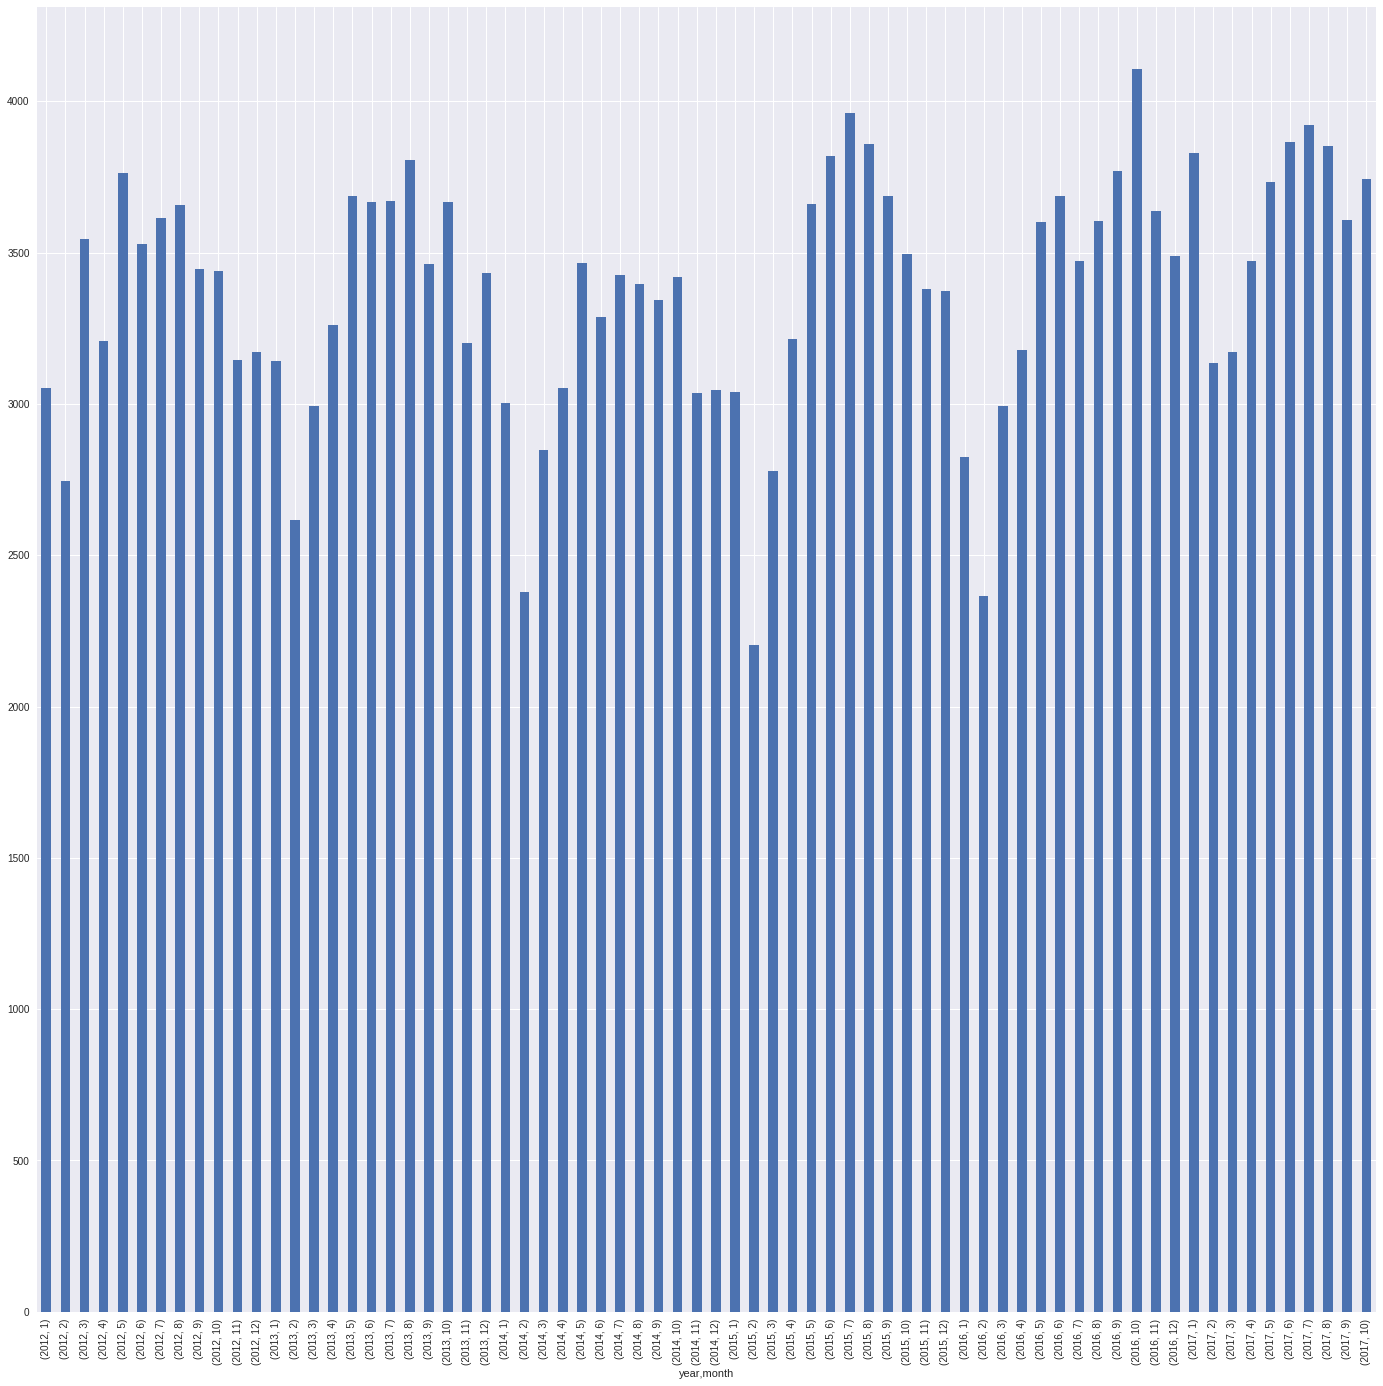

In [211]:
plt.figure(figsize=(24,24))
hour_pd['month']=hour_pd['datetime'].dt.month
hour_pd.groupby(['year','month'])['crimes'].sum().plot.bar()
plt.show()

Plot Crime by day of week and Month, notice that crime tends to occur more in the warmer months, and there is a slight spike for xmas and thanksgiving

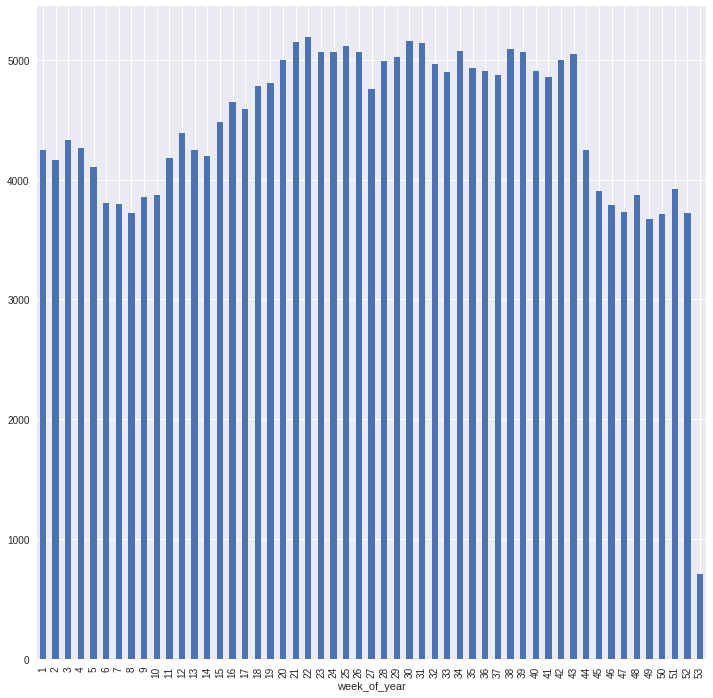

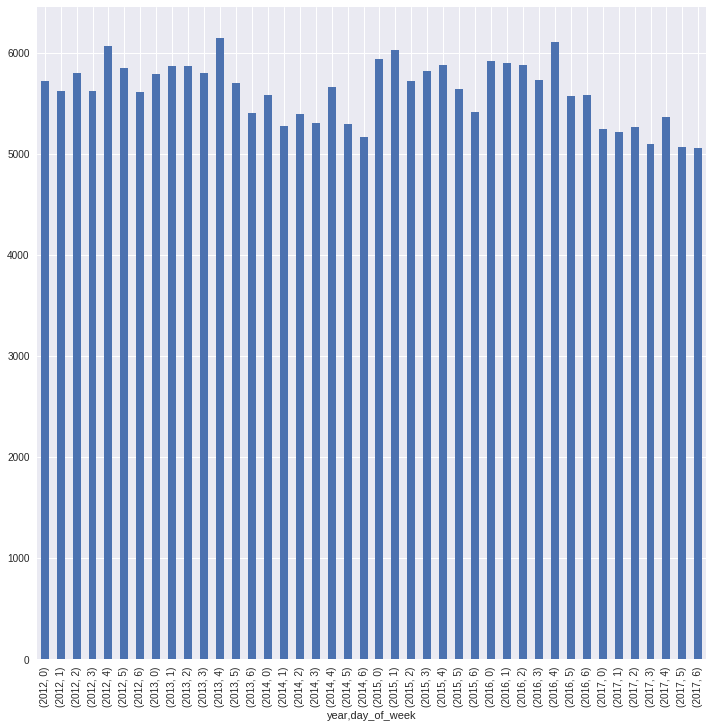

In [206]:
plt.figure(figsize=(12,12))
hour_pd['year']=hour_pd['datetime'].dt.year
hour_pd['day_of_week']=hour_pd['datetime'].dt.dayofweek
hour_pd['week_of_year']=hour_pd['datetime'].dt.weekofyear
hour_pd.groupby(['week_of_year'])['crimes'].sum().plot.bar()
plt.figure(figsize=(12,12))
hour_pd.groupby(['year','day_of_week'])['crimes'].sum().plot.bar()
plt.show()


In [ ]:
plt.figure(figsize=(24,24))
hour_pd.groupby(['month'])['crimes'].sum().plot.bar()
plt.show()

In [ ]:
hour_pd1=hour_pd[hour_pd['year']>2014]


In [745]:
from sklearn.preprocessing import StandardScaler as SS, Imputer, OneHotEncoder, PolynomialFeatures
scalar=SS()
c=0
for p in list(('incidents_prior','incidents_prior_hm','incidents_slope','incidents_slope_hm')):
    for yr in range(2015,2018):
        scalar.partial_fit(Imputer().fit_transform(an_df[p+str(yr)].reshape(-1,1)))
    for yr in range(2015,2018):
        if c==0:
            an_df2=scalar.transform(an_df[p+str(yr)].reshape(-1,1)).reshape(7951,1)
        else:
            an_df2=np.concatenate((an_df2,scalar.transform(an_df[p+str(yr)].reshape(-1,1)).reshape(7951,1)),axis=1)
        c+=1
other_list=list(( 'dist_to_bus', 'dist_to_park', 'liquor','liq_half_mile'))
an_df2=np.concatenate((an_df2,scalar.fit_transform(Imputer().fit_transform(an_df[other_list]))),axis=1)
an_df2[1:5,:]


/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/home/kevin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


array([[-1.04310512, -1.04310512, -1.04310512, -1.33381275, -1.33381275,
        -1.37156876, -0.74143978, -0.48564867, -0.48564867, -0.38647784,
        -0.39799625, -0.40951465,  1.19153465, -0.32177509],
       [-0.10507129, -1.04310512, -1.04310512, -1.0397502 , -0.98668132,
        -1.19713215, -0.48564867, -0.48564867, -0.99723088, -0.58867249,
        -0.4513856 , -0.45901265,  0.24879514, -0.32177509],
       [ 0.61838144, -0.10507129,  0.3310896 , -1.09018334, -1.01285714,
        -1.22816947, -6.62463515, -5.08988853, -0.99723088, -0.55833764,
        -0.43647818, -0.44930549, -0.37044785, -0.32177509],
       [-0.45127167,  0.14056179, -1.04310512, -1.10780067, -1.03396624,
        -1.23886643, -0.74143978,  0.02593353, -0.74143978, -0.54810308,
        -0.43402189, -0.44603043, -1.06774361, -0.32177509]])

In [755]:
hour_pd_an=hour_pd[['daylight','freezing','friday','precip','ravens','weekend','work_day','month']]
import sklearn.linear_model
import random

Create Catesian Product of tiime and spatial predictores for 1 grid point, after scaling ad centering, then create interactions and train logistic regression using Stochastic Gradient Descent since 60 GB full matrix will not fit in memory

In [ ]:
sgd=sklearn.linear_model.SGDClassifier(loss='log', penalty='l1', alpha=0.0001, max_iter=1)
hour_pd_train=hour_pd_an.sample(frac=0.8,replace=False)
hour_pd_ref=hour_pd.loc[hour_pd_train.index,:]
hour_pd_ref.reset_index(inplace=True)

test_index=set(hour_pd_an.index)-set(hour_pd_train.index)
hour_pd_test=hour_pd_an.loc[test_index,:]
c=0
for g in np.random.permutation(an_df.index):
    pf=PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
    print(c)
    c+=1
    vc_g=vict_crime[vict_crime['grid_no']==g]
    g=int(g)
    g_pd=pd.DataFrame(an_df2[g,:]).transpose()
    g_pd['key']=1;
    hour_pd_train['key']=1;
    mix=g_pd.merge(hour_pd_train,on='key')
    y=np.zeros(mix.shape[0])
    ohe=OneHotEncoder(n_values='auto', categorical_features=[False, False, False, False, False, False, False,
                                                           False,False, False,False,False,False,True,True
                                                           ,True,True,True,True,True,True,True,True])
    for v in vc_g['dt']:
        if v in set(hour_pd_ref['datetime']):
            ind=hour_pd_ref[hour_pd_ref['datetime']==v].index.values
            y[ind]=1
    train=pf.fit_transform(train)
    sgd.partial_fit(train,np.transpose(y),classes=np.array([0,1]))
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
vc_by_year.columns